# Project 2: advanced lane finding
## The steps of this project are as following:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Ouput visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
- Video pipeline.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from helper_functions import *  # !implemented helper function for the second project! #
%matplotlib inline

### Step 1: Camera calibration
1. Generate obj_points (3d points in real world space) and img_points based on camera calibration images
2. Compute the camera calibration matrix and distortion coefficients and save them under "./pickle_data/mtx_dist.p"

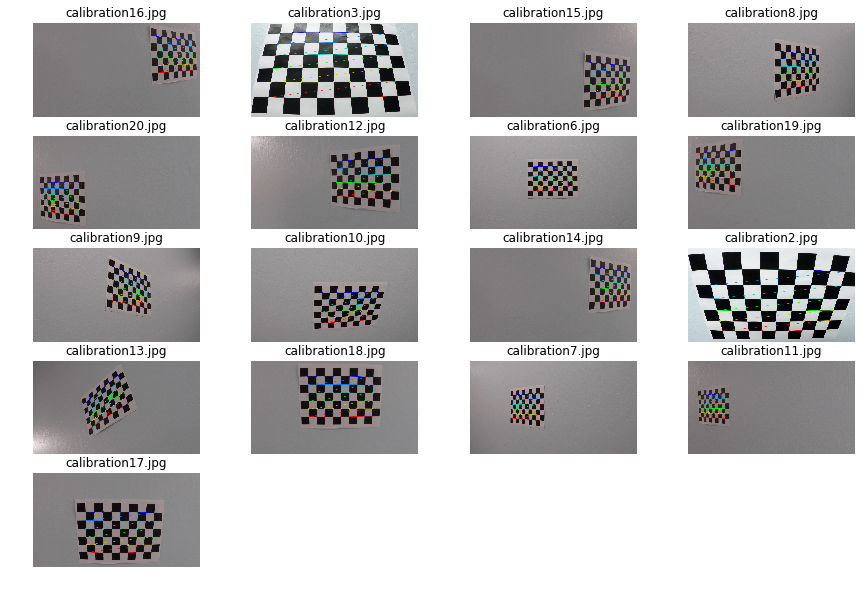

In [2]:
fnames = glob.glob("./camera_cal/calibration*.jpg")
obj_points, img_points = calibrate_camera(fnames, True)  # following images are saved under './temp/' directory

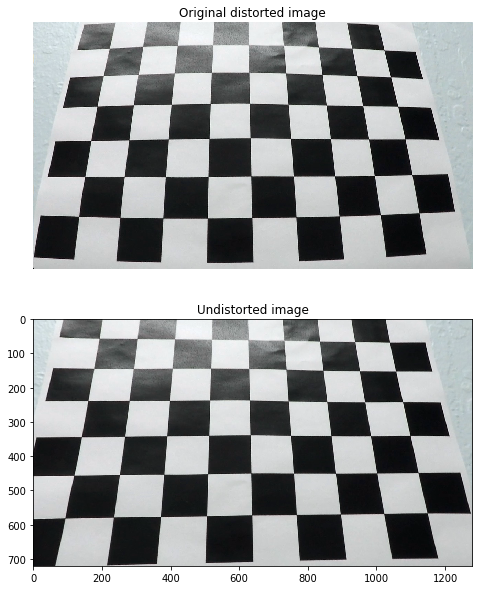

In [3]:
fname_calibration_pickle = "./pickle_data/mtx_dist.p"
save_calibration_pickle(fnames[1], obj_points, img_points, fname_calibration_pickle, flag_draw=True)

### Step 2: Apply a distortion correction to raw images
1. Load the saved camera calibration matrix and distortion coefficients from "./pickle_data/mtx_dist.p"
2. Apply them to a raw image

[I] dist_pickle["mtx"]:  [[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[I] dist_pickle["dist"]:  [[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


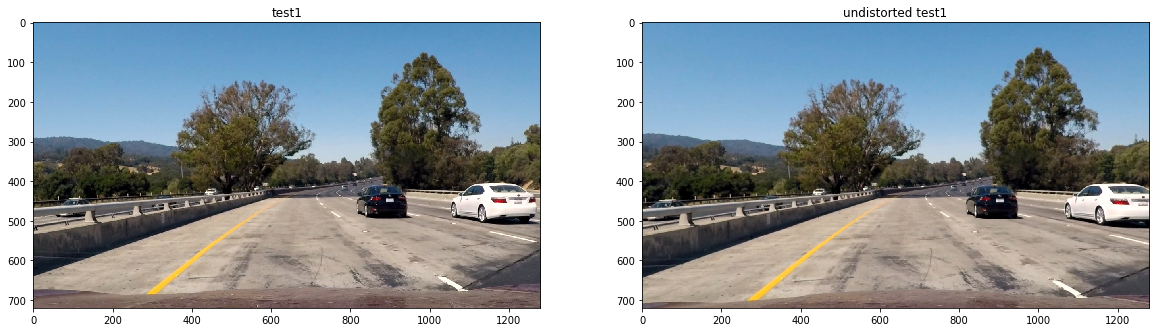

In [4]:
dist_pickle = load_calibration_pickle(fname_calibration_pickle)
print('[I] dist_pickle["mtx"]: ',  dist_pickle["mtx"])
print('[I] dist_pickle["dist"]: ', dist_pickle["dist"])
test1_img = mpimg.imread("./test_images/test1.jpg")
undistorted_test1_img = undistort_image(test1_img, dist_pickle)
plot_two_images(test1_img, undistorted_test1_img, img1_title="test1", img2_title="undistorted test1", gray=True)

### Step 3: Use gradients, color tranforms, etc., to create a combined thresholded binary image
1. Apply different gradient thresholds (e.g. x-derivative, y-derivative, magnitude, and direction)
2. Apply color thresholds
3. Combine gradient thresholds and a color threshold on Saturation channel to generate a thresholded binary image, in which lane lines are identified

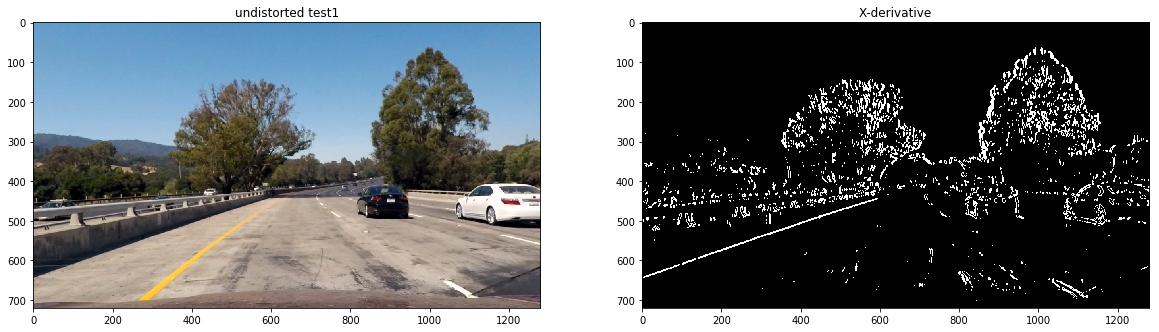

In [5]:
gradx_img = abs_sobel_thresh(undistorted_test1_img, orient='x', sobel_kernel=15, abs_thresh=(30,100))
plot_two_images(undistorted_test1_img, gradx_img, img1_title="undistorted test1", img2_title="X-derivative", gray=True)

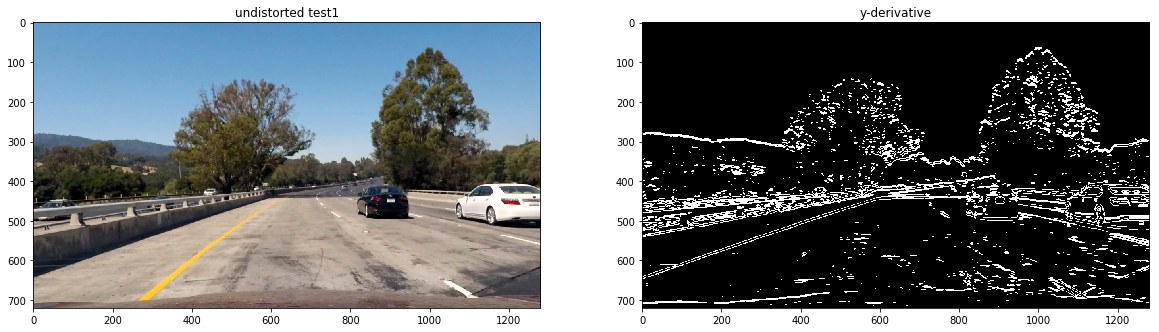

In [6]:
grady_img = abs_sobel_thresh(undistorted_test1_img, orient='y', sobel_kernel=15, abs_thresh=(30,100))
plot_two_images(undistorted_test1_img, grady_img, img1_title="undistorted test1", img2_title="y-derivative", gray=True)

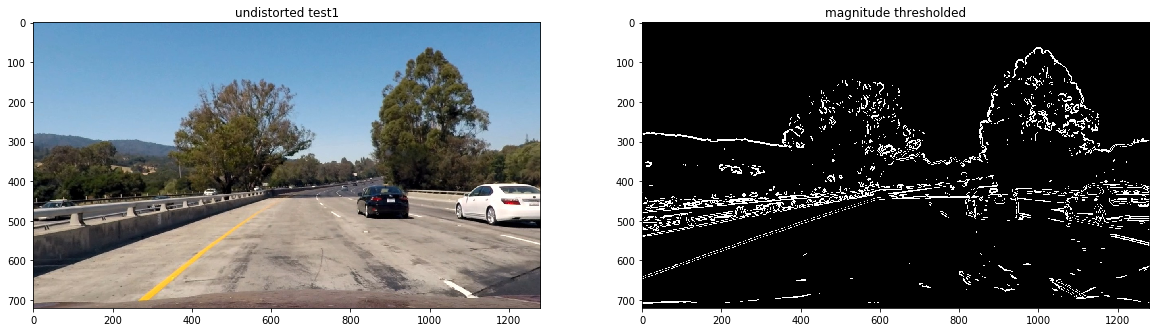

In [7]:
mag_img = mag_thresh(undistorted_test1_img, sobel_kernel=15, mag_thresh=(50,100))
plot_two_images(undistorted_test1_img, mag_img, img1_title="undistorted test1", img2_title="magnitude thresholded", gray=True)

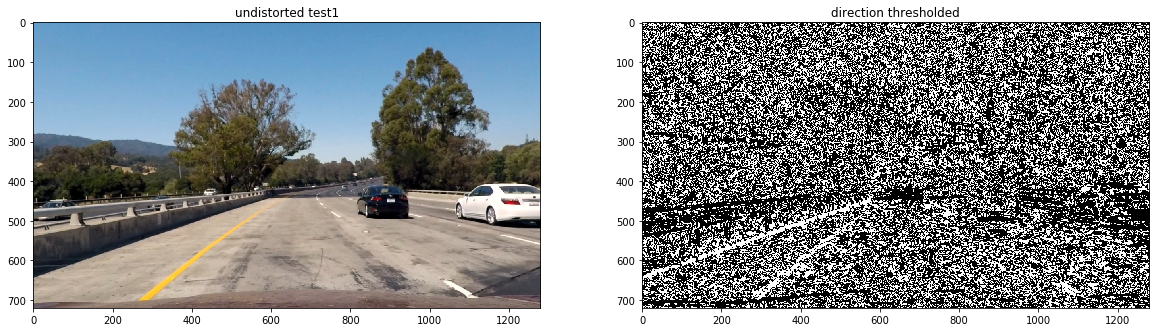

In [8]:
dir_img = dir_threshold(undistorted_test1_img, sobel_kernel=15, dir_thresh=(0.7, 1.3))
plot_two_images(undistorted_test1_img, dir_img, img1_title="undistorted test1", img2_title="direction thresholded", gray=True)

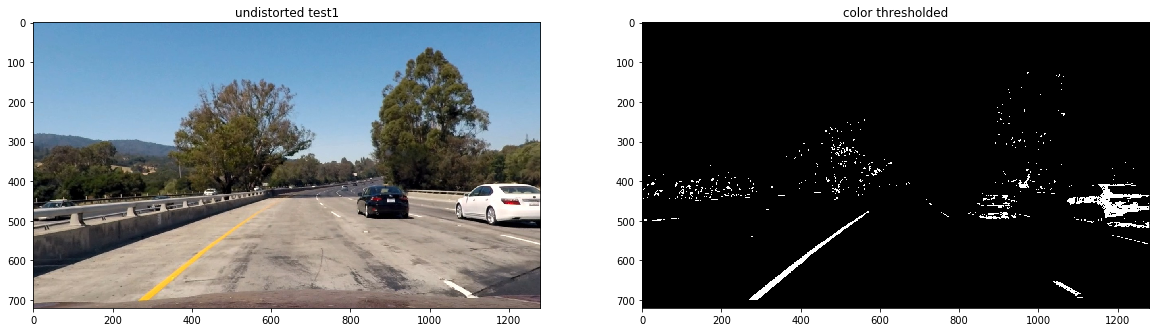

In [9]:
# apply threshold only on S-channel
col_img = col_threshold(undistorted_test1_img, sc_thresh=(170, 255)) 
plot_two_images(undistorted_test1_img, col_img, img1_title="undistorted test1", img2_title="color thresholded", gray=True)

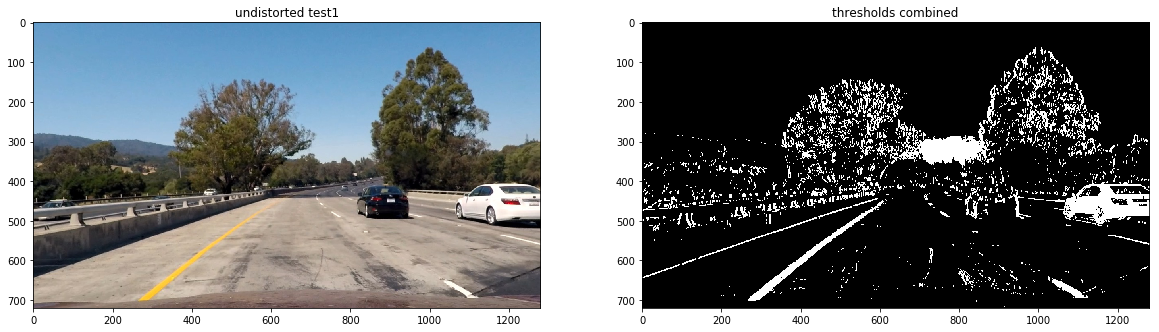

In [10]:
combined_binary = combine_threshs(undistorted_test1_img)
plot_two_images(undistorted_test1_img, combined_binary, img1_title="undistorted test1", img2_title="thresholds combined", gray=True)

### Step 4: Apply a perspective transfrom to change an image's perspective from normal view to top-down view
1. Compute the perspective transform (M) and inverse perspective transform (Minv) and save them under "./pickle_data/perspective.p"
2. Load the computed perspective transform and apply it to a raw image

In [11]:
fname_perspective_pickle = "./pickle_data/perspective.p"
save_perspective_transform_pickle(fname_perspective_pickle)
perspective_pickle = load_perspective_transform_pickle(fname_perspective_pickle)
print('#[I] perspective_pickle["M"]: ', perspective_pickle["M"])
print('#[I] perspective_pickle["Minv"]: ', perspective_pickle["Minv"])

#[I] perspective_pickle["M"]:  [[ -6.57037286e-01  -1.46279812e+00   1.03762345e+03]
 [ -5.55111512e-15  -2.04366812e+00   9.40087336e+02]
 [ -8.13151629e-18  -2.40174672e-03   1.00000000e+00]]
#[I] perspective_pickle["Minv"]:  [[  1.59509202e-01  -7.66559829e-01   5.55122699e+02]
 [ -6.66133815e-16  -4.89316239e-01   4.60000000e+02]
 [  0.00000000e+00  -1.17521368e-03   1.00000000e+00]]


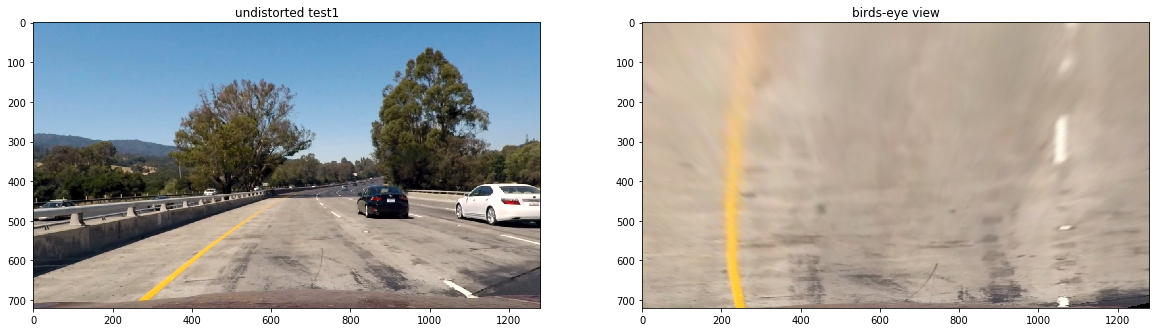

In [12]:
warped_img = perspective_transform(undistorted_test1_img, perspective_pickle)
plot_two_images(undistorted_test1_img, warped_img, img1_title="undistorted test1", img2_title="birds-eye view", gray=True)

### Step 5: Detect lane pixels and fit to find the lane boundary
1. Use the sliding window and histogram technique to detect lane pixels
2. Fix detected left and right lane pixels to two second-order polynomials

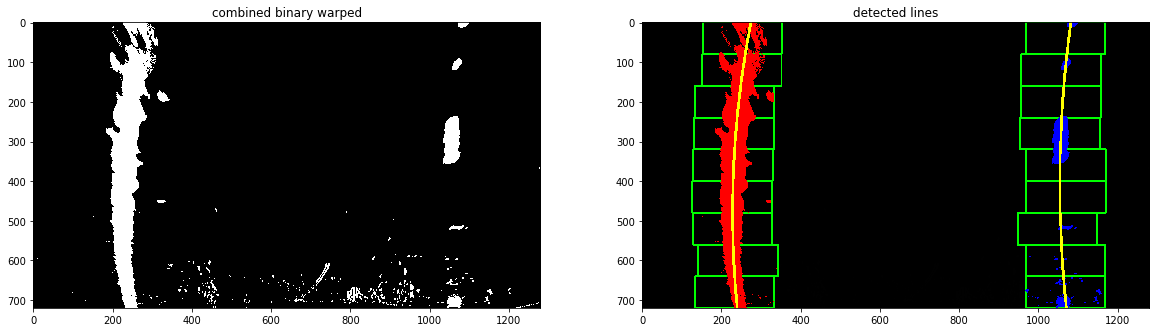

In [13]:
binary_warped = combine_threshs(warped_img)
(left_fit, right_fit), (left_fitx, right_fitx), ploty, lines_img = detect_lines(binary_warped, True)
plot_two_images(binary_warped, lines_img, img1_title="combined binary warped", img2_title="detected lines", gray=True)

### Step 6: Determine the curvature of the lane and car position with respect to center

In [14]:
curvature_rads = compute_radiuses((left_fitx, right_fitx), ploty, ym_per_pix=30 / 720, xm_per_pix=3.7 / 700)
print("#[I] radius of left lane line(m): ", curvature_rads[0])
print("#[I] radius of left lane line(m): ", curvature_rads[1])
car_offset = car_position(binary_warped.shape, (left_fitx, right_fitx), xm_per_pix=3.7 / 700)
print("#[I] car offset from center(m): ", car_offset)

#[I] radius of left lane line(m):  823.628767548
#[I] radius of left lane line(m):  1016.10972608
#[I] car offset from center(m):  0.078235089603


### Step 7: Warp the detected lane boundaries onto the original image

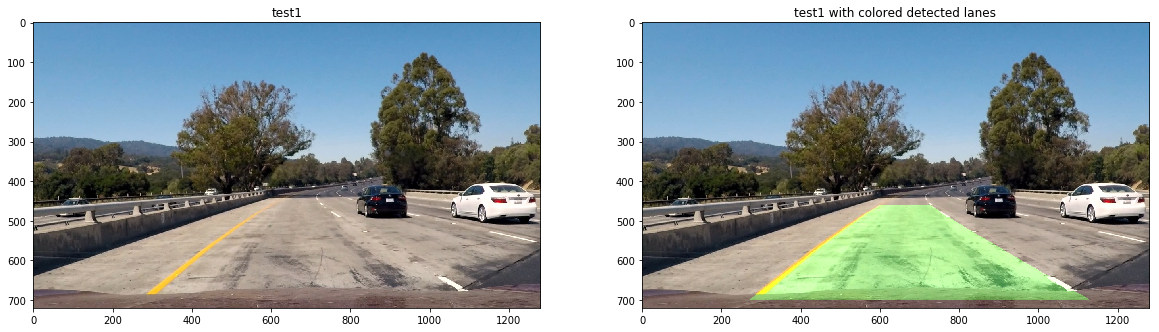

In [15]:
Minv = perspective_pickle["Minv"]
detected_lanes_img = draw_lane(test1_img, (left_fitx, right_fitx), ploty, Minv)
plot_two_images(test1_img, detected_lanes_img, "test1", "test1 with colored detected lanes", True)

### Step 8: Define a class named ProcessImage for processing a video

class ProcessImage:

    def __init__(self, fname_calibration_pickle, fname_pespective_pickle):
        self.dist_pickle = load_calibration_pickle(fname_calibration_pickle)
        self.perspective_pickle = load_perspective_transform_pickle(fname_pespective_pickle)
        self.left_line = Line(buffer_len=16)
        self.right_line = Line(buffer_len=16)
        self.processed_frames = 0
        # region of interest
        self.vertices = np.array([[(120, 710), (120, 0), (1150, 0), (1200, 710)]], dtype=np.int32)

    def __call__(self, img):
        undistorted_img = undistort_image(img, self.dist_pickle)
        binary_img = combine_threshs(undistorted_img)
        warped_binary_img = perspective_transform(binary_img, self.perspective_pickle)
        frame_height = warped_binary_img.shape[0]
        masked_warped_binary_img = region_of_interest(warped_binary_img, self.vertices)
        if (self.processed_frames > 0) and self.left_line.detected and self.right_line.detected:
            self.left_line, self.right_line = get_fit_coeffs_by_previous_fits(masked_warped_binary_img, self.left_line,
                                                                              self.right_line)
        else:
            self.left_line, self.right_line = get_fit_coeffs_by_sliding_window(masked_warped_binary_img, self.left_line,
                                                                               self.right_line)
        left_avg_fit = self.left_line.average_fit()
        right_avg_fit = self.right_line.average_fit()
        avg_line_fits, ploty = generate_line_polynomial(frame_height, left_avg_fit, right_avg_fit)
        final_output = draw_lane(img, avg_line_fits, ploty, self.perspective_pickle["Minv"])
        # compute radiuses
        radiuses = compute_radiuses(avg_line_fits, ploty)
        # compute car offset
        if self.left_line.detected and self.right_line.detected:
            line_fits, ploty = generate_line_polynomial(frame_height, self.left_line.fit, self.right_line.fit)
            car_offset = car_position(warped_binary_img.shape, line_fits)
        else:
            car_offset = -1
        print('#[I] frame: ', self.processed_frames, ', left: ', radiuses[0], ', right: ', radiuses[1], ', offset: ',
              car_offset)

        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1.2
        font_color = (255, 255, 255)
        cv2.putText(final_output, "Left lane line curvature: {:.0f} m".format(radiuses[0]), (50, 50),
                    font, font_scale, font_color, 2)
        cv2.putText(final_output, "Right lane line curvature: {:.0f} m".format(radiuses[1]), (50, 120),
                    font, font_scale, font_color, 2)
        cv2.putText(final_output, "Car is {:.2f} m right of center".format(car_offset), (50, 190),
                    font, font_scale, font_color, 2)
        cv2.putText(final_output, "Frame: {}".format(self.processed_frames), (50, 260),
                    font, font_scale, font_color, 2)
        self.processed_frames += 1
        return final_output

In [16]:
prcoess_image = ProcessImage(fname_calibration_pickle, fname_perspective_pickle)
my_clip = VideoFileClip("./project_video.mp4")
clip  = my_clip.fl_image(prcoess_image)
clip.write_videofile("./processed_project_video.mp4", audio=False)

#[I] frame:  0 , left:  916.102197097 , right:  952.156689307 , offset:  0.264057412206
[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


  0%|          | 1/1261 [00:00<05:16,  3.98it/s]

#[I] frame:  1 , left:  913.41795365 , right:  916.964127864 , offset:  0.260364280854


  0%|          | 2/1261 [00:00<05:15,  3.99it/s]

#[I] frame:  2 , left:  874.710271317 , right:  959.180406049 , offset:  0.263175778557


  0%|          | 3/1261 [00:00<05:00,  4.18it/s]

#[I] frame:  3 , left:  843.440235003 , right:  794.311446485 , offset:  0.240169057943


  0%|          | 4/1261 [00:00<04:50,  4.33it/s]

#[I] frame:  4 , left:  831.721022026 , right:  717.722538625 , offset:  0.254052960923


  0%|          | 5/1261 [00:01<04:42,  4.44it/s]

#[I] frame:  5 , left:  831.23861584 , right:  687.449006087 , offset:  0.264279757044


  0%|          | 6/1261 [00:01<04:39,  4.49it/s]

#[I] frame:  6 , left:  843.584040542 , right:  697.292549953 , offset:  0.281348595919


  1%|          | 7/1261 [00:01<04:36,  4.53it/s]

#[I] frame:  7 , left:  853.621675073 , right:  725.981571632 , offset:  0.297830459391


  1%|          | 8/1261 [00:01<04:33,  4.59it/s]

#[I] frame:  8 , left:  862.892330096 , right:  844.451475396 , offset:  0.403185987386


  1%|          | 9/1261 [00:01<04:32,  4.60it/s]

#[I] frame:  9 , left:  875.499683762 , right:  975.179491905 , offset:  0.394482463416


  1%|          | 10/1261 [00:02<04:29,  4.63it/s]

#[I] frame:  10 , left:  889.382648342 , right:  1102.99247312 , offset:  0.376155688405


  1%|          | 11/1261 [00:02<04:26,  4.69it/s]

#[I] frame:  11 , left:  904.882263811 , right:  1136.49549792 , offset:  0.322224513767


  1%|          | 12/1261 [00:02<04:27,  4.67it/s]

#[I] frame:  12 , left:  931.187479937 , right:  1207.71246107 , offset:  0.334392413919


  1%|          | 13/1261 [00:02<04:25,  4.71it/s]

#[I] frame:  13 , left:  957.409428181 , right:  1237.00028655 , offset:  0.316881209237


  1%|          | 14/1261 [00:03<04:23,  4.74it/s]

#[I] frame:  14 , left:  985.673445888 , right:  1293.26128261 , offset:  0.321235485181


  1%|          | 15/1261 [00:03<04:24,  4.71it/s]

#[I] frame:  15 , left:  1011.73718441 , right:  1233.77544717 , offset:  0.279357360314


  1%|▏         | 16/1261 [00:03<04:24,  4.71it/s]

#[I] frame:  16 , left:  1063.06340515 , right:  1189.02047463 , offset:  0.276570344826


  1%|▏         | 17/1261 [00:03<04:27,  4.66it/s]

#[I] frame:  17 , left:  1117.74179324 , right:  1171.22024294 , offset:  0.2742113871


  1%|▏         | 18/1261 [00:03<04:25,  4.68it/s]

#[I] frame:  18 , left:  1205.48243803 , right:  1166.02052873 , offset:  0.276334180858


  2%|▏         | 19/1261 [00:04<04:26,  4.66it/s]

#[I] frame:  19 , left:  1334.81844005 , right:  1259.63108719 , offset:  0.279350923961


  2%|▏         | 20/1261 [00:04<04:23,  4.70it/s]

#[I] frame:  20 , left:  1501.43301214 , right:  1399.32609149 , offset:  0.289272568061


  2%|▏         | 21/1261 [00:04<04:24,  4.68it/s]

#[I] frame:  21 , left:  1732.70283792 , right:  1631.68219347 , offset:  0.328596368866


  2%|▏         | 22/1261 [00:04<04:22,  4.72it/s]

#[I] frame:  22 , left:  2036.4776105 , right:  1854.79374757 , offset:  0.314661735774


  2%|▏         | 23/1261 [00:04<04:22,  4.72it/s]

#[I] frame:  23 , left:  2482.35331792 , right:  2053.76456016 , offset:  0.293924503641


  2%|▏         | 24/1261 [00:05<05:28,  3.76it/s]

#[I] frame:  24 , left:  3012.31919087 , right:  1727.29013637 , offset:  0.21626671852


  2%|▏         | 25/1261 [00:05<05:40,  3.63it/s]

#[I] frame:  25 , left:  3591.61521876 , right:  1481.20124649 , offset:  0.208513770052


  2%|▏         | 26/1261 [00:05<05:17,  3.89it/s]

#[I] frame:  26 , left:  4459.42599043 , right:  1313.28818883 , offset:  0.208222620294


  2%|▏         | 27/1261 [00:06<05:00,  4.11it/s]

#[I] frame:  27 , left:  5478.74764247 , right:  1295.20405814 , offset:  0.215421375276


  2%|▏         | 28/1261 [00:06<04:48,  4.27it/s]

#[I] frame:  28 , left:  6539.98243333 , right:  1255.23295144 , offset:  0.214052265882


  2%|▏         | 29/1261 [00:06<04:40,  4.40it/s]

#[I] frame:  29 , left:  6989.57676262 , right:  1171.44518522 , offset:  0.186596718241


  2%|▏         | 30/1261 [00:06<04:37,  4.44it/s]

#[I] frame:  30 , left:  7038.7561532 , right:  1047.562958 , offset:  0.184627044917


  2%|▏         | 31/1261 [00:06<04:32,  4.52it/s]

#[I] frame:  31 , left:  6678.35444845 , right:  1027.09179892 , offset:  0.193183417795


  3%|▎         | 32/1261 [00:07<04:28,  4.58it/s]

#[I] frame:  32 , left:  5752.70910477 , right:  1045.42645996 , offset:  0.203914356895


  3%|▎         | 33/1261 [00:07<04:25,  4.62it/s]

#[I] frame:  33 , left:  5175.68615411 , right:  1097.71466165 , offset:  0.258879678788


  3%|▎         | 34/1261 [00:07<04:25,  4.62it/s]

#[I] frame:  34 , left:  4257.94814301 , right:  1183.20908692 , offset:  0.298899635495


  3%|▎         | 35/1261 [00:07<04:23,  4.65it/s]

#[I] frame:  35 , left:  3371.36361109 , right:  1239.98088331 , offset:  0.270447509785


  3%|▎         | 36/1261 [00:08<04:22,  4.67it/s]

#[I] frame:  36 , left:  2652.89414366 , right:  1185.99904133 , offset:  0.209296647648


  3%|▎         | 37/1261 [00:08<04:19,  4.71it/s]

#[I] frame:  37 , left:  2116.53865289 , right:  1095.1729285 , offset:  0.205533716692


  3%|▎         | 38/1261 [00:08<04:20,  4.69it/s]

#[I] frame:  38 , left:  1711.77234281 , right:  1034.12355431 , offset:  0.218224190037


  3%|▎         | 39/1261 [00:08<04:18,  4.72it/s]

#[I] frame:  39 , left:  1420.93941775 , right:  911.651754836 , offset:  0.166126588732


  3%|▎         | 40/1261 [00:08<04:17,  4.75it/s]

#[I] frame:  40 , left:  1231.82747293 , right:  858.302990456 , offset:  0.168211653406


  3%|▎         | 41/1261 [00:09<04:17,  4.74it/s]

#[I] frame:  41 , left:  1096.84652637 , right:  814.393703557 , offset:  0.179740885025


  3%|▎         | 42/1261 [00:09<04:17,  4.73it/s]

#[I] frame:  42 , left:  995.628896235 , right:  779.910718464 , offset:  0.201750473814


  3%|▎         | 43/1261 [00:09<05:58,  3.40it/s]

#[I] frame:  43 , left:  928.179918883 , right:  740.320599768 , offset:  0.217123173053


  3%|▎         | 44/1261 [00:10<05:57,  3.41it/s]

#[I] frame:  44 , left:  882.397956231 , right:  706.448053748 , offset:  0.229053830824


  4%|▎         | 45/1261 [00:10<05:57,  3.40it/s]

#[I] frame:  45 , left:  847.744799207 , right:  710.218450772 , offset:  0.242077983653


  4%|▎         | 46/1261 [00:10<05:56,  3.41it/s]

#[I] frame:  46 , left:  827.938703155 , right:  755.2225282 , offset:  0.299660929308


  4%|▎         | 47/1261 [00:10<05:48,  3.48it/s]

#[I] frame:  47 , left:  817.12609242 , right:  811.033125796 , offset:  0.315719635099


  4%|▍         | 48/1261 [00:11<05:51,  3.45it/s]

#[I] frame:  48 , left:  808.598787134 , right:  838.130878366 , offset:  0.279852848124


  4%|▍         | 49/1261 [00:11<05:38,  3.58it/s]

#[I] frame:  49 , left:  801.327447743 , right:  833.612635456 , offset:  0.272854221044


  4%|▍         | 50/1261 [00:11<05:50,  3.46it/s]

#[I] frame:  50 , left:  800.823554376 , right:  772.414309869 , offset:  0.238282171594


  4%|▍         | 51/1261 [00:12<05:38,  3.58it/s]

#[I] frame:  51 , left:  810.116758362 , right:  741.432752691 , offset:  0.251110468245


  4%|▍         | 52/1261 [00:12<05:37,  3.58it/s]

#[I] frame:  52 , left:  827.737393535 , right:  732.275693901 , offset:  0.234588374312


  4%|▍         | 53/1261 [00:12<05:49,  3.46it/s]

#[I] frame:  53 , left:  850.081783709 , right:  703.428410939 , offset:  0.213327971313


  4%|▍         | 54/1261 [00:12<05:40,  3.55it/s]

#[I] frame:  54 , left:  895.919293024 , right:  668.070957284 , offset:  0.220591523582


  4%|▍         | 55/1261 [00:13<05:46,  3.48it/s]

#[I] frame:  55 , left:  957.823588438 , right:  675.921614352 , offset:  0.226123468845


  4%|▍         | 56/1261 [00:13<05:37,  3.57it/s]

#[I] frame:  56 , left:  1060.132779 , right:  694.844120792 , offset:  0.236879215565


  5%|▍         | 57/1261 [00:13<05:51,  3.42it/s]

#[I] frame:  57 , left:  1199.77505942 , right:  723.589931336 , offset:  0.248814650099


  5%|▍         | 58/1261 [00:14<05:39,  3.54it/s]

#[I] frame:  58 , left:  1375.83696223 , right:  774.556281935 , offset:  0.301198858542


  5%|▍         | 59/1261 [00:14<05:50,  3.43it/s]

#[I] frame:  59 , left:  1566.46880773 , right:  822.485638933 , offset:  0.277547806181


  5%|▍         | 60/1261 [00:14<05:44,  3.49it/s]

#[I] frame:  60 , left:  1730.88308187 , right:  844.388432823 , offset:  0.228542325578


  5%|▍         | 61/1261 [00:14<05:51,  3.41it/s]

#[I] frame:  61 , left:  1930.19383724 , right:  879.634826976 , offset:  0.234910464357


  5%|▍         | 62/1261 [00:15<05:42,  3.50it/s]

#[I] frame:  62 , left:  2067.8835902 , right:  845.339073539 , offset:  0.184819740187


  5%|▍         | 63/1261 [00:15<05:50,  3.42it/s]

#[I] frame:  63 , left:  2191.84140702 , right:  796.5190569 , offset:  0.170692753339


  5%|▌         | 64/1261 [00:15<05:46,  3.45it/s]

#[I] frame:  64 , left:  2280.47172422 , right:  751.732187803 , offset:  0.146600638456


  5%|▌         | 65/1261 [00:16<05:58,  3.33it/s]

#[I] frame:  65 , left:  2348.85067569 , right:  717.690615596 , offset:  0.144479104852


  5%|▌         | 66/1261 [00:16<05:48,  3.43it/s]

#[I] frame:  66 , left:  2393.14937846 , right:  718.081388514 , offset:  0.145086267759


  5%|▌         | 67/1261 [00:16<06:04,  3.28it/s]

#[I] frame:  67 , left:  2424.31090127 , right:  713.664167404 , offset:  0.143671824102


  5%|▌         | 68/1261 [00:17<05:56,  3.35it/s]

#[I] frame:  68 , left:  2492.22655008 , right:  731.320538725 , offset:  0.144696332396


  5%|▌         | 69/1261 [00:17<06:03,  3.28it/s]

#[I] frame:  69 , left:  2541.28186072 , right:  779.468961523 , offset:  0.144147273219


  6%|▌         | 70/1261 [00:17<06:18,  3.15it/s]

#[I] frame:  70 , left:  2520.95166177 , right:  847.696262704 , offset:  0.155339680609


  6%|▌         | 71/1261 [00:17<06:09,  3.22it/s]

#[I] frame:  71 , left:  2506.23417963 , right:  929.000980212 , offset:  0.178627336155


  6%|▌         | 72/1261 [00:18<06:23,  3.10it/s]

#[I] frame:  72 , left:  2411.6414219 , right:  969.133237588 , offset:  0.121200458963


  6%|▌         | 73/1261 [00:18<06:13,  3.18it/s]

#[I] frame:  73 , left:  2361.1225432 , right:  974.409340223 , offset:  0.106113508959


  6%|▌         | 74/1261 [00:18<06:23,  3.09it/s]

#[I] frame:  74 , left:  2306.05836072 , right:  947.020258456 , offset:  0.110925785896


  6%|▌         | 75/1261 [00:19<06:12,  3.18it/s]

#[I] frame:  75 , left:  2350.77047974 , right:  940.167654224 , offset:  0.119008871473


  6%|▌         | 76/1261 [00:19<06:22,  3.10it/s]

#[I] frame:  76 , left:  2469.09920338 , right:  909.838699126 , offset:  0.0814173246378


  6%|▌         | 77/1261 [00:19<06:12,  3.17it/s]

#[I] frame:  77 , left:  2754.24842126 , right:  869.691219875 , offset:  0.0932576453004


  6%|▌         | 78/1261 [00:20<06:22,  3.09it/s]

#[I] frame:  78 , left:  3318.43728624 , right:  848.644562016 , offset:  0.0855364459656


  6%|▋         | 79/1261 [00:20<06:09,  3.19it/s]

#[I] frame:  79 , left:  4303.39503878 , right:  821.129743444 , offset:  0.0804745394248


  6%|▋         | 80/1261 [00:20<06:20,  3.10it/s]

#[I] frame:  80 , left:  6726.390906 , right:  811.860666892 , offset:  0.0795285427182


  6%|▋         | 81/1261 [00:21<06:25,  3.06it/s]

#[I] frame:  81 , left:  14776.2991186 , right:  811.723015003 , offset:  0.078782233172


  7%|▋         | 82/1261 [00:21<06:11,  3.18it/s]

#[I] frame:  82 , left:  38443.0933808 , right:  810.901689407 , offset:  0.0766939373491


  7%|▋         | 83/1261 [00:21<06:14,  3.15it/s]

#[I] frame:  83 , left:  8919.222845 , right:  830.128439299 , offset:  0.119756640464


  7%|▋         | 84/1261 [00:22<06:20,  3.09it/s]

#[I] frame:  84 , left:  4894.85111823 , right:  848.719358971 , offset:  0.129346073169


  7%|▋         | 85/1261 [00:22<06:06,  3.21it/s]

#[I] frame:  85 , left:  3393.88474244 , right:  877.26830465 , offset:  0.144256680156


  7%|▋         | 86/1261 [00:22<06:20,  3.09it/s]

#[I] frame:  86 , left:  2750.53182091 , right:  898.271722803 , offset:  0.126034734694


  7%|▋         | 87/1261 [00:23<06:20,  3.09it/s]

#[I] frame:  87 , left:  2530.68612643 , right:  855.908669941 , offset:  0.0557248409247


  7%|▋         | 88/1261 [00:23<06:24,  3.05it/s]

#[I] frame:  88 , left:  2570.82869197 , right:  875.056063578 , offset:  0.0651450245354


  7%|▋         | 89/1261 [00:23<06:12,  3.14it/s]

#[I] frame:  89 , left:  2854.04386514 , right:  857.372525559 , offset:  0.0131404540295


  7%|▋         | 90/1261 [00:24<06:21,  3.07it/s]

#[I] frame:  90 , left:  3429.51578546 , right:  816.475023973 , offset:  0.00719549954263


  7%|▋         | 91/1261 [00:24<06:07,  3.18it/s]

#[I] frame:  91 , left:  4414.17856477 , right:  776.652733154 , offset:  0.0187661212719


  7%|▋         | 92/1261 [00:24<06:20,  3.07it/s]

#[I] frame:  92 , left:  6330.38669226 , right:  783.205154346 , offset:  0.0301685162863


  7%|▋         | 93/1261 [00:25<06:08,  3.17it/s]

#[I] frame:  93 , left:  12279.6286336 , right:  789.923680767 , offset:  0.0459158387761


  7%|▋         | 94/1261 [00:25<06:11,  3.14it/s]

#[I] frame:  94 , left:  217039.304437 , right:  820.593309942 , offset:  0.0551540793996


  8%|▊         | 95/1261 [00:25<06:08,  3.16it/s]

#[I] frame:  95 , left:  11381.5158705 , right:  877.462023747 , offset:  0.0635084457265


  8%|▊         | 96/1261 [00:25<06:11,  3.14it/s]

#[I] frame:  96 , left:  5574.37653534 , right:  994.277412775 , offset:  0.139239189086


  8%|▊         | 97/1261 [00:26<06:11,  3.13it/s]

#[I] frame:  97 , left:  3725.06040906 , right:  1075.93403306 , offset:  0.0885786262235


  8%|▊         | 98/1261 [00:26<06:12,  3.12it/s]

#[I] frame:  98 , left:  2792.57868594 , right:  1144.8540093 , offset:  0.083169833169


  8%|▊         | 99/1261 [00:26<06:19,  3.06it/s]

#[I] frame:  99 , left:  2242.11713673 , right:  1108.26968539 , offset:  0.0468573623859


  8%|▊         | 100/1261 [00:27<06:08,  3.15it/s]

#[I] frame:  100 , left:  1833.6196519 , right:  1062.98674471 , offset:  0.0516684101614


  8%|▊         | 101/1261 [00:27<06:14,  3.10it/s]

#[I] frame:  101 , left:  1559.44309845 , right:  1002.51783342 , offset:  0.0603408244269


  8%|▊         | 102/1261 [00:27<06:14,  3.09it/s]

#[I] frame:  102 , left:  1388.06975236 , right:  901.296867176 , offset:  0.0333937707927


  8%|▊         | 103/1261 [00:28<05:59,  3.22it/s]

#[I] frame:  103 , left:  1302.06242278 , right:  851.626403209 , offset:  0.0363094973267


  8%|▊         | 104/1261 [00:28<06:03,  3.18it/s]

#[I] frame:  104 , left:  1267.41390531 , right:  788.954064964 , offset:  0.0520825058947


  8%|▊         | 105/1261 [00:28<05:50,  3.30it/s]

#[I] frame:  105 , left:  1286.25918969 , right:  779.236567066 , offset:  0.0696589851809


  8%|▊         | 106/1261 [00:29<05:58,  3.22it/s]

#[I] frame:  106 , left:  1333.66668011 , right:  790.328538853 , offset:  0.0814548160158


  8%|▊         | 107/1261 [00:29<05:47,  3.32it/s]

#[I] frame:  107 , left:  1389.33383033 , right:  797.390140171 , offset:  0.0965378006407


  9%|▊         | 108/1261 [00:29<05:55,  3.25it/s]

#[I] frame:  108 , left:  1436.79006319 , right:  815.694887072 , offset:  0.12412691813


  9%|▊         | 109/1261 [00:30<05:43,  3.35it/s]

#[I] frame:  109 , left:  1475.34356584 , right:  853.597130944 , offset:  0.176500252899


  9%|▊         | 110/1261 [00:30<05:48,  3.31it/s]

#[I] frame:  110 , left:  1510.00398233 , right:  903.841762376 , offset:  0.195918107531


  9%|▉         | 111/1261 [00:30<05:37,  3.41it/s]

#[I] frame:  111 , left:  1504.67265852 , right:  910.28061931 , offset:  0.148273158545


  9%|▉         | 112/1261 [00:30<05:47,  3.31it/s]

#[I] frame:  112 , left:  1512.14154029 , right:  867.945988523 , offset:  0.142994705744


  9%|▉         | 113/1261 [00:31<05:39,  3.38it/s]

#[I] frame:  113 , left:  1488.97518664 , right:  828.170420126 , offset:  0.115016159563


  9%|▉         | 114/1261 [00:31<05:47,  3.30it/s]

#[I] frame:  114 , left:  1442.93266255 , right:  793.667334815 , offset:  0.121183777978


  9%|▉         | 115/1261 [00:31<05:42,  3.35it/s]

#[I] frame:  115 , left:  1387.39009911 , right:  756.24819201 , offset:  0.100064850563


  9%|▉         | 116/1261 [00:32<05:54,  3.23it/s]

#[I] frame:  116 , left:  1344.9213215 , right:  710.27823425 , offset:  0.10460669486


  9%|▉         | 117/1261 [00:32<05:45,  3.31it/s]

#[I] frame:  117 , left:  1316.38794254 , right:  671.419438754 , offset:  0.122174450347


  9%|▉         | 118/1261 [00:32<05:56,  3.20it/s]

#[I] frame:  118 , left:  1296.94186278 , right:  666.40193826 , offset:  0.13850536196


  9%|▉         | 119/1261 [00:33<05:45,  3.31it/s]

#[I] frame:  119 , left:  1273.22704827 , right:  678.076803463 , offset:  0.149988240198


 10%|▉         | 120/1261 [00:33<05:56,  3.20it/s]

#[I] frame:  120 , left:  1232.09335117 , right:  697.140833112 , offset:  0.16613585425


 10%|▉         | 121/1261 [00:33<05:45,  3.30it/s]

#[I] frame:  121 , left:  1184.09986257 , right:  742.475143848 , offset:  0.258228276163


 10%|▉         | 122/1261 [00:33<05:56,  3.20it/s]

#[I] frame:  122 , left:  1126.21466771 , right:  762.905603229 , offset:  0.210288407097


 10%|▉         | 123/1261 [00:34<05:46,  3.29it/s]

#[I] frame:  123 , left:  1058.23841021 , right:  758.69770895 , offset:  0.170576789374


 10%|▉         | 124/1261 [00:34<05:56,  3.19it/s]

#[I] frame:  124 , left:  1004.85616183 , right:  757.055878805 , offset:  0.202721075333


 10%|▉         | 125/1261 [00:34<05:46,  3.28it/s]

#[I] frame:  125 , left:  956.29851543 , right:  723.186465933 , offset:  0.19256596316


 10%|▉         | 126/1261 [00:35<05:52,  3.22it/s]

#[I] frame:  126 , left:  924.3872194 , right:  684.101877557 , offset:  0.205884929693


 10%|█         | 127/1261 [00:35<05:39,  3.34it/s]

#[I] frame:  127 , left:  898.877309436 , right:  637.877745299 , offset:  0.170612678874


 10%|█         | 128/1261 [00:35<05:49,  3.24it/s]

#[I] frame:  128 , left:  875.712646615 , right:  599.38085475 , offset:  0.181939691663


 10%|█         | 129/1261 [00:36<05:39,  3.33it/s]

#[I] frame:  129 , left:  861.90849291 , right:  583.680743106 , offset:  0.199247124645


 10%|█         | 130/1261 [00:36<05:46,  3.27it/s]

#[I] frame:  130 , left:  859.153195479 , right:  575.784564964 , offset:  0.20971346975


 10%|█         | 131/1261 [00:36<05:35,  3.37it/s]

#[I] frame:  131 , left:  865.615991949 , right:  591.828002512 , offset:  0.219505936751


 10%|█         | 132/1261 [00:37<05:44,  3.28it/s]

#[I] frame:  132 , left:  862.737411462 , right:  618.886179233 , offset:  0.22559018602


 11%|█         | 133/1261 [00:37<05:35,  3.36it/s]

#[I] frame:  133 , left:  859.909248565 , right:  648.058049177 , offset:  0.245004923474


 11%|█         | 134/1261 [00:37<05:40,  3.31it/s]

#[I] frame:  134 , left:  850.190062002 , right:  672.311086313 , offset:  0.259376743848


 11%|█         | 135/1261 [00:37<06:00,  3.12it/s]

#[I] frame:  135 , left:  844.110583699 , right:  686.799788372 , offset:  0.252961904352


 11%|█         | 136/1261 [00:38<05:48,  3.23it/s]

#[I] frame:  136 , left:  848.435009456 , right:  693.966413428 , offset:  0.262462546719


 11%|█         | 137/1261 [00:38<05:52,  3.19it/s]

#[I] frame:  137 , left:  854.082369511 , right:  674.388220937 , offset:  0.262616941055


 11%|█         | 138/1261 [00:38<05:39,  3.31it/s]

#[I] frame:  138 , left:  870.100058143 , right:  683.653426014 , offset:  0.277372583059


 11%|█         | 139/1261 [00:39<05:44,  3.26it/s]

#[I] frame:  139 , left:  891.690446655 , right:  722.966968242 , offset:  0.285888904262


 11%|█         | 140/1261 [00:39<05:33,  3.36it/s]

#[I] frame:  140 , left:  922.269855553 , right:  738.289929281 , offset:  0.272577409104


 11%|█         | 141/1261 [00:39<05:44,  3.25it/s]

#[I] frame:  141 , left:  957.790681542 , right:  728.495742041 , offset:  0.238521186012


 11%|█▏        | 142/1261 [00:40<05:33,  3.35it/s]

#[I] frame:  142 , left:  993.572916382 , right:  716.056106102 , offset:  0.242318211056


 11%|█▏        | 143/1261 [00:40<05:38,  3.31it/s]

#[I] frame:  143 , left:  1032.00344004 , right:  750.868625507 , offset:  0.247382161068


 11%|█▏        | 144/1261 [00:40<05:41,  3.28it/s]

#[I] frame:  144 , left:  1071.00110348 , right:  796.195285476 , offset:  0.242634277258


 11%|█▏        | 145/1261 [00:40<05:44,  3.24it/s]

#[I] frame:  145 , left:  1122.2116079 , right:  846.097335557 , offset:  0.24871570157


 12%|█▏        | 146/1261 [00:41<05:34,  3.33it/s]

#[I] frame:  146 , left:  1158.99893865 , right:  923.324523221 , offset:  0.298522902728


 12%|█▏        | 147/1261 [00:41<05:38,  3.29it/s]

#[I] frame:  147 , left:  1193.6791925 , right:  1009.53186377 , offset:  0.30902246879


 12%|█▏        | 148/1261 [00:41<05:24,  3.43it/s]

#[I] frame:  148 , left:  1225.2469621 , right:  1027.88131161 , offset:  0.238564907364


 12%|█▏        | 149/1261 [00:42<05:32,  3.34it/s]

#[I] frame:  149 , left:  1250.75358115 , right:  1048.07299931 , offset:  0.245658248814


 12%|█▏        | 150/1261 [00:42<05:23,  3.44it/s]

#[I] frame:  150 , left:  1291.27853103 , right:  1054.19454534 , offset:  0.231693245602


 12%|█▏        | 151/1261 [00:42<05:21,  3.45it/s]

#[I] frame:  151 , left:  1326.23407656 , right:  1020.18948585 , offset:  0.193404545142


 12%|█▏        | 152/1261 [00:43<05:20,  3.46it/s]

#[I] frame:  152 , left:  1368.28198354 , right:  970.325394363 , offset:  0.185382595293


 12%|█▏        | 153/1261 [00:43<05:24,  3.42it/s]

#[I] frame:  153 , left:  1388.58256315 , right:  918.916370259 , offset:  0.185233069828


 12%|█▏        | 154/1261 [00:43<05:18,  3.48it/s]

#[I] frame:  154 , left:  1426.26328104 , right:  860.815691668 , offset:  0.19927746659


 12%|█▏        | 155/1261 [00:43<05:22,  3.43it/s]

#[I] frame:  155 , left:  1480.56873807 , right:  805.251568962 , offset:  0.211055009621


 12%|█▏        | 156/1261 [00:44<05:32,  3.32it/s]

#[I] frame:  156 , left:  1516.02281231 , right:  772.427517375 , offset:  0.208416274584


 12%|█▏        | 157/1261 [00:44<05:21,  3.43it/s]

#[I] frame:  157 , left:  1545.61397274 , right:  786.452408718 , offset:  0.207968373863


 13%|█▎        | 158/1261 [00:44<05:32,  3.32it/s]

#[I] frame:  158 , left:  1536.04045076 , right:  819.697737333 , offset:  0.215639333266


 13%|█▎        | 159/1261 [00:45<05:22,  3.42it/s]

#[I] frame:  159 , left:  1536.66321264 , right:  889.952419508 , offset:  0.296666960925


 13%|█▎        | 160/1261 [00:45<05:33,  3.30it/s]

#[I] frame:  160 , left:  1510.24321095 , right:  945.489783284 , offset:  0.254491897103


 13%|█▎        | 161/1261 [00:45<05:24,  3.39it/s]

#[I] frame:  161 , left:  1485.55872698 , right:  964.465709833 , offset:  0.221603245017


 13%|█▎        | 162/1261 [00:46<05:35,  3.28it/s]

#[I] frame:  162 , left:  1477.67210995 , right:  945.714296288 , offset:  0.214269443388


 13%|█▎        | 163/1261 [00:46<05:25,  3.38it/s]

#[I] frame:  163 , left:  1477.39678545 , right:  921.004959185 , offset:  0.209433535238


 13%|█▎        | 164/1261 [00:46<05:34,  3.28it/s]

#[I] frame:  164 , left:  1480.86747962 , right:  942.872465073 , offset:  0.192592408276


 13%|█▎        | 165/1261 [00:46<05:22,  3.39it/s]

#[I] frame:  165 , left:  1466.39101224 , right:  887.883812492 , offset:  0.142427766605


 13%|█▎        | 166/1261 [00:47<05:29,  3.32it/s]

#[I] frame:  166 , left:  1449.71265775 , right:  857.694146027 , offset:  0.150446303923


 13%|█▎        | 167/1261 [00:47<05:18,  3.43it/s]

#[I] frame:  167 , left:  1438.68201705 , right:  878.729774686 , offset:  0.162944068382


 13%|█▎        | 168/1261 [00:47<05:28,  3.32it/s]

#[I] frame:  168 , left:  1441.11426896 , right:  916.849387551 , offset:  0.165540507401


 13%|█▎        | 169/1261 [00:48<05:18,  3.43it/s]

#[I] frame:  169 , left:  1464.43451655 , right:  965.518242756 , offset:  0.164663450976


 13%|█▎        | 170/1261 [00:48<05:30,  3.30it/s]

#[I] frame:  170 , left:  1478.53414602 , right:  1020.89076894 , offset:  0.159687396098


 14%|█▎        | 171/1261 [00:48<05:20,  3.40it/s]

#[I] frame:  171 , left:  1489.3074472 , right:  1089.37825571 , offset:  0.179986359494


 14%|█▎        | 172/1261 [00:48<05:26,  3.33it/s]

#[I] frame:  172 , left:  1512.17083406 , right:  1163.46717491 , offset:  0.180491715798


 14%|█▎        | 173/1261 [00:49<05:18,  3.41it/s]

#[I] frame:  173 , left:  1548.89999442 , right:  1114.90010707 , offset:  0.0908658182812


 14%|█▍        | 174/1261 [00:49<05:24,  3.35it/s]

#[I] frame:  174 , left:  1600.13572454 , right:  1021.68974494 , offset:  0.0807608611785


 14%|█▍        | 175/1261 [00:49<05:13,  3.47it/s]

#[I] frame:  175 , left:  1663.62104401 , right:  866.27309678 , offset:  0.066431707185


 14%|█▍        | 176/1261 [00:50<05:19,  3.40it/s]

#[I] frame:  176 , left:  1757.91713528 , right:  723.385531588 , offset:  0.0276851081233


 14%|█▍        | 177/1261 [00:50<05:06,  3.54it/s]

#[I] frame:  177 , left:  1889.02362967 , right:  637.634830165 , offset:  0.0462790846407


 14%|█▍        | 178/1261 [00:50<05:09,  3.50it/s]

#[I] frame:  178 , left:  2043.60402625 , right:  572.120595396 , offset:  0.0701721527485


 14%|█▍        | 179/1261 [00:50<05:13,  3.45it/s]

#[I] frame:  179 , left:  2208.83191221 , right:  524.037033058 , offset:  0.0961042129935


 14%|█▍        | 180/1261 [00:51<05:06,  3.53it/s]

#[I] frame:  180 , left:  2450.14710672 , right:  489.186642124 , offset:  0.109419772396


 14%|█▍        | 181/1261 [00:51<05:13,  3.44it/s]

#[I] frame:  181 , left:  2630.55500568 , right:  482.301824023 , offset:  0.114278904526


 14%|█▍        | 182/1261 [00:51<05:06,  3.52it/s]

#[I] frame:  182 , left:  2829.89787754 , right:  476.995528045 , offset:  0.123916952898


 15%|█▍        | 183/1261 [00:52<05:07,  3.51it/s]

#[I] frame:  183 , left:  2875.06123116 , right:  474.939664567 , offset:  0.161755510923


 15%|█▍        | 184/1261 [00:52<05:10,  3.47it/s]

#[I] frame:  184 , left:  2717.86638064 , right:  471.272642871 , offset:  0.163110393006


 15%|█▍        | 185/1261 [00:52<05:14,  3.43it/s]

#[I] frame:  185 , left:  2472.52519855 , right:  468.744828217 , offset:  0.158517334066


 15%|█▍        | 186/1261 [00:52<05:03,  3.54it/s]

#[I] frame:  186 , left:  2099.76940438 , right:  448.936962002 , offset:  0.0958172431887


 15%|█▍        | 187/1261 [00:53<05:06,  3.51it/s]

#[I] frame:  187 , left:  1786.3879221 , right:  423.700022536 , offset:  0.0896576771243


 15%|█▍        | 188/1261 [00:53<05:14,  3.41it/s]

#[I] frame:  188 , left:  1543.62281085 , right:  401.475883157 , offset:  0.107010834378


 15%|█▍        | 189/1261 [00:53<05:02,  3.55it/s]

#[I] frame:  189 , left:  1347.19463678 , right:  398.730191915 , offset:  0.122668986431


 15%|█▌        | 190/1261 [00:54<05:06,  3.50it/s]

#[I] frame:  190 , left:  1207.42314877 , right:  402.133065383 , offset:  0.142183169988


 15%|█▌        | 191/1261 [00:54<05:10,  3.44it/s]

#[I] frame:  191 , left:  1085.31924979 , right:  413.118653677 , offset:  0.150943148863


 15%|█▌        | 192/1261 [00:54<05:02,  3.54it/s]

#[I] frame:  192 , left:  1004.17918435 , right:  439.711432978 , offset:  0.171607289612


 15%|█▌        | 193/1261 [00:55<05:08,  3.46it/s]

#[I] frame:  193 , left:  924.934381927 , right:  465.242968418 , offset:  0.179641304978


 15%|█▌        | 194/1261 [00:55<05:40,  3.14it/s]

#[I] frame:  194 , left:  859.362001439 , right:  489.517885182 , offset:  0.180552426331


 15%|█▌        | 195/1261 [00:55<05:33,  3.19it/s]

#[I] frame:  195 , left:  802.529892775 , right:  506.682611549 , offset:  0.173045392781


 16%|█▌        | 196/1261 [00:55<05:17,  3.35it/s]

#[I] frame:  196 , left:  765.117937699 , right:  532.254431666 , offset:  0.203981797245


 16%|█▌        | 197/1261 [00:56<05:23,  3.29it/s]

#[I] frame:  197 , left:  751.436975679 , right:  575.440192357 , offset:  0.262643469622


 16%|█▌        | 198/1261 [00:56<05:10,  3.43it/s]

#[I] frame:  198 , left:  747.685846851 , right:  615.327957223 , offset:  0.244352782814


 16%|█▌        | 199/1261 [00:56<05:12,  3.40it/s]

#[I] frame:  199 , left:  765.686815924 , right:  648.463500718 , offset:  0.241396660272


 16%|█▌        | 200/1261 [00:57<05:02,  3.51it/s]

#[I] frame:  200 , left:  786.865327373 , right:  674.360679333 , offset:  0.207659515272


 16%|█▌        | 201/1261 [00:57<05:06,  3.45it/s]

#[I] frame:  201 , left:  818.29747611 , right:  672.524085661 , offset:  0.157273610641


 16%|█▌        | 202/1261 [00:57<04:58,  3.55it/s]

#[I] frame:  202 , left:  867.061836467 , right:  715.934494716 , offset:  0.162507505468


 16%|█▌        | 203/1261 [00:57<05:02,  3.49it/s]

#[I] frame:  203 , left:  928.236203162 , right:  755.799754915 , offset:  0.143287391878


 16%|█▌        | 204/1261 [00:58<04:52,  3.61it/s]

#[I] frame:  204 , left:  1008.57577203 , right:  774.678455222 , offset:  0.138226628921


 16%|█▋        | 205/1261 [00:58<05:04,  3.46it/s]

#[I] frame:  205 , left:  1101.05485255 , right:  786.025461678 , offset:  0.138345040477


 16%|█▋        | 206/1261 [00:58<05:05,  3.45it/s]

#[I] frame:  206 , left:  1198.22349068 , right:  795.396585567 , offset:  0.144068038556


 16%|█▋        | 207/1261 [00:59<05:16,  3.33it/s]

#[I] frame:  207 , left:  1316.44939966 , right:  810.631248947 , offset:  0.161172047417


 16%|█▋        | 208/1261 [00:59<05:08,  3.41it/s]

#[I] frame:  208 , left:  1401.45270036 , right:  832.494986796 , offset:  0.186729919017


 17%|█▋        | 209/1261 [00:59<05:20,  3.28it/s]

#[I] frame:  209 , left:  1513.04937049 , right:  863.816741569 , offset:  0.193584644426


 17%|█▋        | 210/1261 [01:00<05:13,  3.35it/s]

#[I] frame:  210 , left:  1634.26675917 , right:  865.363604232 , offset:  0.141460852793


 17%|█▋        | 211/1261 [01:00<05:21,  3.27it/s]

#[I] frame:  211 , left:  1793.5747798 , right:  878.565484743 , offset:  0.141213954176


 17%|█▋        | 212/1261 [01:00<05:11,  3.37it/s]

#[I] frame:  212 , left:  1875.08052286 , right:  877.120299699 , offset:  0.151798343168


 17%|█▋        | 213/1261 [01:00<05:21,  3.26it/s]

#[I] frame:  213 , left:  1889.27623984 , right:  839.272472369 , offset:  0.154985331441


 17%|█▋        | 214/1261 [01:01<05:08,  3.39it/s]

#[I] frame:  214 , left:  1788.0786505 , right:  801.73808626 , offset:  0.136070421754


 17%|█▋        | 215/1261 [01:01<05:17,  3.29it/s]

#[I] frame:  215 , left:  1627.36750896 , right:  735.010410656 , offset:  0.100792639929


 17%|█▋        | 216/1261 [01:01<05:07,  3.40it/s]

#[I] frame:  216 , left:  1535.8083006 , right:  693.339685042 , offset:  0.107089248602


 17%|█▋        | 217/1261 [01:02<05:12,  3.34it/s]

#[I] frame:  217 , left:  1435.10352527 , right:  691.040427391 , offset:  0.107126670047


 17%|█▋        | 218/1261 [01:02<05:03,  3.43it/s]

#[I] frame:  218 , left:  1362.97064978 , right:  682.994499993 , offset:  0.103536913703


 17%|█▋        | 219/1261 [01:02<05:11,  3.35it/s]

#[I] frame:  219 , left:  1317.35569727 , right:  698.720750967 , offset:  0.113298577787


 17%|█▋        | 220/1261 [01:03<05:03,  3.43it/s]

#[I] frame:  220 , left:  1276.52885253 , right:  749.418854126 , offset:  0.151033410996


 18%|█▊        | 221/1261 [01:03<05:11,  3.34it/s]

#[I] frame:  221 , left:  1265.00544735 , right:  843.405500434 , offset:  0.222875214537


 18%|█▊        | 222/1261 [01:03<05:02,  3.44it/s]

#[I] frame:  222 , left:  1272.70308524 , right:  932.530289465 , offset:  0.182054389481


 18%|█▊        | 223/1261 [01:03<05:13,  3.31it/s]

#[I] frame:  223 , left:  1299.39372463 , right:  975.033212374 , offset:  0.13529738973


 18%|█▊        | 224/1261 [01:04<05:05,  3.40it/s]

#[I] frame:  224 , left:  1330.703421 , right:  994.55593389 , offset:  0.118451646985


 18%|█▊        | 225/1261 [01:04<05:07,  3.36it/s]

#[I] frame:  225 , left:  1355.67099674 , right:  1028.3551101 , offset:  0.123623199199


 18%|█▊        | 226/1261 [01:04<05:17,  3.26it/s]

#[I] frame:  226 , left:  1364.9619242 , right:  1020.68650567 , offset:  0.0594913675794


 18%|█▊        | 227/1261 [01:05<05:07,  3.36it/s]

#[I] frame:  227 , left:  1375.06324916 , right:  1004.67315039 , offset:  0.0568520316093


 18%|█▊        | 228/1261 [01:05<05:11,  3.31it/s]

#[I] frame:  228 , left:  1412.02565885 , right:  976.776994862 , offset:  0.0540258356802


 18%|█▊        | 229/1261 [01:05<05:00,  3.43it/s]

#[I] frame:  229 , left:  1473.18624886 , right:  942.770764986 , offset:  0.0515258228291


 18%|█▊        | 230/1261 [01:06<05:09,  3.33it/s]

#[I] frame:  230 , left:  1600.83525028 , right:  926.045153468 , offset:  0.0441229204571


 18%|█▊        | 231/1261 [01:06<04:59,  3.44it/s]

#[I] frame:  231 , left:  1789.22633988 , right:  962.890229224 , offset:  0.0413216457442


 18%|█▊        | 232/1261 [01:06<05:10,  3.31it/s]

#[I] frame:  232 , left:  2008.96209006 , right:  1009.92351211 , offset:  0.0364439378774


 18%|█▊        | 233/1261 [01:06<05:02,  3.40it/s]

#[I] frame:  233 , left:  2445.33647763 , right:  1066.89219598 , offset:  0.0613336875551


 19%|█▊        | 234/1261 [01:07<05:09,  3.31it/s]

#[I] frame:  234 , left:  3164.6956669 , right:  1102.83293385 , offset:  0.038446265807


 19%|█▊        | 235/1261 [01:07<04:59,  3.43it/s]

#[I] frame:  235 , left:  4426.7701103 , right:  1063.68136252 , offset:  -0.00751617993835


 19%|█▊        | 236/1261 [01:07<05:11,  3.29it/s]

#[I] frame:  236 , left:  6451.27469279 , right:  1014.62840144 , offset:  0.00567077325659


 19%|█▉        | 237/1261 [01:08<05:00,  3.41it/s]

#[I] frame:  237 , left:  10627.5347929 , right:  911.857876095 , offset:  -0.00620931990099


 19%|█▉        | 238/1261 [01:08<05:08,  3.32it/s]

#[I] frame:  238 , left:  21647.3675818 , right:  791.308912458 , offset:  -0.0522544540046


 19%|█▉        | 239/1261 [01:08<05:01,  3.39it/s]

#[I] frame:  239 , left:  100116.368057 , right:  720.791666641 , offset:  -0.0500160229607


 19%|█▉        | 240/1261 [01:08<05:12,  3.27it/s]

#[I] frame:  240 , left:  26045.0524323 , right:  672.060758144 , offset:  -0.0397867153045


 19%|█▉        | 241/1261 [01:09<05:00,  3.39it/s]

#[I] frame:  241 , left:  13325.6942024 , right:  626.186040225 , offset:  -0.0413351534004


 19%|█▉        | 242/1261 [01:09<05:07,  3.31it/s]

#[I] frame:  242 , left:  8207.83714813 , right:  622.316914203 , offset:  -0.0401571411519


 19%|█▉        | 243/1261 [01:09<04:58,  3.41it/s]

#[I] frame:  243 , left:  6638.59207408 , right:  625.744905853 , offset:  -0.0363991828225


 19%|█▉        | 244/1261 [01:10<05:01,  3.37it/s]

#[I] frame:  244 , left:  5584.31642555 , right:  630.594122024 , offset:  -0.0352535904388


 19%|█▉        | 245/1261 [01:10<05:05,  3.32it/s]

#[I] frame:  245 , left:  5064.31826695 , right:  637.050786697 , offset:  -0.0196712748997


 20%|█▉        | 246/1261 [01:10<04:55,  3.43it/s]

#[I] frame:  246 , left:  4974.67715208 , right:  630.855070874 , offset:  -0.0542459269857


 20%|█▉        | 247/1261 [01:11<05:02,  3.35it/s]

#[I] frame:  247 , left:  4939.20467749 , right:  630.381824087 , offset:  -0.0396767435696


 20%|█▉        | 248/1261 [01:11<04:56,  3.41it/s]

#[I] frame:  248 , left:  5260.35475757 , right:  601.782217528 , offset:  -0.0837905304349


 20%|█▉        | 249/1261 [01:11<05:06,  3.30it/s]

#[I] frame:  249 , left:  6175.67775361 , right:  560.07891639 , offset:  -0.101361277138


 20%|█▉        | 250/1261 [01:11<04:57,  3.40it/s]

#[I] frame:  250 , left:  8150.13897576 , right:  528.917058339 , offset:  -0.0936408295973


 20%|█▉        | 251/1261 [01:12<05:02,  3.34it/s]

#[I] frame:  251 , left:  12420.642228 , right:  515.509708944 , offset:  -0.0874995061983


 20%|█▉        | 252/1261 [01:12<04:53,  3.43it/s]

#[I] frame:  252 , left:  21019.1357185 , right:  501.944051551 , offset:  -0.0768340536619


 20%|██        | 253/1261 [01:12<05:04,  3.31it/s]

#[I] frame:  253 , left:  295290.902541 , right:  496.105352568 , offset:  -0.073485792836


 20%|██        | 254/1261 [01:13<04:56,  3.40it/s]

#[I] frame:  254 , left:  29305.7774939 , right:  511.281376571 , offset:  -0.0698158183138


 20%|██        | 255/1261 [01:13<05:00,  3.35it/s]

#[I] frame:  255 , left:  13794.7004706 , right:  531.724689844 , offset:  -0.0606676851827


 20%|██        | 256/1261 [01:13<04:50,  3.46it/s]

#[I] frame:  256 , left:  8772.07622141 , right:  553.711120392 , offset:  -0.0551042095267


 20%|██        | 257/1261 [01:14<05:02,  3.32it/s]

#[I] frame:  257 , left:  6729.34442477 , right:  567.69932678 , offset:  -0.0628411984577


 20%|██        | 258/1261 [01:14<04:54,  3.41it/s]

#[I] frame:  258 , left:  5432.18052007 , right:  575.922178996 , offset:  -0.0691115472777


 21%|██        | 259/1261 [01:14<04:59,  3.34it/s]

#[I] frame:  259 , left:  4926.66509204 , right:  580.371931524 , offset:  -0.0630442015917


 21%|██        | 260/1261 [01:14<04:53,  3.41it/s]

#[I] frame:  260 , left:  4417.43571133 , right:  573.220955407 , offset:  -0.0751192737817


 21%|██        | 261/1261 [01:15<05:02,  3.31it/s]

#[I] frame:  261 , left:  4359.43578253 , right:  561.585222235 , offset:  -0.0734278084695


 21%|██        | 262/1261 [01:15<04:54,  3.39it/s]

#[I] frame:  262 , left:  4338.28434006 , right:  544.563528063 , offset:  -0.0876348731521


 21%|██        | 263/1261 [01:15<05:07,  3.24it/s]

#[I] frame:  263 , left:  4284.06633741 , right:  522.657407691 , offset:  -0.0761532259006


 21%|██        | 264/1261 [01:16<04:56,  3.36it/s]

#[I] frame:  264 , left:  4436.80819662 , right:  525.078216655 , offset:  -0.0592869655155


 21%|██        | 265/1261 [01:16<05:02,  3.29it/s]

#[I] frame:  265 , left:  4497.05246366 , right:  537.788981959 , offset:  -0.0496928001458


 21%|██        | 266/1261 [01:16<04:54,  3.38it/s]

#[I] frame:  266 , left:  4737.7898675 , right:  551.468835489 , offset:  -0.0421602258941


 21%|██        | 267/1261 [01:17<04:58,  3.33it/s]

#[I] frame:  267 , left:  4714.89776632 , right:  569.958641405 , offset:  -0.0308786534039


 21%|██▏       | 268/1261 [01:17<04:53,  3.38it/s]

#[I] frame:  268 , left:  4683.2529506 , right:  586.007840316 , offset:  -0.02858927808


 21%|██▏       | 269/1261 [01:17<04:56,  3.34it/s]

#[I] frame:  269 , left:  4959.03775693 , right:  602.743889597 , offset:  -0.0058594033342


 21%|██▏       | 270/1261 [01:17<05:05,  3.25it/s]

#[I] frame:  270 , left:  5132.68452058 , right:  639.421321302 , offset:  0.0554467196465


 21%|██▏       | 271/1261 [01:18<04:57,  3.33it/s]

#[I] frame:  271 , left:  5377.24369289 , right:  646.697003458 , offset:  -0.00425182795381


 22%|██▏       | 272/1261 [01:18<05:05,  3.24it/s]

#[I] frame:  272 , left:  4967.97525083 , right:  651.477401297 , offset:  0.000193582771317


 22%|██▏       | 273/1261 [01:18<04:56,  3.33it/s]

#[I] frame:  273 , left:  4589.70492892 , right:  654.400947272 , offset:  -0.0158838632695


 22%|██▏       | 274/1261 [01:19<04:58,  3.31it/s]

#[I] frame:  274 , left:  4111.60892853 , right:  641.638415672 , offset:  -0.0382209378128


 22%|██▏       | 275/1261 [01:19<05:03,  3.25it/s]

#[I] frame:  275 , left:  3675.02765487 , right:  632.436307696 , offset:  -0.0266569618261


 22%|██▏       | 276/1261 [01:19<04:53,  3.35it/s]

#[I] frame:  276 , left:  3393.6154265 , right:  639.14222601 , offset:  -0.00933732133929


 22%|██▏       | 277/1261 [01:20<04:59,  3.28it/s]

#[I] frame:  277 , left:  3057.89160424 , right:  653.771524533 , offset:  0.00315934702397


 22%|██▏       | 278/1261 [01:20<04:52,  3.36it/s]

#[I] frame:  278 , left:  2833.71890868 , right:  692.577494192 , offset:  0.00980176064661


 22%|██▏       | 279/1261 [01:20<04:58,  3.29it/s]

#[I] frame:  279 , left:  2608.11060762 , right:  742.613230999 , offset:  0.0185274361513


 22%|██▏       | 280/1261 [01:20<04:50,  3.38it/s]

#[I] frame:  280 , left:  2447.63134066 , right:  792.672879821 , offset:  0.0296858129189


 22%|██▏       | 281/1261 [01:21<05:00,  3.26it/s]

#[I] frame:  281 , left:  2335.24558781 , right:  865.857721833 , offset:  0.0858510621533


 22%|██▏       | 282/1261 [01:21<04:49,  3.38it/s]

#[I] frame:  282 , left:  2214.63261757 , right:  906.902325247 , offset:  0.0398108735026


 22%|██▏       | 283/1261 [01:21<05:01,  3.25it/s]

#[I] frame:  283 , left:  2153.66771251 , right:  939.549406794 , offset:  0.0540850787775


 23%|██▎       | 284/1261 [01:22<04:54,  3.32it/s]

#[I] frame:  284 , left:  2088.30435864 , right:  975.456639173 , offset:  0.0646083372519


 23%|██▎       | 285/1261 [01:22<04:56,  3.29it/s]

#[I] frame:  285 , left:  2018.91982009 , right:  1004.21818839 , offset:  0.0756128604753


 23%|██▎       | 286/1261 [01:22<04:55,  3.30it/s]

#[I] frame:  286 , left:  1979.28408862 , right:  987.037949974 , offset:  0.0882251837657


 23%|██▎       | 287/1261 [01:23<04:58,  3.26it/s]

#[I] frame:  287 , left:  1962.86911842 , right:  964.272073092 , offset:  0.0540727653163


 23%|██▎       | 288/1261 [01:23<04:48,  3.37it/s]

#[I] frame:  288 , left:  2036.15702838 , right:  936.193729234 , offset:  0.0643639174925


 23%|██▎       | 289/1261 [01:23<04:53,  3.31it/s]

#[I] frame:  289 , left:  2094.7053865 , right:  933.64186073 , offset:  0.0736092503063


 23%|██▎       | 290/1261 [01:23<04:47,  3.38it/s]

#[I] frame:  290 , left:  2199.07385992 , right:  984.023914962 , offset:  0.0829350036375


 23%|██▎       | 291/1261 [01:24<04:51,  3.33it/s]

#[I] frame:  291 , left:  2237.33476524 , right:  1046.64013159 , offset:  0.0868117537963


 23%|██▎       | 292/1261 [01:24<04:44,  3.41it/s]

#[I] frame:  292 , left:  2243.80648848 , right:  1119.95643044 , offset:  0.0975829465848


 23%|██▎       | 293/1261 [01:24<04:52,  3.31it/s]

#[I] frame:  293 , left:  2241.9068896 , right:  1205.89180746 , offset:  0.128279458704


 23%|██▎       | 294/1261 [01:25<04:47,  3.37it/s]

#[I] frame:  294 , left:  2200.79460137 , right:  1238.70037588 , offset:  0.090864332276


 23%|██▎       | 295/1261 [01:25<04:37,  3.48it/s]

#[I] frame:  295 , left:  2177.63130803 , right:  1245.02412854 , offset:  0.0915417911047


 23%|██▎       | 296/1261 [01:25<04:48,  3.34it/s]

#[I] frame:  296 , left:  2116.93544685 , right:  1230.00228889 , offset:  0.0942288960468


 24%|██▎       | 297/1261 [01:26<04:40,  3.43it/s]

#[I] frame:  297 , left:  2053.9833226 , right:  1153.15477797 , offset:  0.0848578803845


 24%|██▎       | 298/1261 [01:26<04:48,  3.34it/s]

#[I] frame:  298 , left:  1996.34701933 , right:  1094.57630205 , offset:  0.0659709573434


 24%|██▎       | 299/1261 [01:26<04:41,  3.42it/s]

#[I] frame:  299 , left:  1944.4151828 , right:  1035.29383143 , offset:  0.0718902272892


 24%|██▍       | 300/1261 [01:26<04:52,  3.28it/s]

#[I] frame:  300 , left:  1931.58009289 , right:  976.547474664 , offset:  0.0838410958779


 24%|██▍       | 301/1261 [01:27<04:44,  3.38it/s]

#[I] frame:  301 , left:  1911.90069981 , right:  934.561063143 , offset:  0.0993497733159


 24%|██▍       | 302/1261 [01:27<04:54,  3.26it/s]

#[I] frame:  302 , left:  1923.29774894 , right:  895.589158614 , offset:  0.105739826159


 24%|██▍       | 303/1261 [01:27<04:46,  3.35it/s]

#[I] frame:  303 , left:  1929.70920727 , right:  925.594168509 , offset:  0.110262155342


 24%|██▍       | 304/1261 [01:28<04:48,  3.32it/s]

#[I] frame:  304 , left:  1932.14564196 , right:  979.536143459 , offset:  0.121587858762


 24%|██▍       | 305/1261 [01:28<04:53,  3.26it/s]

#[I] frame:  305 , left:  1987.99902497 , right:  1123.116072 , offset:  0.229406294207


 24%|██▍       | 306/1261 [01:28<04:45,  3.35it/s]

#[I] frame:  306 , left:  1986.68240347 , right:  1274.80251781 , offset:  0.192906179164


 24%|██▍       | 307/1261 [01:29<04:51,  3.28it/s]

#[I] frame:  307 , left:  2059.51827789 , right:  1423.08930489 , offset:  0.181679747853


 24%|██▍       | 308/1261 [01:29<04:43,  3.36it/s]

#[I] frame:  308 , left:  2093.69387994 , right:  1545.97312983 , offset:  0.163077108101


 25%|██▍       | 309/1261 [01:29<04:50,  3.27it/s]

#[I] frame:  309 , left:  2132.36921546 , right:  1622.26954043 , offset:  0.152467806019


 25%|██▍       | 310/1261 [01:29<04:42,  3.37it/s]

#[I] frame:  310 , left:  2200.97972799 , right:  1697.41518822 , offset:  0.128328610771


 25%|██▍       | 311/1261 [01:30<04:48,  3.29it/s]

#[I] frame:  311 , left:  2322.36295848 , right:  1746.50233958 , offset:  0.121661635326


 25%|██▍       | 312/1261 [01:30<04:40,  3.39it/s]

#[I] frame:  312 , left:  2514.42821534 , right:  1854.15131216 , offset:  0.129279802356


 25%|██▍       | 313/1261 [01:30<04:53,  3.23it/s]

#[I] frame:  313 , left:  2747.23513753 , right:  2096.35666863 , offset:  0.137156348013


 25%|██▍       | 314/1261 [01:31<04:46,  3.31it/s]

#[I] frame:  314 , left:  3042.76672839 , right:  2685.56836526 , offset:  0.138700787078


 25%|██▍       | 315/1261 [01:31<04:52,  3.24it/s]

#[I] frame:  315 , left:  3360.68822778 , right:  3759.55076753 , offset:  0.138706639849


 25%|██▌       | 316/1261 [01:31<04:42,  3.35it/s]

#[I] frame:  316 , left:  3707.23505934 , right:  6029.55099513 , offset:  0.140852344965


 25%|██▌       | 317/1261 [01:32<04:45,  3.30it/s]

#[I] frame:  317 , left:  4143.88145914 , right:  15053.3457588 , offset:  0.171455718957


 25%|██▌       | 318/1261 [01:32<04:49,  3.26it/s]

#[I] frame:  318 , left:  4429.72419502 , right:  65545.997506 , offset:  0.116083308631


 25%|██▌       | 319/1261 [01:32<04:39,  3.37it/s]

#[I] frame:  319 , left:  4798.47081519 , right:  38203.0811534 , offset:  0.119267717408


 25%|██▌       | 320/1261 [01:32<04:50,  3.24it/s]

#[I] frame:  320 , left:  5216.05670978 , right:  113574.367986 , offset:  0.078807293719


 25%|██▌       | 321/1261 [01:33<04:42,  3.32it/s]

#[I] frame:  321 , left:  5490.87280316 , right:  8367.29985859 , offset:  0.0848295820747


 26%|██▌       | 322/1261 [01:33<04:37,  3.38it/s]

#[I] frame:  322 , left:  6475.14628561 , right:  4302.67851737 , offset:  0.085128938576


 26%|██▌       | 323/1261 [01:33<04:49,  3.24it/s]

#[I] frame:  323 , left:  7866.22263501 , right:  3098.14527663 , offset:  0.101822619656


 26%|██▌       | 324/1261 [01:34<05:10,  3.02it/s]

#[I] frame:  324 , left:  10776.0423387 , right:  2497.9249533 , offset:  0.108771008505


 26%|██▌       | 325/1261 [01:34<06:05,  2.56it/s]

#[I] frame:  325 , left:  18155.6655806 , right:  2206.5739085 , offset:  0.122041639809


 26%|██▌       | 326/1261 [01:35<06:22,  2.45it/s]

#[I] frame:  326 , left:  62329.0194477 , right:  2174.24397197 , offset:  0.125520839453


 26%|██▌       | 327/1261 [01:35<06:50,  2.27it/s]

#[I] frame:  327 , left:  114820.514363 , right:  2227.77533899 , offset:  0.124694010549


 26%|██▌       | 328/1261 [01:36<06:23,  2.43it/s]

#[I] frame:  328 , left:  36683.04771 , right:  2301.12636352 , offset:  0.133566522837


 26%|██▌       | 329/1261 [01:36<05:55,  2.62it/s]

#[I] frame:  329 , left:  24352.062759 , right:  2450.98284268 , offset:  0.191596876613


 26%|██▌       | 330/1261 [01:36<05:28,  2.83it/s]

#[I] frame:  330 , left:  19955.312821 , right:  2522.83729211 , offset:  0.171741850572


 26%|██▌       | 331/1261 [01:37<05:19,  2.91it/s]

#[I] frame:  331 , left:  17896.1385696 , right:  2511.60750887 , offset:  0.15270451887


 26%|██▋       | 332/1261 [01:37<05:01,  3.08it/s]

#[I] frame:  332 , left:  17456.4885693 , right:  2303.60680237 , offset:  0.118886199148


 26%|██▋       | 333/1261 [01:37<05:03,  3.06it/s]

#[I] frame:  333 , left:  17627.23248 , right:  1932.13113054 , offset:  0.0976295402618


 26%|██▋       | 334/1261 [01:37<04:48,  3.21it/s]

#[I] frame:  334 , left:  17194.2949289 , right:  1803.51167931 , offset:  0.0996973651243


 27%|██▋       | 335/1261 [01:38<04:51,  3.17it/s]

#[I] frame:  335 , left:  16473.6644123 , right:  1727.31184184 , offset:  0.120482561341


 27%|██▋       | 336/1261 [01:38<04:41,  3.28it/s]

#[I] frame:  336 , left:  15685.0586618 , right:  1835.96514766 , offset:  0.126325168306


 27%|██▋       | 337/1261 [01:38<04:47,  3.21it/s]

#[I] frame:  337 , left:  13844.8401601 , right:  1995.28074111 , offset:  0.137940120299


 27%|██▋       | 338/1261 [01:39<04:37,  3.32it/s]

#[I] frame:  338 , left:  12447.9716637 , right:  2303.9676849 , offset:  0.145958149555


 27%|██▋       | 339/1261 [01:39<04:44,  3.24it/s]

#[I] frame:  339 , left:  11698.1341491 , right:  2700.92411525 , offset:  0.149422431207


 27%|██▋       | 340/1261 [01:39<04:38,  3.30it/s]

#[I] frame:  340 , left:  10581.6523237 , right:  3368.66263198 , offset:  0.157762253352


 27%|██▋       | 341/1261 [01:40<04:43,  3.25it/s]

#[I] frame:  341 , left:  10493.6659309 , right:  4832.74496636 , offset:  0.211723590865


 27%|██▋       | 342/1261 [01:40<04:34,  3.35it/s]

#[I] frame:  342 , left:  10551.8308255 , right:  6488.89447099 , offset:  0.173476797011


 27%|██▋       | 343/1261 [01:40<04:44,  3.23it/s]

#[I] frame:  343 , left:  9581.23750094 , right:  10434.9783703 , offset:  0.181174742501


 27%|██▋       | 344/1261 [01:40<04:40,  3.27it/s]

#[I] frame:  344 , left:  8674.91705723 , right:  15776.9644541 , offset:  0.171729459683


 27%|██▋       | 345/1261 [01:41<04:46,  3.20it/s]

#[I] frame:  345 , left:  8170.74506699 , right:  12387.8432252 , offset:  0.150667295604


 27%|██▋       | 346/1261 [01:41<04:39,  3.28it/s]

#[I] frame:  346 , left:  7461.06219165 , right:  9968.43401322 , offset:  0.144033087281


 28%|██▊       | 347/1261 [01:41<04:47,  3.18it/s]

#[I] frame:  347 , left:  6909.16413114 , right:  6932.71333265 , offset:  0.125980264675


 28%|██▊       | 348/1261 [01:42<04:38,  3.28it/s]

#[I] frame:  348 , left:  6401.49150038 , right:  6617.62699607 , offset:  0.131519221166


 28%|██▊       | 349/1261 [01:42<04:48,  3.16it/s]

#[I] frame:  349 , left:  6023.90265933 , right:  8060.63646345 , offset:  0.139767470291


 28%|██▊       | 350/1261 [01:42<04:41,  3.23it/s]

#[I] frame:  350 , left:  5659.12823749 , right:  10835.1091932 , offset:  0.140601659002


 28%|██▊       | 351/1261 [01:43<04:34,  3.31it/s]

#[I] frame:  351 , left:  5691.07975769 , right:  14679.2559412 , offset:  0.137526291764


 28%|██▊       | 352/1261 [01:43<04:48,  3.16it/s]

#[I] frame:  352 , left:  5956.85540454 , right:  28121.2509478 , offset:  0.134695986878


 28%|██▊       | 353/1261 [01:43<04:40,  3.23it/s]

#[I] frame:  353 , left:  6638.39076398 , right:  57580.5601634 , offset:  0.168884122236


 28%|██▊       | 354/1261 [01:44<04:33,  3.31it/s]

#[I] frame:  354 , left:  8343.75386288 , right:  12418.2133632 , offset:  0.182313358606


 28%|██▊       | 355/1261 [01:44<04:40,  3.23it/s]

#[I] frame:  355 , left:  12653.5873522 , right:  8842.80651387 , offset:  0.15575367184


 28%|██▊       | 356/1261 [01:44<04:34,  3.29it/s]

#[I] frame:  356 , left:  29034.5248588 , right:  8721.08701833 , offset:  0.131353224468


 28%|██▊       | 357/1261 [01:44<04:28,  3.36it/s]

#[I] frame:  357 , left:  139300.354547 , right:  19398.9162382 , offset:  0.110874711956


 28%|██▊       | 358/1261 [01:45<04:37,  3.25it/s]

#[I] frame:  358 , left:  20619.8583247 , right:  190297.686501 , offset:  0.109537783039


 28%|██▊       | 359/1261 [01:45<04:31,  3.33it/s]

#[I] frame:  359 , left:  12078.2483522 , right:  12024.1493952 , offset:  0.108598940345


 29%|██▊       | 360/1261 [01:45<04:39,  3.23it/s]

#[I] frame:  360 , left:  8966.63860383 , right:  6542.82455201 , offset:  0.125269589378


 29%|██▊       | 361/1261 [01:46<04:28,  3.35it/s]

#[I] frame:  361 , left:  8100.32701099 , right:  5187.72763707 , offset:  0.145726246582


 29%|██▊       | 362/1261 [01:46<04:38,  3.23it/s]

#[I] frame:  362 , left:  8194.1090647 , right:  4849.389184 , offset:  0.158047545652


 29%|██▉       | 363/1261 [01:46<04:31,  3.31it/s]

#[I] frame:  363 , left:  9345.69797715 , right:  5620.10640563 , offset:  0.170144999801


 29%|██▉       | 364/1261 [01:47<04:36,  3.24it/s]

#[I] frame:  364 , left:  12106.3448142 , right:  6883.97384188 , offset:  0.180701600128


 29%|██▉       | 365/1261 [01:47<04:29,  3.32it/s]

#[I] frame:  365 , left:  20916.7833428 , right:  9175.51128631 , offset:  0.205890303182


 29%|██▉       | 366/1261 [01:47<04:40,  3.20it/s]

#[I] frame:  366 , left:  131860.993795 , right:  11031.9535349 , offset:  0.197705959032


 29%|██▉       | 367/1261 [01:48<04:33,  3.27it/s]

#[I] frame:  367 , left:  21664.0402664 , right:  12873.6921425 , offset:  0.196341304201


 29%|██▉       | 368/1261 [01:48<04:45,  3.13it/s]

#[I] frame:  368 , left:  9041.58764845 , right:  16737.6645039 , offset:  0.204063686767


 29%|██▉       | 369/1261 [01:48<04:33,  3.26it/s]

#[I] frame:  369 , left:  5468.52098032 , right:  8223.69924984 , offset:  0.156364120939


 29%|██▉       | 370/1261 [01:48<04:38,  3.20it/s]

#[I] frame:  370 , left:  3838.18102767 , right:  4783.18405873 , offset:  0.151375233015


 29%|██▉       | 371/1261 [01:49<04:31,  3.27it/s]

#[I] frame:  371 , left:  2875.76444823 , right:  3536.97365263 , offset:  0.146456550983


 30%|██▉       | 372/1261 [01:49<04:44,  3.12it/s]

#[I] frame:  372 , left:  2308.88697215 , right:  3021.1718393 , offset:  0.139881800368


 30%|██▉       | 373/1261 [01:49<04:32,  3.26it/s]

#[I] frame:  373 , left:  1940.46416801 , right:  2954.3872928 , offset:  0.138176370705


 30%|██▉       | 374/1261 [01:50<04:34,  3.23it/s]

#[I] frame:  374 , left:  1711.92808669 , right:  3167.63141149 , offset:  0.127720307205


 30%|██▉       | 375/1261 [01:50<04:37,  3.20it/s]

#[I] frame:  375 , left:  1585.00467895 , right:  4042.14495911 , offset:  0.120112204034


 30%|██▉       | 376/1261 [01:50<04:26,  3.33it/s]

#[I] frame:  376 , left:  1523.81887009 , right:  5419.16775212 , offset:  0.110367441368


 30%|██▉       | 377/1261 [01:51<04:33,  3.24it/s]

#[I] frame:  377 , left:  1509.38828437 , right:  10015.8539517 , offset:  0.149516489799


 30%|██▉       | 378/1261 [01:51<04:24,  3.34it/s]

#[I] frame:  378 , left:  1556.66018086 , right:  16668.7972484 , offset:  0.110129532944


 30%|███       | 379/1261 [01:51<04:33,  3.22it/s]

#[I] frame:  379 , left:  1644.90734963 , right:  45104.3640906 , offset:  0.113931552568


 30%|███       | 380/1261 [01:52<04:25,  3.32it/s]

#[I] frame:  380 , left:  1788.56454934 , right:  264059.874921 , offset:  0.112831781238


 30%|███       | 381/1261 [01:52<04:30,  3.25it/s]

#[I] frame:  381 , left:  1987.52510722 , right:  74487.8751489 , offset:  0.110163262099


 30%|███       | 382/1261 [01:52<04:22,  3.35it/s]

#[I] frame:  382 , left:  2303.00622743 , right:  161349.318761 , offset:  0.0832405500808


 30%|███       | 383/1261 [01:52<04:30,  3.24it/s]

#[I] frame:  383 , left:  2727.5895221 , right:  27903.0529555 , offset:  0.0730443379952


 30%|███       | 384/1261 [01:53<04:23,  3.33it/s]

#[I] frame:  384 , left:  3372.51924856 , right:  11438.3166058 , offset:  0.0848053015669


 31%|███       | 385/1261 [01:53<04:30,  3.24it/s]

#[I] frame:  385 , left:  4404.09371317 , right:  13547.7179497 , offset:  0.102126042449


 31%|███       | 386/1261 [01:53<04:23,  3.32it/s]

#[I] frame:  386 , left:  6235.05035669 , right:  21192.9000491 , offset:  0.109001084795


 31%|███       | 387/1261 [01:54<04:30,  3.23it/s]

#[I] frame:  387 , left:  10562.7144418 , right:  69850.2567817 , offset:  0.113945771944


 31%|███       | 388/1261 [01:54<04:22,  3.33it/s]

#[I] frame:  388 , left:  30181.57953 , right:  37301.4114084 , offset:  0.125163212607


 31%|███       | 389/1261 [01:54<04:30,  3.23it/s]

#[I] frame:  389 , left:  40709.1127187 , right:  11311.3081099 , offset:  0.16265927358


 31%|███       | 390/1261 [01:55<04:23,  3.31it/s]

#[I] frame:  390 , left:  13280.2569281 , right:  6411.59341066 , offset:  0.186105581002


 31%|███       | 391/1261 [01:55<04:30,  3.21it/s]

#[I] frame:  391 , left:  8648.26095487 , right:  4879.37678019 , offset:  0.173669891062


 31%|███       | 392/1261 [01:55<04:24,  3.29it/s]

#[I] frame:  392 , left:  7038.68887157 , right:  4330.77240664 , offset:  0.144531861877


 31%|███       | 393/1261 [01:56<04:28,  3.24it/s]

#[I] frame:  393 , left:  5958.19524103 , right:  5190.82522134 , offset:  0.110449248201


 31%|███       | 394/1261 [01:56<04:20,  3.33it/s]

#[I] frame:  394 , left:  5443.98014609 , right:  5126.71196026 , offset:  0.11540888663


 31%|███▏      | 395/1261 [01:56<04:26,  3.25it/s]

#[I] frame:  395 , left:  5163.74807195 , right:  5216.28852598 , offset:  0.108811029716


 31%|███▏      | 396/1261 [01:56<04:18,  3.34it/s]

#[I] frame:  396 , left:  4886.7622244 , right:  6187.89256241 , offset:  0.0837732349965


 31%|███▏      | 397/1261 [01:57<04:24,  3.26it/s]

#[I] frame:  397 , left:  4652.43353882 , right:  8059.90816999 , offset:  0.0831829391343


 32%|███▏      | 398/1261 [01:57<04:18,  3.34it/s]

#[I] frame:  398 , left:  4708.01619499 , right:  8450.4993616 , offset:  0.0866924537532


 32%|███▏      | 399/1261 [01:57<04:24,  3.26it/s]

#[I] frame:  399 , left:  4572.00057694 , right:  6899.76254964 , offset:  0.082590504493


 32%|███▏      | 400/1261 [01:58<04:17,  3.34it/s]

#[I] frame:  400 , left:  4460.22374219 , right:  5602.53092705 , offset:  0.0866165024346


 32%|███▏      | 401/1261 [01:58<04:23,  3.26it/s]

#[I] frame:  401 , left:  4286.59587189 , right:  4414.57479005 , offset:  0.111324552223


 32%|███▏      | 402/1261 [01:58<04:14,  3.38it/s]

#[I] frame:  402 , left:  4132.49622442 , right:  3447.96646527 , offset:  0.135377532201


 32%|███▏      | 403/1261 [01:59<04:25,  3.23it/s]

#[I] frame:  403 , left:  4042.28272744 , right:  2743.73576793 , offset:  0.13744104767


 32%|███▏      | 404/1261 [01:59<04:18,  3.31it/s]

#[I] frame:  404 , left:  4055.34959201 , right:  2325.31135825 , offset:  0.133084184825


 32%|███▏      | 405/1261 [01:59<04:25,  3.23it/s]

#[I] frame:  405 , left:  4123.70111488 , right:  2423.91529569 , offset:  0.0800212912654


 32%|███▏      | 406/1261 [01:59<04:18,  3.31it/s]

#[I] frame:  406 , left:  4342.31452894 , right:  2787.30293751 , offset:  0.0661198592082


 32%|███▏      | 407/1261 [02:00<04:24,  3.23it/s]

#[I] frame:  407 , left:  4683.07128668 , right:  3102.78827924 , offset:  0.0708636853135


 32%|███▏      | 408/1261 [02:00<04:16,  3.32it/s]

#[I] frame:  408 , left:  5042.79643696 , right:  3282.10943326 , offset:  0.0599848199723


 32%|███▏      | 409/1261 [02:00<04:22,  3.25it/s]

#[I] frame:  409 , left:  5888.09115831 , right:  3547.22626534 , offset:  0.0471805349323


 33%|███▎      | 410/1261 [02:01<04:14,  3.34it/s]

#[I] frame:  410 , left:  7597.68676878 , right:  4335.654494 , offset:  0.0440753847314


 33%|███▎      | 411/1261 [02:01<04:20,  3.26it/s]

#[I] frame:  411 , left:  10835.7032895 , right:  5393.18799159 , offset:  0.0396249989262


 33%|███▎      | 412/1261 [02:01<04:13,  3.35it/s]

#[I] frame:  412 , left:  17763.2205735 , right:  5395.70985018 , offset:  0.0363819828294


 33%|███▎      | 413/1261 [02:02<04:15,  3.32it/s]

#[I] frame:  413 , left:  44677.3337 , right:  4614.9822834 , offset:  0.0507149559299


 33%|███▎      | 414/1261 [02:02<04:23,  3.22it/s]

#[I] frame:  414 , left:  1138524.71513 , right:  3531.14573884 , offset:  0.0850654539463


 33%|███▎      | 415/1261 [02:02<04:15,  3.32it/s]

#[I] frame:  415 , left:  72202.5970531 , right:  2767.20895823 , offset:  0.0744306572607


 33%|███▎      | 416/1261 [02:03<04:23,  3.21it/s]

#[I] frame:  416 , left:  40338.0183288 , right:  2354.23962127 , offset:  0.0591333129671


 33%|███▎      | 417/1261 [02:03<04:15,  3.31it/s]

#[I] frame:  417 , left:  36412.6521412 , right:  2410.47618661 , offset:  0.00687762602118


 33%|███▎      | 418/1261 [02:03<04:21,  3.22it/s]

#[I] frame:  418 , left:  40867.3789119 , right:  2623.49834102 , offset:  0.00232937097054


 33%|███▎      | 419/1261 [02:03<04:15,  3.30it/s]

#[I] frame:  419 , left:  74595.8528568 , right:  2835.48551102 , offset:  0.0117464540577


 33%|███▎      | 420/1261 [02:04<04:18,  3.26it/s]

#[I] frame:  420 , left:  291577.115906 , right:  3559.94593407 , offset:  -0.00846030425464


 33%|███▎      | 421/1261 [02:04<04:16,  3.28it/s]

#[I] frame:  421 , left:  237682.742131 , right:  4157.95462312 , offset:  -0.0130432485154


 33%|███▎      | 422/1261 [02:04<04:20,  3.22it/s]

#[I] frame:  422 , left:  55920.7942382 , right:  4529.16664647 , offset:  -0.0118726757236


 34%|███▎      | 423/1261 [02:05<04:24,  3.17it/s]

#[I] frame:  423 , left:  27709.1466681 , right:  5167.87647956 , offset:  -0.016761271396


 34%|███▎      | 424/1261 [02:05<04:16,  3.26it/s]

#[I] frame:  424 , left:  21005.3988803 , right:  5852.86540412 , offset:  -0.0186411658918


 34%|███▎      | 425/1261 [02:05<04:24,  3.16it/s]

#[I] frame:  425 , left:  14939.8356977 , right:  4669.97560259 , offset:  0.00732782338463


 34%|███▍      | 426/1261 [02:06<04:15,  3.27it/s]

#[I] frame:  426 , left:  11021.8981045 , right:  3569.75824473 , offset:  0.014031691211


 34%|███▍      | 427/1261 [02:06<04:18,  3.23it/s]

#[I] frame:  427 , left:  8207.41869901 , right:  2833.09060804 , offset:  0.015380968266


 34%|███▍      | 428/1261 [02:06<04:09,  3.34it/s]

#[I] frame:  428 , left:  7135.34951081 , right:  2516.98831646 , offset:  -0.00999868154128


 34%|███▍      | 429/1261 [02:07<04:18,  3.22it/s]

#[I] frame:  429 , left:  6138.50744482 , right:  2576.20085037 , offset:  -0.0486789724022


 34%|███▍      | 430/1261 [02:07<04:10,  3.32it/s]

#[I] frame:  430 , left:  5548.52977181 , right:  2772.92479753 , offset:  -0.0412709262886


 34%|███▍      | 431/1261 [02:07<04:15,  3.24it/s]

#[I] frame:  431 , left:  5448.3652874 , right:  3183.48980555 , offset:  -0.0482827572787


 34%|███▍      | 432/1261 [02:07<04:09,  3.32it/s]

#[I] frame:  432 , left:  5473.24280107 , right:  3815.6646937 , offset:  -0.056438505014


 34%|███▍      | 433/1261 [02:08<04:19,  3.19it/s]

#[I] frame:  433 , left:  6179.28726852 , right:  4023.31528499 , offset:  -0.0583103301811


 34%|███▍      | 434/1261 [02:08<04:12,  3.28it/s]

#[I] frame:  434 , left:  7687.74065537 , right:  5011.29449604 , offset:  -0.0624114513003


 34%|███▍      | 435/1261 [02:08<04:19,  3.18it/s]

#[I] frame:  435 , left:  11321.4941011 , right:  7321.66515029 , offset:  -0.0608044973026


 35%|███▍      | 436/1261 [02:09<04:10,  3.29it/s]

#[I] frame:  436 , left:  19045.5142935 , right:  8105.38270368 , offset:  -0.0594373084142


 35%|███▍      | 437/1261 [02:09<04:13,  3.25it/s]

#[I] frame:  437 , left:  39992.5018263 , right:  5478.91685436 , offset:  -0.0103946847472


 35%|███▍      | 438/1261 [02:09<04:10,  3.29it/s]

#[I] frame:  438 , left:  128535.622972 , right:  4046.9542366 , offset:  0.000250795321522


 35%|███▍      | 439/1261 [02:10<04:12,  3.26it/s]

#[I] frame:  439 , left:  21606.9115445 , right:  3692.13565489 , offset:  -0.0443239557769


 35%|███▍      | 440/1261 [02:10<04:04,  3.35it/s]

#[I] frame:  440 , left:  12499.3132265 , right:  3762.49882038 , offset:  -0.0710256642937


 35%|███▍      | 441/1261 [02:10<04:09,  3.28it/s]

#[I] frame:  441 , left:  8512.0680533 , right:  4330.8554025 , offset:  -0.0712675446766


 35%|███▌      | 442/1261 [02:10<04:03,  3.37it/s]

#[I] frame:  442 , left:  6956.82617004 , right:  5710.83986433 , offset:  -0.0886956230703


 35%|███▌      | 443/1261 [02:11<04:11,  3.25it/s]

#[I] frame:  443 , left:  5677.80251587 , right:  7472.20777676 , offset:  -0.0773125358071


 35%|███▌      | 444/1261 [02:11<04:05,  3.33it/s]

#[I] frame:  444 , left:  4977.26878688 , right:  16247.6414247 , offset:  -0.106282432119


 35%|███▌      | 445/1261 [02:11<04:09,  3.28it/s]

#[I] frame:  445 , left:  4229.27265226 , right:  65780.274547 , offset:  -0.105533856129


 35%|███▌      | 446/1261 [02:12<04:03,  3.35it/s]

#[I] frame:  446 , left:  3636.51868904 , right:  21983.9961127 , offset:  -0.105159505369


 35%|███▌      | 447/1261 [02:12<04:09,  3.26it/s]

#[I] frame:  447 , left:  3255.3328198 , right:  11904.2297576 , offset:  -0.103424421941


 36%|███▌      | 448/1261 [02:12<04:01,  3.36it/s]

#[I] frame:  448 , left:  2991.35250507 , right:  9558.6021303 , offset:  -0.103942528283


 36%|███▌      | 449/1261 [02:13<04:08,  3.26it/s]

#[I] frame:  449 , left:  2869.16517536 , right:  13920.8000864 , offset:  -0.0565855379296


 36%|███▌      | 450/1261 [02:13<04:03,  3.34it/s]

#[I] frame:  450 , left:  2808.06812972 , right:  35456.1269753 , offset:  -0.0960024119442


 36%|███▌      | 451/1261 [02:13<04:06,  3.28it/s]

#[I] frame:  451 , left:  2828.49734999 , right:  57862.1056644 , offset:  -0.126232467263


 36%|███▌      | 452/1261 [02:13<04:00,  3.36it/s]

#[I] frame:  452 , left:  2851.83599072 , right:  57587.6532887 , offset:  -0.119625144703


 36%|███▌      | 453/1261 [02:14<04:04,  3.30it/s]

#[I] frame:  453 , left:  2858.76108758 , right:  17366.2051489 , offset:  -0.112982669428


 36%|███▌      | 454/1261 [02:14<03:56,  3.41it/s]

#[I] frame:  454 , left:  2946.47517415 , right:  7794.73074656 , offset:  -0.120775296966


 36%|███▌      | 455/1261 [02:14<04:03,  3.30it/s]

#[I] frame:  455 , left:  3110.88648682 , right:  5460.07604447 , offset:  -0.127717208389


 36%|███▌      | 456/1261 [02:15<03:56,  3.41it/s]

#[I] frame:  456 , left:  3321.37926298 , right:  4590.91107597 , offset:  -0.122870827333


 36%|███▌      | 457/1261 [02:15<04:05,  3.28it/s]

#[I] frame:  457 , left:  3568.46187498 , right:  4148.42602194 , offset:  -0.110409857518


 36%|███▋      | 458/1261 [02:15<04:00,  3.33it/s]

#[I] frame:  458 , left:  3765.88232777 , right:  4097.06582574 , offset:  -0.102108738336


 36%|███▋      | 459/1261 [02:16<04:06,  3.26it/s]

#[I] frame:  459 , left:  4093.28660892 , right:  3908.26077797 , offset:  -0.0954361618817


 36%|███▋      | 460/1261 [02:16<03:58,  3.36it/s]

#[I] frame:  460 , left:  4482.86272092 , right:  4822.11586358 , offset:  -0.0889005047222


 37%|███▋      | 461/1261 [02:16<04:06,  3.25it/s]

#[I] frame:  461 , left:  5289.71172245 , right:  9838.66182818 , offset:  -0.020148486623


 37%|███▋      | 462/1261 [02:17<03:59,  3.34it/s]

#[I] frame:  462 , left:  6621.93035986 , right:  517190.96292 , offset:  -0.0223191311607


 37%|███▋      | 463/1261 [02:17<04:09,  3.20it/s]

#[I] frame:  463 , left:  8871.07519785 , right:  12873.2555014 , offset:  -0.0393335330001


 37%|███▋      | 464/1261 [02:17<04:02,  3.29it/s]

#[I] frame:  464 , left:  14652.8637759 , right:  9743.83837608 , offset:  -0.0876501683572


 37%|███▋      | 465/1261 [02:17<04:08,  3.20it/s]

#[I] frame:  465 , left:  59354.5277231 , right:  10255.7905581 , offset:  -0.078628893374


 37%|███▋      | 466/1261 [02:18<04:00,  3.30it/s]

#[I] frame:  466 , left:  25646.7736593 , right:  8482.61854736 , offset:  -0.0798589136636


 37%|███▋      | 467/1261 [02:18<04:06,  3.22it/s]

#[I] frame:  467 , left:  10831.8489939 , right:  6692.75063869 , offset:  -0.0932228825691


 37%|███▋      | 468/1261 [02:18<03:58,  3.32it/s]

#[I] frame:  468 , left:  7170.39322871 , right:  6324.53872063 , offset:  -0.0963008764636


 37%|███▋      | 469/1261 [02:19<04:06,  3.21it/s]

#[I] frame:  469 , left:  5475.42081209 , right:  5903.00973266 , offset:  -0.0867594490578


 37%|███▋      | 470/1261 [02:19<03:59,  3.30it/s]

#[I] frame:  470 , left:  4542.66261205 , right:  5197.55732948 , offset:  -0.0881485222904


 37%|███▋      | 471/1261 [02:19<04:05,  3.22it/s]

#[I] frame:  471 , left:  4039.15848602 , right:  4050.08889879 , offset:  -0.0793881060892


 37%|███▋      | 472/1261 [02:20<03:56,  3.33it/s]

#[I] frame:  472 , left:  3744.86231993 , right:  3186.38840767 , offset:  -0.0723340002541


 38%|███▊      | 473/1261 [02:20<04:04,  3.23it/s]

#[I] frame:  473 , left:  3493.7655445 , right:  2488.84854879 , offset:  -0.0248712205292


 38%|███▊      | 474/1261 [02:20<03:55,  3.34it/s]

#[I] frame:  474 , left:  3360.93814173 , right:  2085.49761395 , offset:  -0.0321197342273


 38%|███▊      | 475/1261 [02:21<04:01,  3.26it/s]

#[I] frame:  475 , left:  3297.63325753 , right:  1849.85454993 , offset:  -0.0339206350945


 38%|███▊      | 476/1261 [02:21<03:54,  3.35it/s]

#[I] frame:  476 , left:  3277.66867323 , right:  1778.87081979 , offset:  -0.0582874302659


 38%|███▊      | 477/1261 [02:21<04:03,  3.23it/s]

#[I] frame:  477 , left:  3398.53693633 , right:  1960.90220073 , offset:  -0.0777820652451


 38%|███▊      | 478/1261 [02:21<03:54,  3.34it/s]

#[I] frame:  478 , left:  3569.3457373 , right:  2256.69791923 , offset:  -0.0771306762569


 38%|███▊      | 479/1261 [02:22<04:01,  3.24it/s]

#[I] frame:  479 , left:  3823.25644834 , right:  2563.71692361 , offset:  -0.0715960614281


 38%|███▊      | 480/1261 [02:22<03:55,  3.32it/s]

#[I] frame:  480 , left:  4280.77979657 , right:  2612.57472368 , offset:  -0.0661803723396


 38%|███▊      | 481/1261 [02:22<04:00,  3.25it/s]

#[I] frame:  481 , left:  5078.28710591 , right:  3048.45759451 , offset:  -0.0699876472206


 38%|███▊      | 482/1261 [02:23<03:53,  3.34it/s]

#[I] frame:  482 , left:  6741.51983095 , right:  3698.91956666 , offset:  -0.0695662279392


 38%|███▊      | 483/1261 [02:23<03:58,  3.26it/s]

#[I] frame:  483 , left:  10729.4937687 , right:  4496.92475395 , offset:  -0.0682644677629


 38%|███▊      | 484/1261 [02:23<03:52,  3.35it/s]

#[I] frame:  484 , left:  21868.3161673 , right:  4746.88473967 , offset:  -0.064343122689


 38%|███▊      | 485/1261 [02:24<04:00,  3.23it/s]

#[I] frame:  485 , left:  174703.857007 , right:  4606.62687059 , offset:  -0.0286187548369


 39%|███▊      | 486/1261 [02:24<03:53,  3.32it/s]

#[I] frame:  486 , left:  31495.5510983 , right:  3798.7003709 , offset:  -0.00106107933615


 39%|███▊      | 487/1261 [02:24<04:00,  3.22it/s]

#[I] frame:  487 , left:  17607.5569386 , right:  3343.52597786 , offset:  -0.00544747943035


 39%|███▊      | 488/1261 [02:24<03:54,  3.29it/s]

#[I] frame:  488 , left:  13582.2973783 , right:  3494.76908411 , offset:  -0.0469839996911


 39%|███▉      | 489/1261 [02:25<03:49,  3.36it/s]

#[I] frame:  489 , left:  11730.7895161 , right:  4000.61059937 , offset:  -0.0412816608296


 39%|███▉      | 490/1261 [02:25<03:59,  3.22it/s]

#[I] frame:  490 , left:  11060.3246081 , right:  4441.41127285 , offset:  -0.0391683476023


 39%|███▉      | 491/1261 [02:25<03:57,  3.24it/s]

#[I] frame:  491 , left:  10845.9192253 , right:  7106.57758694 , offset:  -0.0703586451128


 39%|███▉      | 492/1261 [02:26<03:53,  3.29it/s]

#[I] frame:  492 , left:  10721.315837 , right:  13244.429143 , offset:  -0.0699544302142


 39%|███▉      | 493/1261 [02:26<04:05,  3.13it/s]

#[I] frame:  493 , left:  10408.6568407 , right:  30190.6953063 , offset:  -0.0585194580689


 39%|███▉      | 494/1261 [02:26<03:57,  3.23it/s]

#[I] frame:  494 , left:  10030.0188108 , right:  680992.593428 , offset:  -0.0569951911836


 39%|███▉      | 495/1261 [02:27<03:58,  3.21it/s]

#[I] frame:  495 , left:  9506.40150533 , right:  30148.6021524 , offset:  -0.0530467337533


 39%|███▉      | 496/1261 [02:27<03:50,  3.32it/s]

#[I] frame:  496 , left:  9490.35664047 , right:  16744.833096 , offset:  -0.0553789546673


 39%|███▉      | 497/1261 [02:27<03:54,  3.26it/s]

#[I] frame:  497 , left:  9572.54123963 , right:  31453.3991777 , offset:  -0.034114341821


 39%|███▉      | 498/1261 [02:28<03:46,  3.36it/s]

#[I] frame:  498 , left:  10417.9163305 , right:  24165.4085426 , offset:  0.00930915022264


 40%|███▉      | 499/1261 [02:28<03:54,  3.25it/s]

#[I] frame:  499 , left:  12449.3629447 , right:  8485.78063784 , offset:  -0.000310633548958


 40%|███▉      | 500/1261 [02:28<03:50,  3.30it/s]

#[I] frame:  500 , left:  15738.4656101 , right:  5564.37618668 , offset:  -0.00442951305253


 40%|███▉      | 501/1261 [02:28<03:46,  3.35it/s]

#[I] frame:  501 , left:  18569.1425355 , right:  5002.5213227 , offset:  -0.00681212325711


 40%|███▉      | 502/1261 [02:29<03:53,  3.25it/s]

#[I] frame:  502 , left:  17608.2817065 , right:  5844.02281448 , offset:  -0.00691791062525


 40%|███▉      | 503/1261 [02:29<03:47,  3.33it/s]

#[I] frame:  503 , left:  20129.735933 , right:  8673.28023561 , offset:  -0.0256217940252


 40%|███▉      | 504/1261 [02:29<03:56,  3.20it/s]

#[I] frame:  504 , left:  26993.045152 , right:  8367.27975874 , offset:  -0.0234822216728


 40%|████      | 505/1261 [02:30<03:47,  3.32it/s]

#[I] frame:  505 , left:  32053.9036662 , right:  8207.84364032 , offset:  -0.0182519038931


 40%|████      | 506/1261 [02:30<03:55,  3.21it/s]

#[I] frame:  506 , left:  50170.9427014 , right:  14440.4284603 , offset:  -0.0315088817448


 40%|████      | 507/1261 [02:30<03:46,  3.32it/s]

#[I] frame:  507 , left:  45481.0842109 , right:  14739.2556478 , offset:  -0.0290585455972


 40%|████      | 508/1261 [02:31<03:52,  3.23it/s]

#[I] frame:  508 , left:  41302.6802666 , right:  11878.7607809 , offset:  -0.0312646603101


 40%|████      | 509/1261 [02:31<03:45,  3.33it/s]

#[I] frame:  509 , left:  39959.6622298 , right:  8568.51828132 , offset:  -0.0242377110327


 40%|████      | 510/1261 [02:31<03:55,  3.19it/s]

#[I] frame:  510 , left:  44026.2412978 , right:  5687.69763304 , offset:  -0.00232724319363


 41%|████      | 511/1261 [02:31<03:45,  3.33it/s]

#[I] frame:  511 , left:  70650.5555574 , right:  3955.22617993 , offset:  0.0138646431898


 41%|████      | 512/1261 [02:32<03:52,  3.22it/s]

#[I] frame:  512 , left:  93388.238601 , right:  3143.91116493 , offset:  0.00126939869729


 41%|████      | 513/1261 [02:32<03:43,  3.34it/s]

#[I] frame:  513 , left:  675262.826792 , right:  3150.0867962 , offset:  -0.0471107704364


 41%|████      | 514/1261 [02:32<03:48,  3.26it/s]

#[I] frame:  514 , left:  201096.469448 , right:  3724.28880399 , offset:  -0.0503377997379


 41%|████      | 515/1261 [02:33<03:41,  3.36it/s]

#[I] frame:  515 , left:  88576.2688586 , right:  4372.94438202 , offset:  -0.0447233617


 41%|████      | 516/1261 [02:33<03:48,  3.26it/s]

#[I] frame:  516 , left:  63068.0513964 , right:  5387.95416085 , offset:  -0.0492070594066


 41%|████      | 517/1261 [02:33<03:40,  3.38it/s]

#[I] frame:  517 , left:  51739.0060552 , right:  7128.04023776 , offset:  -0.048839618322


 41%|████      | 518/1261 [02:34<03:46,  3.28it/s]

#[I] frame:  518 , left:  56952.2938266 , right:  12666.0766925 , offset:  -0.0502213832647


 41%|████      | 519/1261 [02:34<03:39,  3.38it/s]

#[I] frame:  519 , left:  190943.942385 , right:  24614.868442 , offset:  -0.0438532953502


 41%|████      | 520/1261 [02:34<03:45,  3.29it/s]

#[I] frame:  520 , left:  30786.2568478 , right:  73037.683005 , offset:  -0.0441884444586


 41%|████▏     | 521/1261 [02:34<03:39,  3.37it/s]

#[I] frame:  521 , left:  17023.8197885 , right:  15375.8054706 , offset:  -0.0349946546428


 41%|████▏     | 522/1261 [02:35<03:49,  3.23it/s]

#[I] frame:  522 , left:  11674.1037234 , right:  21438.8263194 , offset:  -0.00497677143743


 41%|████▏     | 523/1261 [02:35<03:42,  3.31it/s]

#[I] frame:  523 , left:  10752.2452942 , right:  129913.332975 , offset:  0.0114726391553


 42%|████▏     | 524/1261 [02:35<03:50,  3.20it/s]

#[I] frame:  524 , left:  10755.8342533 , right:  16479.3409218 , offset:  0.0003214184814


 42%|████▏     | 525/1261 [02:36<03:40,  3.33it/s]

#[I] frame:  525 , left:  11900.3275434 , right:  12979.8843558 , offset:  -0.0272972901242


 42%|████▏     | 526/1261 [02:36<03:46,  3.24it/s]

#[I] frame:  526 , left:  13116.7895601 , right:  14327.7263878 , offset:  -0.0277238090507


 42%|████▏     | 527/1261 [02:36<03:41,  3.31it/s]

#[I] frame:  527 , left:  15920.0613365 , right:  594601.218726 , offset:  -0.0540156951023


 42%|████▏     | 528/1261 [02:37<03:47,  3.23it/s]

#[I] frame:  528 , left:  19775.8450429 , right:  13954.6407316 , offset:  -0.0567460738726


 42%|████▏     | 529/1261 [02:37<03:40,  3.32it/s]

#[I] frame:  529 , left:  20763.7367199 , right:  11313.5109997 , offset:  -0.0493464893635


 42%|████▏     | 530/1261 [02:37<03:46,  3.22it/s]

#[I] frame:  530 , left:  20118.8958318 , right:  12247.3459339 , offset:  -0.0397594113982


 42%|████▏     | 531/1261 [02:38<03:38,  3.35it/s]

#[I] frame:  531 , left:  30686.3187997 , right:  13564.6944977 , offset:  -0.0448218779657


 42%|████▏     | 532/1261 [02:38<03:44,  3.25it/s]

#[I] frame:  532 , left:  82290.0213983 , right:  15733.1704763 , offset:  -0.0425166205423


 42%|████▏     | 533/1261 [02:38<03:37,  3.34it/s]

#[I] frame:  533 , left:  787554.024645 , right:  5838.2745778 , offset:  -0.166416214086


 42%|████▏     | 534/1261 [02:38<03:42,  3.27it/s]

#[I] frame:  534 , left:  202063.507921 , right:  2203.5849335 , offset:  -0.309197053502


 42%|████▏     | 535/1261 [02:39<03:42,  3.26it/s]

#[I] frame:  535 , left:  107549.39038 , right:  1265.97498533 , offset:  -0.286043742827


 43%|████▎     | 536/1261 [02:39<03:47,  3.18it/s]

#[I] frame:  536 , left:  39084.6490121 , right:  827.147892163 , offset:  -0.294996325765


 43%|████▎     | 537/1261 [02:39<03:39,  3.29it/s]

#[I] frame:  537 , left:  22929.3718241 , right:  624.794405222 , offset:  -0.238482736312


 43%|████▎     | 538/1261 [02:40<03:44,  3.21it/s]

#[I] frame:  538 , left:  14906.4124126 , right:  486.444396922 , offset:  -0.217528195581


 43%|████▎     | 539/1261 [02:40<03:39,  3.30it/s]

#[I] frame:  539 , left:  11069.9541185 , right:  440.359076666 , offset:  -0.061598461765


 43%|████▎     | 540/1261 [02:40<03:47,  3.17it/s]

#[I] frame:  540 , left:  9400.89487429 , right:  423.921262609 , offset:  -0.016291341649


 43%|████▎     | 541/1261 [02:41<03:38,  3.30it/s]

#[I] frame:  541 , left:  10350.4333369 , right:  422.763017082 , offset:  -0.0262081670043


 43%|████▎     | 542/1261 [02:41<03:38,  3.29it/s]

#[I] frame:  542 , left:  16427.5536655 , right:  419.795475912 , offset:  -0.044154550755


 43%|████▎     | 543/1261 [02:41<03:35,  3.33it/s]

#[I] frame:  543 , left:  72024.0338696 , right:  423.038990053 , offset:  -0.0485494668721


 43%|████▎     | 544/1261 [02:42<03:31,  3.39it/s]

#[I] frame:  544 , left:  22723.6988677 , right:  427.08012068 , offset:  -0.0532843049434


 43%|████▎     | 545/1261 [02:42<03:27,  3.45it/s]

#[I] frame:  545 , left:  8256.88050984 , right:  434.207703777 , offset:  -0.0302537569739


 43%|████▎     | 546/1261 [02:42<03:33,  3.35it/s]

#[I] frame:  546 , left:  4666.24775943 , right:  438.216605957 , offset:  -0.0148248220091


 43%|████▎     | 547/1261 [02:42<03:28,  3.43it/s]

#[I] frame:  547 , left:  3332.18453938 , right:  441.102055993 , offset:  -0.0194483007847


 43%|████▎     | 548/1261 [02:43<03:39,  3.25it/s]

#[I] frame:  548 , left:  2726.19191074 , right:  441.323503755 , offset:  -0.0259884581335


 44%|████▎     | 549/1261 [02:43<03:34,  3.32it/s]

#[I] frame:  549 , left:  2371.58009424 , right:  476.738520372 , offset:  -0.0146698202915


 44%|████▎     | 550/1261 [02:43<03:42,  3.19it/s]

#[I] frame:  550 , left:  2041.45731256 , right:  592.337708636 , offset:  -0.000338872742028


 44%|████▎     | 551/1261 [02:44<03:37,  3.26it/s]

#[I] frame:  551 , left:  1726.29259683 , right:  777.453331811 , offset:  -0.0116424787089


 44%|████▍     | 552/1261 [02:44<03:50,  3.08it/s]

#[I] frame:  552 , left:  1531.93782562 , right:  1221.88588905 , offset:  -0.00153409006487


 44%|████▍     | 553/1261 [02:44<03:44,  3.16it/s]

#[I] frame:  553 , left:  1392.35569516 , right:  2461.92417655 , offset:  0.00193193682994


 44%|████▍     | 554/1261 [02:45<03:53,  3.02it/s]

#[I] frame:  554 , left:  1285.8067474 , right:  969248.386367 , offset:  -0.0108648991054


 44%|████▍     | 555/1261 [02:45<03:45,  3.13it/s]

#[I] frame:  555 , left:  1225.22193323 , right:  6121.21740185 , offset:  -0.000675896984962


 44%|████▍     | 556/1261 [02:45<03:51,  3.05it/s]

#[I] frame:  556 , left:  1201.58415077 , right:  4262.18782841 , offset:  0.0170387395486


 44%|████▍     | 557/1261 [02:46<03:43,  3.15it/s]

#[I] frame:  557 , left:  1218.14628877 , right:  3613.76555728 , offset:  0.0117332294449


 44%|████▍     | 558/1261 [02:46<03:49,  3.06it/s]

#[I] frame:  558 , left:  1253.96089042 , right:  3157.76381342 , offset:  -0.0103500710659


 44%|████▍     | 559/1261 [02:46<03:42,  3.15it/s]

#[I] frame:  559 , left:  1376.81426807 , right:  2953.98595862 , offset:  -0.0159772973953


 44%|████▍     | 560/1261 [02:47<03:51,  3.03it/s]

#[I] frame:  560 , left:  1696.81777345 , right:  2925.68672125 , offset:  0.0172977786603


 44%|████▍     | 561/1261 [02:47<03:43,  3.14it/s]

#[I] frame:  561 , left:  2330.40431827 , right:  2809.69134821 , offset:  0.0271849049066


 45%|████▍     | 562/1261 [02:47<03:49,  3.04it/s]

#[I] frame:  562 , left:  3910.91585078 , right:  2978.52063804 , offset:  0.0108283980168


 45%|████▍     | 563/1261 [02:48<03:42,  3.14it/s]

#[I] frame:  563 , left:  8071.02062258 , right:  2702.03062097 , offset:  0.0200005696946


 45%|████▍     | 564/1261 [02:48<03:46,  3.08it/s]

#[I] frame:  564 , left:  18851.0180462 , right:  2289.94029632 , offset:  0.0214814067387


 45%|████▍     | 565/1261 [02:48<03:38,  3.18it/s]

#[I] frame:  565 , left:  294747.270907 , right:  2259.50664898 , offset:  0.0321459445271


 45%|████▍     | 566/1261 [02:49<03:44,  3.10it/s]

#[I] frame:  566 , left:  30935.0444653 , right:  2305.85084572 , offset:  0.0136686275877


 45%|████▍     | 567/1261 [02:49<03:36,  3.21it/s]

#[I] frame:  567 , left:  15952.8100528 , right:  2307.46303354 , offset:  -0.025030723737


 45%|████▌     | 568/1261 [02:49<03:42,  3.11it/s]

#[I] frame:  568 , left:  14080.8796584 , right:  2371.37601455 , offset:  -0.0213828739629


 45%|████▌     | 569/1261 [02:49<03:36,  3.20it/s]

#[I] frame:  569 , left:  12402.3049145 , right:  2629.50544396 , offset:  -0.0248811779181


 45%|████▌     | 570/1261 [02:50<03:43,  3.10it/s]

#[I] frame:  570 , left:  11034.0578358 , right:  3383.55389181 , offset:  -0.0448888236105


 45%|████▌     | 571/1261 [02:50<03:34,  3.21it/s]

#[I] frame:  571 , left:  9013.3156208 , right:  4647.27314686 , offset:  -0.028057621177


 45%|████▌     | 572/1261 [02:50<03:41,  3.11it/s]

#[I] frame:  572 , left:  8303.55700423 , right:  8877.1258374 , offset:  -0.0139760378269


 45%|████▌     | 573/1261 [02:51<03:33,  3.23it/s]

#[I] frame:  573 , left:  8102.21429107 , right:  28240.8268771 , offset:  -0.016414332452


 46%|████▌     | 574/1261 [02:51<03:39,  3.12it/s]

#[I] frame:  574 , left:  7752.20817578 , right:  6101.30035946 , offset:  0.00337084694587


 46%|████▌     | 575/1261 [02:51<03:33,  3.21it/s]

#[I] frame:  575 , left:  8410.8698655 , right:  3928.50025384 , offset:  0.0189586300988


 46%|████▌     | 576/1261 [02:52<03:38,  3.13it/s]

#[I] frame:  576 , left:  14454.3788914 , right:  3513.87039161 , offset:  0.0511831457549


 46%|████▌     | 577/1261 [02:52<03:31,  3.24it/s]

#[I] frame:  577 , left:  26455.3414173 , right:  3289.43980686 , offset:  0.109274758481


 46%|████▌     | 578/1261 [02:52<03:38,  3.12it/s]

#[I] frame:  578 , left:  37785.5798849 , right:  3348.91927991 , offset:  0.0767686255292


 46%|████▌     | 579/1261 [02:53<03:30,  3.24it/s]

#[I] frame:  579 , left:  22392.0398412 , right:  2642.93910422 , offset:  0.0562171175153


 46%|████▌     | 580/1261 [02:53<03:36,  3.15it/s]

#[I] frame:  580 , left:  49702.4838418 , right:  2230.86118734 , offset:  0.0844858537989


 46%|████▌     | 581/1261 [02:53<03:30,  3.23it/s]

#[I] frame:  581 , left:  55700.4645724 , right:  2727.31517237 , offset:  0.151997921191


 46%|████▌     | 582/1261 [02:54<03:42,  3.05it/s]

#[I] frame:  582 , left:  157011.530033 , right:  3156.3108682 , offset:  0.111312715439


 46%|████▌     | 583/1261 [02:54<03:33,  3.18it/s]

#[I] frame:  583 , left:  55603.1416849 , right:  4502.86737533 , offset:  0.0878817710773


 46%|████▋     | 584/1261 [02:54<03:36,  3.13it/s]

#[I] frame:  584 , left:  34419.5871381 , right:  4975.28818521 , offset:  0.0468071727155


 46%|████▋     | 585/1261 [02:54<03:27,  3.26it/s]

#[I] frame:  585 , left:  36673.7380457 , right:  6159.76370659 , offset:  0.0269801447009


 46%|████▋     | 586/1261 [02:55<03:32,  3.18it/s]

#[I] frame:  586 , left:  89491.2236037 , right:  20284.6528079 , offset:  0.0469744212281


 47%|████▋     | 587/1261 [02:55<03:26,  3.26it/s]

#[I] frame:  587 , left:  32278.8346591 , right:  13285.9399687 , offset:  0.0532556777368


 47%|████▋     | 588/1261 [02:55<03:26,  3.26it/s]

#[I] frame:  588 , left:  16698.1242691 , right:  4388.83617664 , offset:  0.0934145850992


 47%|████▋     | 589/1261 [02:56<03:24,  3.29it/s]

#[I] frame:  589 , left:  12523.108123 , right:  2032.71829042 , offset:  0.197794616717


 47%|████▋     | 590/1261 [02:56<03:24,  3.29it/s]

#[I] frame:  590 , left:  11517.0388029 , right:  1429.79299593 , offset:  0.13573479558


 47%|████▋     | 591/1261 [02:56<03:21,  3.32it/s]

#[I] frame:  591 , left:  8286.97326064 , right:  1128.04056506 , offset:  0.0973393464026


 47%|████▋     | 592/1261 [02:57<03:20,  3.34it/s]

#[I] frame:  592 , left:  5521.99082541 , right:  977.388428476 , offset:  0.0477146552598


 47%|████▋     | 593/1261 [02:57<03:27,  3.22it/s]

#[I] frame:  593 , left:  3852.84524075 , right:  880.391197411 , offset:  0.0440754587248


 47%|████▋     | 594/1261 [02:57<03:22,  3.29it/s]

#[I] frame:  594 , left:  3167.49152153 , right:  835.763851223 , offset:  -0.0163620569956


 47%|████▋     | 595/1261 [02:58<03:29,  3.18it/s]

#[I] frame:  595 , left:  2816.30717878 , right:  787.712448158 , offset:  -0.024565235298


 47%|████▋     | 596/1261 [02:58<03:23,  3.26it/s]

#[I] frame:  596 , left:  2645.39065956 , right:  762.95735497 , offset:  -0.0288381050113


 47%|████▋     | 597/1261 [02:58<03:27,  3.21it/s]

#[I] frame:  597 , left:  2592.14025381 , right:  791.428777583 , offset:  -0.0341949854028


 47%|████▋     | 598/1261 [02:58<03:25,  3.22it/s]

#[I] frame:  598 , left:  2397.41466847 , right:  807.177653334 , offset:  -0.0450191539449


 48%|████▊     | 599/1261 [02:59<03:25,  3.21it/s]

#[I] frame:  599 , left:  3087.33495966 , right:  852.756875073 , offset:  -0.0287405210941


 48%|████▊     | 600/1261 [02:59<03:28,  3.16it/s]

#[I] frame:  600 , left:  4473.54367607 , right:  845.91704409 , offset:  -0.0242016810163


 48%|████▊     | 601/1261 [02:59<03:27,  3.19it/s]

#[I] frame:  601 , left:  9556.67720995 , right:  861.575793225 , offset:  -0.0660185814513


 48%|████▊     | 602/1261 [03:00<03:27,  3.18it/s]

#[I] frame:  602 , left:  70599.6650597 , right:  890.905865616 , offset:  -0.0617693050136


 48%|████▊     | 603/1261 [03:00<03:25,  3.20it/s]

#[I] frame:  603 , left:  8569.74600939 , right:  954.004738777 , offset:  -0.0902599622717


 48%|████▊     | 604/1261 [03:00<03:29,  3.13it/s]

#[I] frame:  604 , left:  5132.91212714 , right:  1061.34417624 , offset:  -0.0827096919538


 48%|████▊     | 605/1261 [03:01<03:24,  3.20it/s]

#[I] frame:  605 , left:  3751.15570227 , right:  1257.1374718 , offset:  -0.0549312182445


 48%|████▊     | 606/1261 [03:01<03:37,  3.01it/s]

#[I] frame:  606 , left:  2783.57579724 , right:  1316.4563606 , offset:  -0.0116800400908


 48%|████▊     | 607/1261 [03:01<03:30,  3.11it/s]

#[I] frame:  607 , left:  2091.52738744 , right:  1349.99974882 , offset:  -0.0307183350697


 48%|████▊     | 608/1261 [03:02<03:32,  3.08it/s]

#[I] frame:  608 , left:  1644.65673612 , right:  1366.13284539 , offset:  -0.054589351797


 48%|████▊     | 609/1261 [03:02<03:29,  3.12it/s]

#[I] frame:  609 , left:  1365.10287576 , right:  1408.3287673 , offset:  -0.0676479541991


 48%|████▊     | 610/1261 [03:02<03:32,  3.06it/s]

#[I] frame:  610 , left:  1160.74823667 , right:  1333.70560587 , offset:  -0.0906794451007


 48%|████▊     | 611/1261 [03:03<03:25,  3.16it/s]

#[I] frame:  611 , left:  1015.55029724 , right:  1228.32075877 , offset:  -0.104924912357


 49%|████▊     | 612/1261 [03:03<03:38,  2.97it/s]

#[I] frame:  612 , left:  899.955809299 , right:  1131.26848676 , offset:  -0.074122222377


 49%|████▊     | 613/1261 [03:03<03:28,  3.11it/s]

#[I] frame:  613 , left:  802.547797137 , right:  1050.64193183 , offset:  -0.08092054939


 49%|████▊     | 614/1261 [03:04<03:31,  3.05it/s]

#[I] frame:  614 , left:  710.446217345 , right:  965.014220627 , offset:  -0.0792313132284


 49%|████▉     | 615/1261 [03:04<03:23,  3.18it/s]

#[I] frame:  615 , left:  694.54318456 , right:  871.097846504 , offset:  -0.0932405236654


 49%|████▉     | 616/1261 [03:04<03:26,  3.13it/s]

#[I] frame:  616 , left:  665.004398764 , right:  810.677845129 , offset:  -0.157906638503


 49%|████▉     | 617/1261 [03:05<03:35,  2.99it/s]

#[I] frame:  617 , left:  642.972815806 , right:  736.78023626 , offset:  -0.174475460182


 49%|████▉     | 618/1261 [03:05<03:25,  3.12it/s]

#[I] frame:  618 , left:  620.869879384 , right:  684.813907247 , offset:  -0.204159881885


 49%|████▉     | 619/1261 [03:05<03:30,  3.05it/s]

#[I] frame:  619 , left:  590.319596123 , right:  643.792253096 , offset:  -0.242529684815


 49%|████▉     | 620/1261 [03:06<03:24,  3.13it/s]

#[I] frame:  620 , left:  560.642674401 , right:  609.362412446 , offset:  -0.244202942666


 49%|████▉     | 621/1261 [03:06<03:33,  3.00it/s]

#[I] frame:  621 , left:  534.862299296 , right:  603.797660978 , offset:  -0.280625945299


 49%|████▉     | 622/1261 [03:06<03:26,  3.10it/s]

#[I] frame:  622 , left:  522.099970057 , right:  623.486002654 , offset:  -0.271454645097


 49%|████▉     | 623/1261 [03:07<03:34,  2.97it/s]

#[I] frame:  623 , left:  513.901376777 , right:  657.028545114 , offset:  -0.256919808552


 49%|████▉     | 624/1261 [03:07<03:26,  3.09it/s]

#[I] frame:  624 , left:  504.778352272 , right:  687.435732042 , offset:  -0.233259506534


 50%|████▉     | 625/1261 [03:07<03:34,  2.97it/s]

#[I] frame:  625 , left:  492.051379354 , right:  706.399971546 , offset:  -0.196574069882


 50%|████▉     | 626/1261 [03:08<03:27,  3.07it/s]

#[I] frame:  626 , left:  477.983105912 , right:  724.680488984 , offset:  -0.176112386477


 50%|████▉     | 627/1261 [03:08<03:30,  3.01it/s]

#[I] frame:  627 , left:  466.376097823 , right:  753.680581134 , offset:  -0.167295603921


 50%|████▉     | 628/1261 [03:08<03:23,  3.11it/s]

#[I] frame:  628 , left:  460.828144954 , right:  782.90376397 , offset:  -0.158165188682


 50%|████▉     | 629/1261 [03:09<03:26,  3.06it/s]

#[I] frame:  629 , left:  458.984337324 , right:  792.039480481 , offset:  -0.102341080171


 50%|████▉     | 630/1261 [03:09<03:19,  3.16it/s]

#[I] frame:  630 , left:  462.476718941 , right:  800.86376751 , offset:  -0.0663153034476


 50%|█████     | 631/1261 [03:09<03:17,  3.18it/s]

#[I] frame:  631 , left:  470.775042983 , right:  822.572170825 , offset:  -0.0885674025359


 50%|█████     | 632/1261 [03:09<03:17,  3.18it/s]

#[I] frame:  632 , left:  485.811717014 , right:  853.255839374 , offset:  -0.119860681788


 50%|█████     | 633/1261 [03:10<03:16,  3.19it/s]

#[I] frame:  633 , left:  502.795863925 , right:  866.24698563 , offset:  -0.102703632789


 50%|█████     | 634/1261 [03:10<03:17,  3.18it/s]

#[I] frame:  634 , left:  521.931597502 , right:  880.284760856 , offset:  -0.13072344087


 50%|█████     | 635/1261 [03:10<03:20,  3.12it/s]

#[I] frame:  635 , left:  541.779746073 , right:  893.143347655 , offset:  -0.146679416082


 50%|█████     | 636/1261 [03:11<03:13,  3.23it/s]

#[I] frame:  636 , left:  560.220993939 , right:  881.474783372 , offset:  -0.12676850623


 51%|█████     | 637/1261 [03:11<03:19,  3.12it/s]

#[I] frame:  637 , left:  575.405088663 , right:  829.425487942 , offset:  -0.10692795011


 51%|█████     | 638/1261 [03:11<03:13,  3.22it/s]

#[I] frame:  638 , left:  586.786444352 , right:  786.082272112 , offset:  -0.0964530043247


 51%|█████     | 639/1261 [03:12<03:18,  3.13it/s]

#[I] frame:  639 , left:  601.443229578 , right:  738.544554721 , offset:  -0.0847405201644


 51%|█████     | 640/1261 [03:12<03:12,  3.23it/s]

#[I] frame:  640 , left:  623.132883318 , right:  705.222655092 , offset:  -0.071022491014


 51%|█████     | 641/1261 [03:12<03:14,  3.20it/s]

#[I] frame:  641 , left:  659.734673234 , right:  701.043348935 , offset:  -0.065354872604


 51%|█████     | 642/1261 [03:13<03:22,  3.06it/s]

#[I] frame:  642 , left:  706.904516025 , right:  694.902223146 , offset:  -0.0403720088148


 51%|█████     | 643/1261 [03:13<03:14,  3.18it/s]

#[I] frame:  643 , left:  756.919918658 , right:  676.207064305 , offset:  -0.00567839999655


 51%|█████     | 644/1261 [03:13<03:17,  3.13it/s]

#[I] frame:  644 , left:  807.803705468 , right:  665.391037304 , offset:  -0.0130932319313


 51%|█████     | 645/1261 [03:14<03:09,  3.25it/s]

#[I] frame:  645 , left:  856.518281597 , right:  667.97828259 , offset:  -0.0106683084206


 51%|█████     | 646/1261 [03:14<03:15,  3.15it/s]

#[I] frame:  646 , left:  891.383686682 , right:  676.469893362 , offset:  0.00100955423094


 51%|█████▏    | 647/1261 [03:14<03:09,  3.24it/s]

#[I] frame:  647 , left:  918.845965349 , right:  683.862949991 , offset:  -0.0067092508061


 51%|█████▏    | 648/1261 [03:15<03:15,  3.13it/s]

#[I] frame:  648 , left:  936.301800153 , right:  685.47999129 , offset:  -0.00557355903472


 51%|█████▏    | 649/1261 [03:15<03:08,  3.24it/s]

#[I] frame:  649 , left:  956.839359103 , right:  700.393668181 , offset:  7.59226185316e-05


 52%|█████▏    | 650/1261 [03:15<03:11,  3.19it/s]

#[I] frame:  650 , left:  978.206081734 , right:  704.195814945 , offset:  0.00435277756238


 52%|█████▏    | 651/1261 [03:15<03:16,  3.11it/s]

#[I] frame:  651 , left:  1008.55684257 , right:  693.463840034 , offset:  0.0122580026047


 52%|█████▏    | 652/1261 [03:16<03:09,  3.22it/s]

#[I] frame:  652 , left:  1028.13459372 , right:  694.237312875 , offset:  0.0243680196342


 52%|█████▏    | 653/1261 [03:16<03:14,  3.13it/s]

#[I] frame:  653 , left:  1047.84638631 , right:  701.384266946 , offset:  0.038864999847


 52%|█████▏    | 654/1261 [03:16<03:09,  3.21it/s]

#[I] frame:  654 , left:  1055.33081856 , right:  698.630852632 , offset:  0.0750879322761


 52%|█████▏    | 655/1261 [03:17<03:10,  3.18it/s]

#[I] frame:  655 , left:  1046.94650894 , right:  699.805813798 , offset:  0.0687339929938


 52%|█████▏    | 656/1261 [03:17<03:11,  3.17it/s]

#[I] frame:  656 , left:  1023.87647577 , right:  707.398994836 , offset:  0.0549528667567


 52%|█████▏    | 657/1261 [03:17<03:10,  3.17it/s]

#[I] frame:  657 , left:  981.083771222 , right:  700.471473078 , offset:  0.0701734121068


 52%|█████▏    | 658/1261 [03:18<03:11,  3.15it/s]

#[I] frame:  658 , left:  933.295349408 , right:  698.772797829 , offset:  0.0668519988301


 52%|█████▏    | 659/1261 [03:18<03:12,  3.12it/s]

#[I] frame:  659 , left:  888.516295519 , right:  718.870267048 , offset:  0.0581152379676


 52%|█████▏    | 660/1261 [03:18<03:07,  3.21it/s]

#[I] frame:  660 , left:  850.592096116 , right:  744.903362583 , offset:  0.0427691370964


 52%|█████▏    | 661/1261 [03:19<03:14,  3.09it/s]

#[I] frame:  661 , left:  814.354895705 , right:  775.063724573 , offset:  0.0467053893828


 52%|█████▏    | 662/1261 [03:19<03:10,  3.15it/s]

#[I] frame:  662 , left:  786.597902569 , right:  808.886684971 , offset:  0.0521073099649


 53%|█████▎    | 663/1261 [03:19<03:11,  3.12it/s]

#[I] frame:  663 , left:  761.807850019 , right:  828.936101919 , offset:  0.0532467247066


 53%|█████▎    | 664/1261 [03:20<03:11,  3.12it/s]

#[I] frame:  664 , left:  738.27752267 , right:  837.851589923 , offset:  0.0582571259061


 53%|█████▎    | 665/1261 [03:20<03:10,  3.12it/s]

#[I] frame:  665 , left:  715.042266272 , right:  842.489804351 , offset:  0.06669554939


 53%|█████▎    | 666/1261 [03:20<03:17,  3.02it/s]

#[I] frame:  666 , left:  692.363308159 , right:  835.942859529 , offset:  0.0809928804984


 53%|█████▎    | 667/1261 [03:21<03:11,  3.10it/s]

#[I] frame:  667 , left:  673.218451787 , right:  818.696657864 , offset:  0.117621078869


 53%|█████▎    | 668/1261 [03:21<03:16,  3.01it/s]

#[I] frame:  668 , left:  662.830216972 , right:  812.023287883 , offset:  0.103223887137


 53%|█████▎    | 669/1261 [03:21<03:10,  3.12it/s]

#[I] frame:  669 , left:  657.126926859 , right:  826.607860158 , offset:  0.0845516412657


 53%|█████▎    | 670/1261 [03:22<03:10,  3.10it/s]

#[I] frame:  670 , left:  658.413643362 , right:  855.304518393 , offset:  0.0772809891486


 53%|█████▎    | 671/1261 [03:22<03:27,  2.84it/s]

#[I] frame:  671 , left:  661.464215848 , right:  876.33438037 , offset:  0.0822112021687


 53%|█████▎    | 672/1261 [03:22<03:19,  2.95it/s]

#[I] frame:  672 , left:  669.806963166 , right:  891.149342934 , offset:  0.0664304730401


 53%|█████▎    | 673/1261 [03:23<03:23,  2.90it/s]

#[I] frame:  673 , left:  684.785665688 , right:  924.072175532 , offset:  0.0580044985316


 53%|█████▎    | 674/1261 [03:23<03:14,  3.01it/s]

#[I] frame:  674 , left:  703.136010173 , right:  959.900595444 , offset:  0.062518836088


 54%|█████▎    | 675/1261 [03:23<03:17,  2.96it/s]

#[I] frame:  675 , left:  729.684495927 , right:  978.958981373 , offset:  0.0627059489812


 54%|█████▎    | 676/1261 [03:24<03:09,  3.09it/s]

#[I] frame:  676 , left:  751.03291319 , right:  966.011507948 , offset:  0.0758020783885


 54%|█████▎    | 677/1261 [03:24<03:15,  2.98it/s]

#[I] frame:  677 , left:  773.910416935 , right:  941.296991982 , offset:  0.0833443985712


 54%|█████▍    | 678/1261 [03:24<03:10,  3.06it/s]

#[I] frame:  678 , left:  799.788833541 , right:  909.935359492 , offset:  0.099227568398


 54%|█████▍    | 679/1261 [03:25<03:13,  3.01it/s]

#[I] frame:  679 , left:  821.362702617 , right:  852.413389964 , offset:  0.16160235437


 54%|█████▍    | 680/1261 [03:25<03:05,  3.13it/s]

#[I] frame:  680 , left:  850.20553795 , right:  811.149869208 , offset:  0.141279125567


 54%|█████▍    | 681/1261 [03:25<03:10,  3.05it/s]

#[I] frame:  681 , left:  884.772979046 , right:  792.441503258 , offset:  0.115423041698


 54%|█████▍    | 682/1261 [03:26<03:03,  3.15it/s]

#[I] frame:  682 , left:  918.504677907 , right:  790.648426215 , offset:  0.106644602536


 54%|█████▍    | 683/1261 [03:26<03:09,  3.05it/s]

#[I] frame:  683 , left:  956.00985827 , right:  789.573191732 , offset:  0.123377249752


 54%|█████▍    | 684/1261 [03:26<03:02,  3.15it/s]

#[I] frame:  684 , left:  991.590907286 , right:  801.953384051 , offset:  0.100075908847


 54%|█████▍    | 685/1261 [03:27<03:07,  3.08it/s]

#[I] frame:  685 , left:  1023.32369233 , right:  815.5026292 , offset:  0.0904999791833


 54%|█████▍    | 686/1261 [03:27<03:00,  3.19it/s]

#[I] frame:  686 , left:  1047.62244266 , right:  828.389604202 , offset:  0.0906739813346


 54%|█████▍    | 687/1261 [03:27<03:00,  3.18it/s]

#[I] frame:  687 , left:  1069.85155362 , right:  835.978803792 , offset:  0.09743194831


 55%|█████▍    | 688/1261 [03:27<03:01,  3.15it/s]

#[I] frame:  688 , left:  1081.97212472 , right:  837.044458741 , offset:  0.0980159810919


 55%|█████▍    | 689/1261 [03:28<02:55,  3.27it/s]

#[I] frame:  689 , left:  1081.29524289 , right:  828.624803027 , offset:  0.104256764177


 55%|█████▍    | 690/1261 [03:28<02:55,  3.25it/s]

#[I] frame:  690 , left:  1065.77045337 , right:  811.911073619 , offset:  0.11556653878


 55%|█████▍    | 691/1261 [03:28<02:59,  3.17it/s]

#[I] frame:  691 , left:  1035.74302287 , right:  786.502109026 , offset:  0.137510677997


 55%|█████▍    | 692/1261 [03:29<02:52,  3.30it/s]

#[I] frame:  692 , left:  1004.85391142 , right:  769.342120445 , offset:  0.141001383994


 55%|█████▍    | 693/1261 [03:29<02:55,  3.23it/s]

#[I] frame:  693 , left:  968.703214065 , right:  771.922853195 , offset:  0.106851528746


 55%|█████▌    | 694/1261 [03:29<02:48,  3.37it/s]

#[I] frame:  694 , left:  936.006679033 , right:  789.248950633 , offset:  0.0934660966529


 55%|█████▌    | 695/1261 [03:30<02:53,  3.26it/s]

#[I] frame:  695 , left:  901.682386818 , right:  827.014864068 , offset:  0.107521994171


 55%|█████▌    | 696/1261 [03:30<02:46,  3.39it/s]

#[I] frame:  696 , left:  864.355412961 , right:  867.049144772 , offset:  0.101911093066


 55%|█████▌    | 697/1261 [03:30<02:49,  3.32it/s]

#[I] frame:  697 , left:  827.572024211 , right:  905.860429708 , offset:  0.0912936898202


 55%|█████▌    | 698/1261 [03:30<02:46,  3.38it/s]

#[I] frame:  698 , left:  793.047994763 , right:  937.987489139 , offset:  0.0908624441118


 55%|█████▌    | 699/1261 [03:31<02:47,  3.36it/s]

#[I] frame:  699 , left:  763.921849393 , right:  976.203749368 , offset:  0.102114486535


 56%|█████▌    | 700/1261 [03:31<02:49,  3.30it/s]

#[I] frame:  700 , left:  734.181267442 , right:  976.492501187 , offset:  0.0994811018051


 56%|█████▌    | 701/1261 [03:31<02:45,  3.39it/s]

#[I] frame:  701 , left:  706.121688641 , right:  947.43559004 , offset:  0.101259228559


 56%|█████▌    | 702/1261 [03:32<02:53,  3.23it/s]

#[I] frame:  702 , left:  681.524683508 , right:  918.793748438 , offset:  0.100191488527


 56%|█████▌    | 703/1261 [03:32<02:47,  3.34it/s]

#[I] frame:  703 , left:  660.988511233 , right:  886.226926602 , offset:  0.125345566983


 56%|█████▌    | 704/1261 [03:32<02:50,  3.26it/s]

#[I] frame:  704 , left:  643.164058156 , right:  851.042911404 , offset:  0.132400084605


 56%|█████▌    | 705/1261 [03:33<02:44,  3.39it/s]

#[I] frame:  705 , left:  629.590003948 , right:  819.919940794 , offset:  0.116354514641


 56%|█████▌    | 706/1261 [03:33<02:47,  3.32it/s]

#[I] frame:  706 , left:  622.490611893 , right:  793.148397508 , offset:  0.11293152785


 56%|█████▌    | 707/1261 [03:33<02:42,  3.42it/s]

#[I] frame:  707 , left:  616.766077036 , right:  781.405145593 , offset:  0.104958810457


 56%|█████▌    | 708/1261 [03:33<02:46,  3.32it/s]

#[I] frame:  708 , left:  616.608666271 , right:  789.220802348 , offset:  0.076161352979


 56%|█████▌    | 709/1261 [03:34<02:40,  3.44it/s]

#[I] frame:  709 , left:  620.530276805 , right:  788.959795365 , offset:  0.062770416954


 56%|█████▋    | 710/1261 [03:34<02:47,  3.30it/s]

#[I] frame:  710 , left:  623.456368174 , right:  776.078128063 , offset:  0.0638448563784


 56%|█████▋    | 711/1261 [03:34<02:44,  3.35it/s]

#[I] frame:  711 , left:  630.970519647 , right:  768.61292144 , offset:  0.0673220353645


 56%|█████▋    | 712/1261 [03:35<02:41,  3.40it/s]

#[I] frame:  712 , left:  641.282749907 , right:  755.525379656 , offset:  0.064189139667


 57%|█████▋    | 713/1261 [03:35<02:49,  3.23it/s]

#[I] frame:  713 , left:  651.055678301 , right:  736.117424533 , offset:  0.0607250858032


 57%|█████▋    | 714/1261 [03:35<02:44,  3.32it/s]

#[I] frame:  714 , left:  662.232086814 , right:  711.488537815 , offset:  0.0655410271846


 57%|█████▋    | 715/1261 [03:36<02:40,  3.40it/s]

#[I] frame:  715 , left:  666.935528613 , right:  693.33662917 , offset:  0.0808590548205


 57%|█████▋    | 716/1261 [03:36<02:46,  3.27it/s]

#[I] frame:  716 , left:  676.284628868 , right:  677.314226682 , offset:  0.0989421658093


 57%|█████▋    | 717/1261 [03:36<02:40,  3.39it/s]

#[I] frame:  717 , left:  688.728422252 , right:  668.055339176 , offset:  0.0908766939358


 57%|█████▋    | 718/1261 [03:37<03:19,  2.72it/s]

#[I] frame:  718 , left:  701.712483472 , right:  663.23834345 , offset:  0.0861559896326


 57%|█████▋    | 719/1261 [03:37<03:37,  2.49it/s]

#[I] frame:  719 , left:  714.744047381 , right:  663.759204921 , offset:  0.0886036973646


 57%|█████▋    | 720/1261 [03:38<03:51,  2.33it/s]

#[I] frame:  720 , left:  726.853529663 , right:  662.412439273 , offset:  0.0978620202724


 57%|█████▋    | 721/1261 [03:38<04:04,  2.20it/s]

#[I] frame:  721 , left:  737.032844974 , right:  668.758914788 , offset:  0.087138962189


 57%|█████▋    | 722/1261 [03:39<04:02,  2.22it/s]

#[I] frame:  722 , left:  744.958773758 , right:  689.937896423 , offset:  0.0744213429842


 57%|█████▋    | 723/1261 [03:39<04:28,  2.00it/s]

#[I] frame:  723 , left:  750.200112962 , right:  713.730948947 , offset:  0.0858786413574


 57%|█████▋    | 724/1261 [03:40<04:24,  2.03it/s]

#[I] frame:  724 , left:  754.238426359 , right:  723.699627853 , offset:  0.089586511534


 57%|█████▋    | 725/1261 [03:40<03:54,  2.29it/s]

#[I] frame:  725 , left:  758.189551893 , right:  728.357905846 , offset:  0.0948688392922


 58%|█████▊    | 726/1261 [03:40<03:37,  2.46it/s]

#[I] frame:  726 , left:  761.651519316 , right:  733.050233033 , offset:  0.103551960679


 58%|█████▊    | 727/1261 [03:41<03:18,  2.68it/s]

#[I] frame:  727 , left:  760.25811225 , right:  735.660668254 , offset:  0.114323397646


 58%|█████▊    | 728/1261 [03:41<03:02,  2.92it/s]

#[I] frame:  728 , left:  756.091139136 , right:  723.346318221 , offset:  0.160781060408


 58%|█████▊    | 729/1261 [03:41<02:50,  3.12it/s]

#[I] frame:  729 , left:  750.313809773 , right:  708.117775116 , offset:  0.165605616675


 58%|█████▊    | 730/1261 [03:41<02:53,  3.06it/s]

#[I] frame:  730 , left:  744.289548583 , right:  704.708336306 , offset:  0.163521540912


 58%|█████▊    | 731/1261 [03:42<02:46,  3.18it/s]

#[I] frame:  731 , left:  739.248542196 , right:  709.881704828 , offset:  0.156134636243


 58%|█████▊    | 732/1261 [03:42<02:41,  3.28it/s]

#[I] frame:  732 , left:  730.789489694 , right:  720.128085092 , offset:  0.150531144145


 58%|█████▊    | 733/1261 [03:42<02:48,  3.13it/s]

#[I] frame:  733 , left:  718.526569592 , right:  742.03168478 , offset:  0.138710986709


 58%|█████▊    | 734/1261 [03:43<02:42,  3.25it/s]

#[I] frame:  734 , left:  707.946925328 , right:  760.893425969 , offset:  0.136747680744


 58%|█████▊    | 735/1261 [03:43<02:44,  3.20it/s]

#[I] frame:  735 , left:  697.494799926 , right:  783.028559758 , offset:  0.144713228746


 58%|█████▊    | 736/1261 [03:43<02:37,  3.33it/s]

#[I] frame:  736 , left:  688.310866907 , right:  808.78042422 , offset:  0.153720525166


 58%|█████▊    | 737/1261 [03:44<02:42,  3.23it/s]

#[I] frame:  737 , left:  680.446013431 , right:  820.085404248 , offset:  0.158204486468


 59%|█████▊    | 738/1261 [03:44<02:39,  3.28it/s]

#[I] frame:  738 , left:  671.424096039 , right:  806.325971278 , offset:  0.168090450004


 59%|█████▊    | 739/1261 [03:44<02:33,  3.41it/s]

#[I] frame:  739 , left:  667.730556052 , right:  785.836385225 , offset:  0.182168823481


 59%|█████▊    | 740/1261 [03:44<02:28,  3.50it/s]

#[I] frame:  740 , left:  664.624214306 , right:  735.903540977 , offset:  0.255529868118


 59%|█████▉    | 741/1261 [03:45<02:36,  3.32it/s]

#[I] frame:  741 , left:  660.730784407 , right:  698.446238637 , offset:  0.232330516634


 59%|█████▉    | 742/1261 [03:45<02:34,  3.35it/s]

#[I] frame:  742 , left:  657.840076083 , right:  674.017647611 , offset:  0.216272182572


 59%|█████▉    | 743/1261 [03:45<02:32,  3.39it/s]

#[I] frame:  743 , left:  655.362665842 , right:  655.917246836 , offset:  0.216408976023


 59%|█████▉    | 744/1261 [03:46<02:37,  3.28it/s]

#[I] frame:  744 , left:  652.143048166 , right:  660.446035539 , offset:  0.20283631408


 59%|█████▉    | 745/1261 [03:46<02:32,  3.37it/s]

#[I] frame:  745 , left:  656.058309399 , right:  671.017458048 , offset:  0.198153503857


 59%|█████▉    | 746/1261 [03:46<02:38,  3.26it/s]

#[I] frame:  746 , left:  659.035761982 , right:  683.008304261 , offset:  0.199588147262


 59%|█████▉    | 747/1261 [03:47<02:32,  3.37it/s]

#[I] frame:  747 , left:  667.210908224 , right:  692.332339203 , offset:  0.207844596632


 59%|█████▉    | 748/1261 [03:47<02:36,  3.28it/s]

#[I] frame:  748 , left:  677.641427791 , right:  701.271998883 , offset:  0.214634780935


 59%|█████▉    | 749/1261 [03:47<02:34,  3.32it/s]

#[I] frame:  749 , left:  693.559317382 , right:  702.397694335 , offset:  0.213648033564


 59%|█████▉    | 750/1261 [03:48<02:40,  3.19it/s]

#[I] frame:  750 , left:  709.416484221 , right:  700.16726417 , offset:  0.221198504348


 60%|█████▉    | 751/1261 [03:48<02:34,  3.29it/s]

#[I] frame:  751 , left:  721.903773189 , right:  700.186080606 , offset:  0.226372059451


 60%|█████▉    | 752/1261 [03:48<02:41,  3.15it/s]

#[I] frame:  752 , left:  733.964408615 , right:  712.315245128 , offset:  0.208770521564


 60%|█████▉    | 753/1261 [03:48<02:33,  3.31it/s]

#[I] frame:  753 , left:  749.336728675 , right:  716.427429659 , offset:  0.236840309915


 60%|█████▉    | 754/1261 [03:49<02:37,  3.23it/s]

#[I] frame:  754 , left:  766.710053716 , right:  725.891909735 , offset:  0.244754814612


 60%|█████▉    | 755/1261 [03:49<02:32,  3.31it/s]

#[I] frame:  755 , left:  779.804133615 , right:  737.847409704 , offset:  0.260355374258


 60%|█████▉    | 756/1261 [03:49<02:35,  3.24it/s]

#[I] frame:  756 , left:  792.223628877 , right:  790.123718203 , offset:  0.266968265261


 60%|██████    | 757/1261 [03:50<02:30,  3.36it/s]

#[I] frame:  757 , left:  803.796415903 , right:  842.01940013 , offset:  0.28169065298


 60%|██████    | 758/1261 [03:50<02:33,  3.27it/s]

#[I] frame:  758 , left:  815.841814574 , right:  899.539666401 , offset:  0.28240547748


 60%|██████    | 759/1261 [03:50<02:28,  3.38it/s]

#[I] frame:  759 , left:  831.803180862 , right:  983.656810984 , offset:  0.288956741058


 60%|██████    | 760/1261 [03:51<02:32,  3.29it/s]

#[I] frame:  760 , left:  844.58204506 , right:  1065.79937314 , offset:  0.305393500601


 60%|██████    | 761/1261 [03:51<02:27,  3.39it/s]

#[I] frame:  761 , left:  849.520904216 , right:  1147.16378685 , offset:  0.311463651401


 60%|██████    | 762/1261 [03:51<02:35,  3.21it/s]

#[I] frame:  762 , left:  855.480619626 , right:  1236.54749373 , offset:  0.320594110744


 61%|██████    | 763/1261 [03:51<02:29,  3.32it/s]

#[I] frame:  763 , left:  852.785847604 , right:  1330.15631432 , offset:  0.32353090005


 61%|██████    | 764/1261 [03:52<02:34,  3.22it/s]

#[I] frame:  764 , left:  845.435891636 , right:  1509.34383471 , offset:  0.28354558423


 61%|██████    | 765/1261 [03:52<02:28,  3.33it/s]

#[I] frame:  765 , left:  827.496787593 , right:  1682.29100452 , offset:  0.306483764878


 61%|██████    | 766/1261 [03:52<02:33,  3.22it/s]

#[I] frame:  766 , left:  803.974351153 , right:  1842.09239993 , offset:  0.328644658076


 61%|██████    | 767/1261 [03:53<02:30,  3.29it/s]

#[I] frame:  767 , left:  785.091314261 , right:  1961.38335851 , offset:  0.348071581702


 61%|██████    | 768/1261 [03:53<02:27,  3.34it/s]

#[I] frame:  768 , left:  762.660845503 , right:  2052.82431579 , offset:  0.337165540929


 61%|██████    | 769/1261 [03:53<02:33,  3.21it/s]

#[I] frame:  769 , left:  736.109962145 , right:  2250.98972325 , offset:  0.347914581099


 61%|██████    | 770/1261 [03:54<02:28,  3.31it/s]

#[I] frame:  770 , left:  714.342862374 , right:  2589.58157974 , offset:  0.346460184742


 61%|██████    | 771/1261 [03:54<02:32,  3.22it/s]

#[I] frame:  771 , left:  695.905832979 , right:  3060.28805138 , offset:  0.360094763883


 61%|██████    | 772/1261 [03:54<02:28,  3.29it/s]

#[I] frame:  772 , left:  680.020270002 , right:  3674.35820864 , offset:  0.368646102828


 61%|██████▏   | 773/1261 [03:55<02:25,  3.36it/s]

#[I] frame:  773 , left:  667.860580045 , right:  4475.86843077 , offset:  0.367537174439


 61%|██████▏   | 774/1261 [03:55<02:31,  3.21it/s]

#[I] frame:  774 , left:  658.872973275 , right:  5144.30029762 , offset:  0.371254322234


 61%|██████▏   | 775/1261 [03:55<02:26,  3.31it/s]

#[I] frame:  775 , left:  647.704783293 , right:  5115.71696169 , offset:  0.37889634214


 62%|██████▏   | 776/1261 [03:55<02:31,  3.20it/s]

#[I] frame:  776 , left:  640.441799368 , right:  4615.74151115 , offset:  0.380812935147


 62%|██████▏   | 777/1261 [03:56<02:26,  3.30it/s]

#[I] frame:  777 , left:  633.800239892 , right:  4121.59157909 , offset:  0.384578625339


 62%|██████▏   | 778/1261 [03:56<02:22,  3.38it/s]

#[I] frame:  778 , left:  628.217000451 , right:  3353.83182141 , offset:  0.392720369076


 62%|██████▏   | 779/1261 [03:56<02:28,  3.24it/s]

#[I] frame:  779 , left:  627.015760576 , right:  2777.45590363 , offset:  0.400098965799


 62%|██████▏   | 780/1261 [03:57<02:24,  3.33it/s]

#[I] frame:  780 , left:  630.032215613 , right:  2246.89662138 , offset:  0.393654973348


 62%|██████▏   | 781/1261 [03:57<02:28,  3.23it/s]

#[I] frame:  781 , left:  638.534562167 , right:  1946.00267195 , offset:  0.391604131873


 62%|██████▏   | 782/1261 [03:57<02:25,  3.30it/s]

#[I] frame:  782 , left:  652.768116744 , right:  1827.56226051 , offset:  0.383714070135


 62%|██████▏   | 783/1261 [03:58<02:22,  3.36it/s]

#[I] frame:  783 , left:  667.762810334 , right:  1809.91095014 , offset:  0.375644639304


 62%|██████▏   | 784/1261 [03:58<02:26,  3.25it/s]

#[I] frame:  784 , left:  688.405103324 , right:  1753.91384302 , offset:  0.378403214512


 62%|██████▏   | 785/1261 [03:58<02:23,  3.31it/s]

#[I] frame:  785 , left:  712.414013286 , right:  1701.27666146 , offset:  0.379720638342


 62%|██████▏   | 786/1261 [03:58<02:26,  3.24it/s]

#[I] frame:  786 , left:  736.295570696 , right:  1590.87504623 , offset:  0.385756848218


 62%|██████▏   | 787/1261 [03:59<02:20,  3.37it/s]

#[I] frame:  787 , left:  756.629568619 , right:  1478.47331901 , offset:  0.397835364


 62%|██████▏   | 788/1261 [03:59<02:25,  3.25it/s]

#[I] frame:  788 , left:  772.218754552 , right:  1305.47425821 , offset:  0.428469655106


 63%|██████▎   | 789/1261 [03:59<02:20,  3.36it/s]

#[I] frame:  789 , left:  782.692965777 , right:  1153.50948277 , offset:  0.433783132469


 63%|██████▎   | 790/1261 [04:00<02:24,  3.26it/s]

#[I] frame:  790 , left:  791.55498178 , right:  1066.10596215 , offset:  0.400741686115


 63%|██████▎   | 791/1261 [04:00<02:19,  3.36it/s]

#[I] frame:  791 , left:  807.975742263 , right:  988.284822553 , offset:  0.412924698404


 63%|██████▎   | 792/1261 [04:00<02:19,  3.35it/s]

#[I] frame:  792 , left:  830.051370893 , right:  947.869110277 , offset:  0.392725572113


 63%|██████▎   | 793/1261 [04:01<02:16,  3.43it/s]

#[I] frame:  793 , left:  858.620946938 , right:  947.074392289 , offset:  0.358332656998


 63%|██████▎   | 794/1261 [04:01<02:15,  3.44it/s]

#[I] frame:  794 , left:  892.612095181 , right:  976.248058234 , offset:  0.352869982846


 63%|██████▎   | 795/1261 [04:01<02:12,  3.52it/s]

#[I] frame:  795 , left:  928.384540372 , right:  1012.17100674 , offset:  0.352570771295


 63%|██████▎   | 796/1261 [04:01<02:17,  3.39it/s]

#[I] frame:  796 , left:  962.876593899 , right:  1022.71269998 , offset:  0.36149828954


 63%|██████▎   | 797/1261 [04:02<02:14,  3.45it/s]

#[I] frame:  797 , left:  994.374411574 , right:  1025.94299049 , offset:  0.364250235462


 63%|██████▎   | 798/1261 [04:02<02:20,  3.29it/s]

#[I] frame:  798 , left:  1020.63807932 , right:  1011.33495087 , offset:  0.367851106804


 63%|██████▎   | 799/1261 [04:02<02:19,  3.32it/s]

#[I] frame:  799 , left:  1052.11170965 , right:  978.405590589 , offset:  0.381670340014


 63%|██████▎   | 800/1261 [04:03<02:17,  3.36it/s]

#[I] frame:  800 , left:  1084.14396712 , right:  926.335123248 , offset:  0.4188631538


 64%|██████▎   | 801/1261 [04:03<02:23,  3.20it/s]

#[I] frame:  801 , left:  1118.35006244 , right:  884.92727045 , offset:  0.408226921086


 64%|██████▎   | 802/1261 [04:03<02:21,  3.25it/s]

#[I] frame:  802 , left:  1153.75021173 , right:  874.662596082 , offset:  0.37410336999


 64%|██████▎   | 803/1261 [04:04<02:17,  3.33it/s]

#[I] frame:  803 , left:  1199.48862102 , right:  900.252467056 , offset:  0.344226756916


 64%|██████▍   | 804/1261 [04:04<02:23,  3.19it/s]

#[I] frame:  804 , left:  1257.48451627 , right:  950.411381238 , offset:  0.35018266975


 64%|██████▍   | 805/1261 [04:04<02:18,  3.28it/s]

#[I] frame:  805 , left:  1306.94530298 , right:  1065.25074551 , offset:  0.330671511946


 64%|██████▍   | 806/1261 [04:04<02:15,  3.35it/s]

#[I] frame:  806 , left:  1341.25756186 , right:  1165.17520781 , offset:  0.343932949814


 64%|██████▍   | 807/1261 [04:05<02:18,  3.28it/s]

#[I] frame:  807 , left:  1369.94317592 , right:  1290.04356673 , offset:  0.350251895697


 64%|██████▍   | 808/1261 [04:05<02:22,  3.18it/s]

#[I] frame:  808 , left:  1364.01533399 , right:  1385.77958769 , offset:  0.361621001077


 64%|██████▍   | 809/1261 [04:05<02:19,  3.24it/s]

#[I] frame:  809 , left:  1339.42553031 , right:  1406.52307351 , offset:  0.367357585739


 64%|██████▍   | 810/1261 [04:06<02:18,  3.27it/s]

#[I] frame:  810 , left:  1302.738649 , right:  1401.68400087 , offset:  0.364979495944


 64%|██████▍   | 811/1261 [04:06<02:23,  3.13it/s]

#[I] frame:  811 , left:  1246.65437024 , right:  1343.19514494 , offset:  0.407160646816


 64%|██████▍   | 812/1261 [04:06<02:20,  3.19it/s]

#[I] frame:  812 , left:  1195.49330853 , right:  1248.94902154 , offset:  0.464144159154


 64%|██████▍   | 813/1261 [04:07<02:16,  3.29it/s]

#[I] frame:  813 , left:  1143.1598554 , right:  1159.95271036 , offset:  0.453852222528


 65%|██████▍   | 814/1261 [04:07<02:21,  3.16it/s]

#[I] frame:  814 , left:  1090.1954884 , right:  1111.03689701 , offset:  0.416262429385


 65%|██████▍   | 815/1261 [04:07<02:18,  3.23it/s]

#[I] frame:  815 , left:  1040.8369164 , right:  1097.90021367 , offset:  0.368197509977


 65%|██████▍   | 816/1261 [04:08<02:14,  3.30it/s]

#[I] frame:  816 , left:  993.248194356 , right:  1084.17555422 , offset:  0.369887426977


 65%|██████▍   | 817/1261 [04:08<02:15,  3.28it/s]

#[I] frame:  817 , left:  952.921359997 , right:  1097.03880398 , offset:  0.321983735902


 65%|██████▍   | 818/1261 [04:08<02:19,  3.18it/s]

#[I] frame:  818 , left:  913.040051573 , right:  1085.48453274 , offset:  0.307541256623


 65%|██████▍   | 819/1261 [04:09<02:14,  3.28it/s]

#[I] frame:  819 , left:  883.194061045 , right:  1030.03823778 , offset:  0.297751078312


 65%|██████▌   | 820/1261 [04:09<02:11,  3.35it/s]

#[I] frame:  820 , left:  858.400127413 , right:  982.593828741 , offset:  0.281945662345


 65%|██████▌   | 821/1261 [04:09<02:15,  3.25it/s]

#[I] frame:  821 , left:  846.332596649 , right:  906.673095572 , offset:  0.27130363721


 65%|██████▌   | 822/1261 [04:09<02:10,  3.36it/s]

#[I] frame:  822 , left:  846.55692727 , right:  848.937540339 , offset:  0.255592035703


 65%|██████▌   | 823/1261 [04:10<02:15,  3.23it/s]

#[I] frame:  823 , left:  842.2407444 , right:  795.244342176 , offset:  0.261800800537


 65%|██████▌   | 824/1261 [04:10<02:11,  3.31it/s]

#[I] frame:  824 , left:  848.549834629 , right:  742.705645777 , offset:  0.269093784587


 65%|██████▌   | 825/1261 [04:10<02:13,  3.25it/s]

#[I] frame:  825 , left:  860.848513396 , right:  699.909880157 , offset:  0.242590859734


 66%|██████▌   | 826/1261 [04:11<02:10,  3.34it/s]

#[I] frame:  826 , left:  874.394408577 , right:  673.766168931 , offset:  0.202811519277


 66%|██████▌   | 827/1261 [04:11<02:13,  3.25it/s]

#[I] frame:  827 , left:  894.245200703 , right:  660.309878434 , offset:  0.194541277772


 66%|██████▌   | 828/1261 [04:11<02:09,  3.34it/s]

#[I] frame:  828 , left:  912.630400985 , right:  659.20236751 , offset:  0.194668324741


 66%|██████▌   | 829/1261 [04:12<02:12,  3.26it/s]

#[I] frame:  829 , left:  935.775669928 , right:  671.278330385 , offset:  0.171162954649


 66%|██████▌   | 830/1261 [04:12<02:09,  3.32it/s]

#[I] frame:  830 , left:  957.969103996 , right:  682.128578677 , offset:  0.160173970572


 66%|██████▌   | 831/1261 [04:12<02:12,  3.23it/s]

#[I] frame:  831 , left:  975.729984792 , right:  686.74826236 , offset:  0.159955058716


 66%|██████▌   | 832/1261 [04:12<02:08,  3.34it/s]

#[I] frame:  832 , left:  990.821283109 , right:  701.01852047 , offset:  0.156115102125


 66%|██████▌   | 833/1261 [04:13<02:12,  3.24it/s]

#[I] frame:  833 , left:  997.417999055 , right:  699.872407526 , offset:  0.151201346309


 66%|██████▌   | 834/1261 [04:13<02:10,  3.28it/s]

#[I] frame:  834 , left:  998.553531876 , right:  695.18496948 , offset:  0.15205471789


 66%|██████▌   | 835/1261 [04:13<02:07,  3.35it/s]

#[I] frame:  835 , left:  988.891276063 , right:  682.875499036 , offset:  0.165262551058


 66%|██████▋   | 836/1261 [04:14<02:10,  3.25it/s]

#[I] frame:  836 , left:  971.033437941 , right:  671.805774493 , offset:  0.16458437348


 66%|██████▋   | 837/1261 [04:14<02:06,  3.35it/s]

#[I] frame:  837 , left:  949.708354256 , right:  657.566851577 , offset:  0.160064011872


 66%|██████▋   | 838/1261 [04:14<02:10,  3.23it/s]

#[I] frame:  838 , left:  915.830813475 , right:  641.180355205 , offset:  0.144049103349


 67%|██████▋   | 839/1261 [04:15<02:08,  3.29it/s]

#[I] frame:  839 , left:  888.906954557 , right:  643.705292349 , offset:  0.102782614091


 67%|██████▋   | 840/1261 [04:15<02:07,  3.31it/s]

#[I] frame:  840 , left:  861.047193683 , right:  657.48592889 , offset:  0.0795373801811


 67%|██████▋   | 841/1261 [04:15<02:10,  3.22it/s]

#[I] frame:  841 , left:  832.558383712 , right:  666.7002382 , offset:  0.0756183500303


 67%|██████▋   | 842/1261 [04:15<02:06,  3.30it/s]

#[I] frame:  842 , left:  806.754147404 , right:  666.036693738 , offset:  0.0622745564962


 67%|██████▋   | 843/1261 [04:16<02:10,  3.21it/s]

#[I] frame:  843 , left:  781.942891537 , right:  674.934070718 , offset:  0.042776007964


 67%|██████▋   | 844/1261 [04:16<02:06,  3.28it/s]

#[I] frame:  844 , left:  760.35177971 , right:  695.194491194 , offset:  0.0267275245164


 67%|██████▋   | 845/1261 [04:16<02:04,  3.34it/s]

#[I] frame:  845 , left:  739.089164857 , right:  710.528180897 , offset:  0.0113588226825


 67%|██████▋   | 846/1261 [04:17<02:08,  3.22it/s]

#[I] frame:  846 , left:  723.504002441 , right:  717.727532105 , offset:  -9.87730572991e-05


 67%|██████▋   | 847/1261 [04:17<02:04,  3.32it/s]

#[I] frame:  847 , left:  709.272697772 , right:  720.511599647 , offset:  -0.00656840070252


 67%|██████▋   | 848/1261 [04:17<02:07,  3.23it/s]

#[I] frame:  848 , left:  696.634045299 , right:  720.896100261 , offset:  -0.000555164234505


 67%|██████▋   | 849/1261 [04:18<02:04,  3.30it/s]

#[I] frame:  849 , left:  687.395222895 , right:  716.699841852 , offset:  0.00852210590713


 67%|██████▋   | 850/1261 [04:18<02:02,  3.36it/s]

#[I] frame:  850 , left:  684.909018244 , right:  710.191081009 , offset:  0.000343904313109


 67%|██████▋   | 851/1261 [04:18<02:05,  3.26it/s]

#[I] frame:  851 , left:  688.185759101 , right:  720.982260668 , offset:  -0.0181695074225


 68%|██████▊   | 852/1261 [04:19<02:01,  3.38it/s]

#[I] frame:  852 , left:  696.061516363 , right:  744.171127564 , offset:  -0.0343984063532


 68%|██████▊   | 853/1261 [04:19<02:05,  3.25it/s]

#[I] frame:  853 , left:  709.982355077 , right:  771.504051006 , offset:  -0.037058840653


 68%|██████▊   | 854/1261 [04:19<02:02,  3.32it/s]

#[I] frame:  854 , left:  729.328231 , right:  805.955421946 , offset:  -0.0335607099692


 68%|██████▊   | 855/1261 [04:19<02:03,  3.27it/s]

#[I] frame:  855 , left:  751.950983479 , right:  820.754268576 , offset:  -0.03674258679


 68%|██████▊   | 856/1261 [04:20<02:00,  3.37it/s]

#[I] frame:  856 , left:  778.546025017 , right:  849.375346608 , offset:  -0.0416701401936


 68%|██████▊   | 857/1261 [04:20<02:03,  3.28it/s]

#[I] frame:  857 , left:  807.807337297 , right:  893.853396113 , offset:  -0.0428389055725


 68%|██████▊   | 858/1261 [04:20<01:59,  3.38it/s]

#[I] frame:  858 , left:  842.31145158 , right:  926.268380666 , offset:  -0.041169223622


 68%|██████▊   | 859/1261 [04:21<02:02,  3.28it/s]

#[I] frame:  859 , left:  875.48907901 , right:  922.164464831 , offset:  -0.0027893480766


 68%|██████▊   | 860/1261 [04:21<01:59,  3.37it/s]

#[I] frame:  860 , left:  905.976701027 , right:  891.525939675 , offset:  0.0139842404709


 68%|██████▊   | 861/1261 [04:21<02:01,  3.30it/s]

#[I] frame:  861 , left:  939.898889213 , right:  850.551691019 , offset:  0.0156825865961


 68%|██████▊   | 862/1261 [04:22<01:57,  3.41it/s]

#[I] frame:  862 , left:  970.964154768 , right:  815.769822226 , offset:  0.0147174472553


 68%|██████▊   | 863/1261 [04:22<01:59,  3.33it/s]

#[I] frame:  863 , left:  1007.8556686 , right:  786.340818613 , offset:  0.00990890665555


 69%|██████▊   | 864/1261 [04:22<01:56,  3.41it/s]

#[I] frame:  864 , left:  1050.30760514 , right:  779.180737426 , offset:  -0.00401465064207


 69%|██████▊   | 865/1261 [04:22<01:59,  3.32it/s]

#[I] frame:  865 , left:  1095.28956345 , right:  782.425150995 , offset:  -0.00968558622234


 69%|██████▊   | 866/1261 [04:23<01:56,  3.39it/s]

#[I] frame:  866 , left:  1137.64117551 , right:  780.986792919 , offset:  -0.00989757227851


 69%|██████▉   | 867/1261 [04:23<01:58,  3.32it/s]

#[I] frame:  867 , left:  1180.60517919 , right:  771.648264864 , offset:  -0.0156265996265


 69%|██████▉   | 868/1261 [04:23<01:54,  3.42it/s]

#[I] frame:  868 , left:  1225.01258995 , right:  761.891821333 , offset:  -0.0299359507914


 69%|██████▉   | 869/1261 [04:24<01:58,  3.30it/s]

#[I] frame:  869 , left:  1246.59035563 , right:  763.164772634 , offset:  -0.0302399975058


 69%|██████▉   | 870/1261 [04:24<01:55,  3.38it/s]

#[I] frame:  870 , left:  1265.00797873 , right:  780.631634642 , offset:  -0.0717293091821


 69%|██████▉   | 871/1261 [04:24<01:58,  3.30it/s]

#[I] frame:  871 , left:  1270.4013645 , right:  791.799859125 , offset:  -0.0581980555839


 69%|██████▉   | 872/1261 [04:24<01:54,  3.40it/s]

#[I] frame:  872 , left:  1271.96766836 , right:  788.625234417 , offset:  -0.045035960181


 69%|██████▉   | 873/1261 [04:25<01:57,  3.31it/s]

#[I] frame:  873 , left:  1255.00973742 , right:  777.056896336 , offset:  -0.0342689236183


 69%|██████▉   | 874/1261 [04:25<01:53,  3.40it/s]

#[I] frame:  874 , left:  1230.39560811 , right:  773.279144348 , offset:  -0.0253950510589


 69%|██████▉   | 875/1261 [04:25<01:56,  3.31it/s]

#[I] frame:  875 , left:  1210.94317683 , right:  773.032588848 , offset:  -0.010590326668


 69%|██████▉   | 876/1261 [04:26<01:52,  3.42it/s]

#[I] frame:  876 , left:  1189.19027866 , right:  790.701536733 , offset:  -0.0158847478214


 70%|██████▉   | 877/1261 [04:26<01:55,  3.32it/s]

#[I] frame:  877 , left:  1167.56220598 , right:  826.106087489 , offset:  -0.0170586382473


 70%|██████▉   | 878/1261 [04:26<01:52,  3.41it/s]

#[I] frame:  878 , left:  1146.8943553 , right:  867.526480053 , offset:  -0.0158136834138


 70%|██████▉   | 879/1261 [04:27<01:54,  3.33it/s]

#[I] frame:  879 , left:  1122.70929974 , right:  898.266876161 , offset:  -0.00805603927594


 70%|██████▉   | 880/1261 [04:27<01:51,  3.42it/s]

#[I] frame:  880 , left:  1093.98239006 , right:  926.453272097 , offset:  -0.0116430496057


 70%|██████▉   | 881/1261 [04:27<01:54,  3.31it/s]

#[I] frame:  881 , left:  1067.66600721 , right:  982.299712875 , offset:  -0.0237422301095


 70%|██████▉   | 882/1261 [04:27<01:51,  3.40it/s]

#[I] frame:  882 , left:  1040.9890428 , right:  1102.92901692 , offset:  -0.0751074326176


 70%|███████   | 883/1261 [04:28<01:56,  3.25it/s]

#[I] frame:  883 , left:  1009.3729317 , right:  1228.04529271 , offset:  -0.0589167926332


 70%|███████   | 884/1261 [04:28<01:53,  3.32it/s]

#[I] frame:  884 , left:  977.351421841 , right:  1280.89367949 , offset:  -0.0153822092176


 70%|███████   | 885/1261 [04:28<01:56,  3.24it/s]

#[I] frame:  885 , left:  958.292471326 , right:  1251.49323215 , offset:  0.0104371543968


 70%|███████   | 886/1261 [04:29<01:52,  3.34it/s]

#[I] frame:  886 , left:  935.868682653 , right:  1133.02191794 , offset:  0.0354163620654


 70%|███████   | 887/1261 [04:29<01:55,  3.25it/s]

#[I] frame:  887 , left:  924.57248757 , right:  1096.87352623 , offset:  -0.00173631852636


 70%|███████   | 888/1261 [04:29<01:52,  3.31it/s]

#[I] frame:  888 , left:  918.524900271 , right:  1065.63852292 , offset:  -0.0112213326898


 70%|███████   | 889/1261 [04:30<01:49,  3.39it/s]

#[I] frame:  889 , left:  926.848239625 , right:  1032.48836456 , offset:  -0.0069202086813


 71%|███████   | 890/1261 [04:30<01:53,  3.26it/s]

#[I] frame:  890 , left:  941.011309149 , right:  1001.36899087 , offset:  -0.0109444356681


 71%|███████   | 891/1261 [04:30<01:49,  3.38it/s]

#[I] frame:  891 , left:  971.707378317 , right:  1015.03154475 , offset:  -0.0176588789826


 71%|███████   | 892/1261 [04:31<01:50,  3.35it/s]

#[I] frame:  892 , left:  1018.09295205 , right:  1056.24401334 , offset:  -0.0224607342465


 71%|███████   | 893/1261 [04:31<01:51,  3.31it/s]

#[I] frame:  893 , left:  1070.66815771 , right:  1084.52129054 , offset:  -0.0248662244243


 71%|███████   | 894/1261 [04:31<01:48,  3.38it/s]

#[I] frame:  894 , left:  1125.74729317 , right:  1115.49254656 , offset:  -0.0341412732846


 71%|███████   | 895/1261 [04:31<01:51,  3.29it/s]

#[I] frame:  895 , left:  1190.94084983 , right:  1127.47014083 , offset:  0.0160263559077


 71%|███████   | 896/1261 [04:32<01:48,  3.37it/s]

#[I] frame:  896 , left:  1251.2421797 , right:  1097.32345075 , offset:  0.042447649245


 71%|███████   | 897/1261 [04:32<01:50,  3.29it/s]

#[I] frame:  897 , left:  1312.63812936 , right:  1024.80767198 , offset:  0.0610079225992


 71%|███████   | 898/1261 [04:32<01:47,  3.37it/s]

#[I] frame:  898 , left:  1379.73923417 , right:  918.723200133 , offset:  0.0749272825926


 71%|███████▏  | 899/1261 [04:33<01:50,  3.28it/s]

#[I] frame:  899 , left:  1453.18894435 , right:  881.445698036 , offset:  0.0393031378075


 71%|███████▏  | 900/1261 [04:33<01:47,  3.36it/s]

#[I] frame:  900 , left:  1522.24640591 , right:  874.997909117 , offset:  0.0444308686282


 71%|███████▏  | 901/1261 [04:33<01:50,  3.26it/s]

#[I] frame:  901 , left:  1573.11495074 , right:  889.404543651 , offset:  0.0497627534408


 72%|███████▏  | 902/1261 [04:34<01:47,  3.35it/s]

#[I] frame:  902 , left:  1635.58434647 , right:  940.699033128 , offset:  0.0521520004187


 72%|███████▏  | 903/1261 [04:34<01:47,  3.32it/s]

#[I] frame:  903 , left:  1676.67054252 , right:  967.293071751 , offset:  0.0526244482715


 72%|███████▏  | 904/1261 [04:34<01:49,  3.27it/s]

#[I] frame:  904 , left:  1708.2051617 , right:  989.439737368 , offset:  0.0587102531359


 72%|███████▏  | 905/1261 [04:34<01:45,  3.37it/s]

#[I] frame:  905 , left:  1705.36950541 , right:  1023.24657164 , offset:  0.0679112460174


 72%|███████▏  | 906/1261 [04:35<01:48,  3.28it/s]

#[I] frame:  906 , left:  1683.77995514 , right:  1033.54813192 , offset:  0.0952586580343


 72%|███████▏  | 907/1261 [04:35<01:45,  3.36it/s]

#[I] frame:  907 , left:  1643.08940444 , right:  1018.96775762 , offset:  0.0866096209449


 72%|███████▏  | 908/1261 [04:35<01:47,  3.27it/s]

#[I] frame:  908 , left:  1543.14485997 , right:  931.75945821 , offset:  0.120783963763


 72%|███████▏  | 909/1261 [04:36<01:44,  3.36it/s]

#[I] frame:  909 , left:  1457.50188026 , right:  851.026937131 , offset:  0.110170987433


 72%|███████▏  | 910/1261 [04:36<01:46,  3.28it/s]

#[I] frame:  910 , left:  1383.69890848 , right:  792.129341438 , offset:  0.0845500475145


 72%|███████▏  | 911/1261 [04:36<01:43,  3.37it/s]

#[I] frame:  911 , left:  1315.34137833 , right:  771.103112604 , offset:  0.0650011756593


 72%|███████▏  | 912/1261 [04:37<01:48,  3.23it/s]

#[I] frame:  912 , left:  1272.69989056 , right:  756.365802128 , offset:  0.0634392023487


 72%|███████▏  | 913/1261 [04:37<01:44,  3.34it/s]

#[I] frame:  913 , left:  1228.76513443 , right:  745.677478103 , offset:  0.0534792244387


 72%|███████▏  | 914/1261 [04:37<01:47,  3.23it/s]

#[I] frame:  914 , left:  1177.25334608 , right:  754.127071386 , offset:  0.0443368192846


 73%|███████▎  | 915/1261 [04:37<01:43,  3.35it/s]

#[I] frame:  915 , left:  1128.75483228 , right:  744.228697776 , offset:  0.0389974797405


 73%|███████▎  | 916/1261 [04:38<01:43,  3.32it/s]

#[I] frame:  916 , left:  1079.48422108 , right:  736.323483318 , offset:  0.0401554066727


 73%|███████▎  | 917/1261 [04:38<01:45,  3.27it/s]

#[I] frame:  917 , left:  1037.56690115 , right:  736.299688816 , offset:  0.0247777561366


 73%|███████▎  | 918/1261 [04:38<01:41,  3.38it/s]

#[I] frame:  918 , left:  991.637619539 , right:  732.004567134 , offset:  0.0137888705174


 73%|███████▎  | 919/1261 [04:39<01:43,  3.31it/s]

#[I] frame:  919 , left:  944.330595099 , right:  718.132533561 , offset:  0.0244064611442


 73%|███████▎  | 920/1261 [04:39<01:41,  3.37it/s]

#[I] frame:  920 , left:  891.062209445 , right:  692.937219615 , offset:  0.0451287165754


 73%|███████▎  | 921/1261 [04:39<01:41,  3.33it/s]

#[I] frame:  921 , left:  849.118421345 , right:  670.680724809 , offset:  0.0335200951391


 73%|███████▎  | 922/1261 [04:40<01:42,  3.31it/s]

#[I] frame:  922 , left:  815.432991725 , right:  675.074059133 , offset:  -0.00155060534511


 73%|███████▎  | 923/1261 [04:40<01:39,  3.38it/s]

#[I] frame:  923 , left:  782.590505277 , right:  684.799840435 , offset:  -0.0128321505951


 73%|███████▎  | 924/1261 [04:40<01:42,  3.30it/s]

#[I] frame:  924 , left:  767.270050568 , right:  711.063211757 , offset:  -0.0132962296012


 73%|███████▎  | 925/1261 [04:40<01:39,  3.39it/s]

#[I] frame:  925 , left:  754.396612648 , right:  754.926405534 , offset:  -0.0272303800729


 73%|███████▎  | 926/1261 [04:41<01:42,  3.27it/s]

#[I] frame:  926 , left:  747.493797105 , right:  799.230112252 , offset:  -0.0305499940716


 74%|███████▎  | 927/1261 [04:41<01:39,  3.35it/s]

#[I] frame:  927 , left:  744.545009561 , right:  837.950283368 , offset:  -0.0322352855565


 74%|███████▎  | 928/1261 [04:41<01:42,  3.26it/s]

#[I] frame:  928 , left:  746.961339093 , right:  880.28039019 , offset:  -0.035118975151


 74%|███████▎  | 929/1261 [04:42<01:38,  3.36it/s]

#[I] frame:  929 , left:  756.87144952 , right:  926.583188548 , offset:  -0.0338781543639


 74%|███████▍  | 930/1261 [04:42<01:41,  3.25it/s]

#[I] frame:  930 , left:  766.364382269 , right:  934.3000067 , offset:  -0.00261541863154


 74%|███████▍  | 931/1261 [04:42<01:38,  3.35it/s]

#[I] frame:  931 , left:  777.403892875 , right:  907.464750819 , offset:  0.0241565930303


 74%|███████▍  | 932/1261 [04:43<01:42,  3.20it/s]

#[I] frame:  932 , left:  798.906760602 , right:  878.405176849 , offset:  0.0225479585352


 74%|███████▍  | 933/1261 [04:43<01:41,  3.24it/s]

#[I] frame:  933 , left:  823.997040224 , right:  861.899284524 , offset:  0.00704277336249


 74%|███████▍  | 934/1261 [04:43<01:39,  3.29it/s]

#[I] frame:  934 , left:  856.20388876 , right:  846.000242523 , offset:  0.0150177200574


 74%|███████▍  | 935/1261 [04:44<01:41,  3.20it/s]

#[I] frame:  935 , left:  894.405363323 , right:  821.973176715 , offset:  0.0279120208741


 74%|███████▍  | 936/1261 [04:44<01:37,  3.33it/s]

#[I] frame:  936 , left:  939.329543007 , right:  824.172647439 , offset:  0.0317075192345


 74%|███████▍  | 937/1261 [04:44<01:39,  3.24it/s]

#[I] frame:  937 , left:  980.94247434 , right:  833.620948522 , offset:  0.0312302452767


 74%|███████▍  | 938/1261 [04:44<01:36,  3.33it/s]

#[I] frame:  938 , left:  1015.41899333 , right:  830.191302013 , offset:  0.0304012701143


 74%|███████▍  | 939/1261 [04:45<01:38,  3.27it/s]

#[I] frame:  939 , left:  1049.19127548 , right:  817.602934563 , offset:  0.0320705090221


 75%|███████▍  | 940/1261 [04:45<01:35,  3.37it/s]

#[I] frame:  940 , left:  1065.97961183 , right:  808.101164249 , offset:  0.0330537623876


 75%|███████▍  | 941/1261 [04:45<01:38,  3.25it/s]

#[I] frame:  941 , left:  1058.67250359 , right:  779.850320331 , offset:  0.053174235088


 75%|███████▍  | 942/1261 [04:46<01:35,  3.33it/s]

#[I] frame:  942 , left:  1030.72450063 , right:  741.905833599 , offset:  0.0692231612269


 75%|███████▍  | 943/1261 [04:46<01:40,  3.18it/s]

#[I] frame:  943 , left:  1004.44455233 , right:  694.186945695 , offset:  0.0798431609867


 75%|███████▍  | 944/1261 [04:46<01:37,  3.24it/s]

#[I] frame:  944 , left:  974.902807657 , right:  658.741411166 , offset:  0.0640568898913


 75%|███████▍  | 945/1261 [04:47<01:39,  3.16it/s]

#[I] frame:  945 , left:  933.559634881 , right:  641.522956241 , offset:  0.0287790588957


 75%|███████▌  | 946/1261 [04:47<01:35,  3.29it/s]

#[I] frame:  946 , left:  905.094004529 , right:  641.448307059 , offset:  0.0188624863904


 75%|███████▌  | 947/1261 [04:47<01:37,  3.21it/s]

#[I] frame:  947 , left:  881.607388738 , right:  650.659059666 , offset:  0.0215137472608


 75%|███████▌  | 948/1261 [04:47<01:34,  3.33it/s]

#[I] frame:  948 , left:  856.24095546 , right:  660.522239278 , offset:  0.0153543560423


 75%|███████▌  | 949/1261 [04:48<01:36,  3.24it/s]

#[I] frame:  949 , left:  833.869607457 , right:  663.246149792 , offset:  0.0175076302537


 75%|███████▌  | 950/1261 [04:48<01:34,  3.29it/s]

#[I] frame:  950 , left:  815.550074482 , right:  676.691660126 , offset:  0.00552452655727


 75%|███████▌  | 951/1261 [04:48<01:31,  3.37it/s]

#[I] frame:  951 , left:  805.317970622 , right:  705.70175613 , offset:  -0.00110628573433


 75%|███████▌  | 952/1261 [04:49<01:34,  3.25it/s]

#[I] frame:  952 , left:  801.876746869 , right:  740.142715218 , offset:  -0.00602565631794


 76%|███████▌  | 953/1261 [04:49<01:32,  3.34it/s]

#[I] frame:  953 , left:  799.717937796 , right:  777.515147714 , offset:  -0.0299570157446


 76%|███████▌  | 954/1261 [04:49<01:35,  3.20it/s]

#[I] frame:  954 , left:  802.964553724 , right:  811.230745015 , offset:  -0.0157707226777


 76%|███████▌  | 955/1261 [04:50<01:33,  3.28it/s]

#[I] frame:  955 , left:  801.044160115 , right:  829.830465988 , offset:  0.0181767413087


 76%|███████▌  | 956/1261 [04:50<01:37,  3.13it/s]

#[I] frame:  956 , left:  802.583589556 , right:  834.388503094 , offset:  0.040228070446


 76%|███████▌  | 957/1261 [04:50<01:33,  3.25it/s]

#[I] frame:  957 , left:  817.75372326 , right:  854.376706248 , offset:  0.0399912295922


 76%|███████▌  | 958/1261 [04:51<01:35,  3.18it/s]

#[I] frame:  958 , left:  844.797743598 , right:  909.696655223 , offset:  0.0284400558547


 76%|███████▌  | 959/1261 [04:51<01:31,  3.28it/s]

#[I] frame:  959 , left:  866.334313414 , right:  997.465405828 , offset:  0.0471011935019


 76%|███████▌  | 960/1261 [04:51<01:35,  3.15it/s]

#[I] frame:  960 , left:  886.306526955 , right:  1095.77913068 , offset:  0.0528976639637


 76%|███████▌  | 961/1261 [04:51<01:31,  3.28it/s]

#[I] frame:  961 , left:  915.71902086 , right:  1188.77016325 , offset:  0.0649139486022


 76%|███████▋  | 962/1261 [04:52<01:33,  3.18it/s]

#[I] frame:  962 , left:  942.17521894 , right:  1281.40782061 , offset:  0.0801106779313


 76%|███████▋  | 963/1261 [04:52<01:30,  3.29it/s]

#[I] frame:  963 , left:  964.197474251 , right:  1381.00119235 , offset:  0.0955987224117


 76%|███████▋  | 964/1261 [04:52<01:34,  3.15it/s]

#[I] frame:  964 , left:  985.056154985 , right:  1523.34231645 , offset:  0.100758191565


 77%|███████▋  | 965/1261 [04:53<01:30,  3.28it/s]

#[I] frame:  965 , left:  998.328313775 , right:  1648.85314398 , offset:  0.11710598198


 77%|███████▋  | 966/1261 [04:53<01:32,  3.19it/s]

#[I] frame:  966 , left:  1018.61407857 , right:  1593.40818127 , offset:  0.163325039148


 77%|███████▋  | 967/1261 [04:53<01:28,  3.33it/s]

#[I] frame:  967 , left:  1028.09380889 , right:  1499.98343338 , offset:  0.171959764158


 77%|███████▋  | 968/1261 [04:54<01:30,  3.22it/s]

#[I] frame:  968 , left:  1037.02733966 , right:  1386.86109059 , offset:  0.173577332307


 77%|███████▋  | 969/1261 [04:54<01:27,  3.33it/s]

#[I] frame:  969 , left:  1060.5332208 , right:  1300.67090123 , offset:  0.164149715193


 77%|███████▋  | 970/1261 [04:54<01:30,  3.23it/s]

#[I] frame:  970 , left:  1078.6916206 , right:  1251.19790735 , offset:  0.162297088478


 77%|███████▋  | 971/1261 [04:55<01:26,  3.34it/s]

#[I] frame:  971 , left:  1122.95200814 , right:  1241.73524355 , offset:  0.168719921595


 77%|███████▋  | 972/1261 [04:55<01:27,  3.28it/s]

#[I] frame:  972 , left:  1189.21939792 , right:  1262.323515 , offset:  0.169781145138


 77%|███████▋  | 973/1261 [04:55<01:31,  3.15it/s]

#[I] frame:  973 , left:  1272.31190428 , right:  1315.59660623 , offset:  0.15801074365


 77%|███████▋  | 974/1261 [04:55<01:28,  3.25it/s]

#[I] frame:  974 , left:  1367.25959456 , right:  1344.19115248 , offset:  0.16113095045


 77%|███████▋  | 975/1261 [04:56<01:29,  3.21it/s]

#[I] frame:  975 , left:  1461.85147675 , right:  1364.82850222 , offset:  0.165786056031


 77%|███████▋  | 976/1261 [04:56<01:26,  3.29it/s]

#[I] frame:  976 , left:  1521.49751365 , right:  1353.41336518 , offset:  0.189006013267


 77%|███████▋  | 977/1261 [04:56<01:29,  3.17it/s]

#[I] frame:  977 , left:  1570.31742687 , right:  1286.8548042 , offset:  0.222797191887


 78%|███████▊  | 978/1261 [04:57<01:26,  3.26it/s]

#[I] frame:  978 , left:  1606.02705564 , right:  1171.09761208 , offset:  0.253052456457


 78%|███████▊  | 979/1261 [04:57<01:27,  3.20it/s]

#[I] frame:  979 , left:  1643.7135923 , right:  1115.89675802 , offset:  0.230480049644


 78%|███████▊  | 980/1261 [04:57<01:25,  3.29it/s]

#[I] frame:  980 , left:  1686.02434395 , right:  1052.92440522 , offset:  0.224472913576


 78%|███████▊  | 981/1261 [04:58<01:27,  3.20it/s]

#[I] frame:  981 , left:  1774.64556752 , right:  1030.06199156 , offset:  0.21186996458


 78%|███████▊  | 982/1261 [04:58<01:24,  3.29it/s]

#[I] frame:  982 , left:  1890.13772184 , right:  1041.41315168 , offset:  0.218323046713


 78%|███████▊  | 983/1261 [04:58<01:27,  3.19it/s]

#[I] frame:  983 , left:  1964.04320331 , right:  1048.97623315 , offset:  0.22972658896


 78%|███████▊  | 984/1261 [04:59<01:25,  3.26it/s]

#[I] frame:  984 , left:  2064.54680953 , right:  1079.38697829 , offset:  0.222466250577


 78%|███████▊  | 985/1261 [04:59<01:27,  3.17it/s]

#[I] frame:  985 , left:  2111.59687522 , right:  1046.33739753 , offset:  0.225107267665


 78%|███████▊  | 986/1261 [04:59<01:24,  3.25it/s]

#[I] frame:  986 , left:  2159.17051514 , right:  987.386968769 , offset:  0.225300834227


 78%|███████▊  | 987/1261 [05:00<01:25,  3.19it/s]

#[I] frame:  987 , left:  2131.52016105 , right:  951.494826342 , offset:  0.224103988232


 78%|███████▊  | 988/1261 [05:00<01:23,  3.28it/s]

#[I] frame:  988 , left:  1993.17317408 , right:  978.755298991 , offset:  0.192983337945


 78%|███████▊  | 989/1261 [05:00<01:24,  3.22it/s]

#[I] frame:  989 , left:  1904.33597529 , right:  964.665630216 , offset:  0.194496157602


 79%|███████▊  | 990/1261 [05:00<01:22,  3.29it/s]

#[I] frame:  990 , left:  1843.377278 , right:  938.05191319 , offset:  0.181478828528


 79%|███████▊  | 991/1261 [05:01<01:23,  3.22it/s]

#[I] frame:  991 , left:  1699.85229157 , right:  930.979792479 , offset:  0.170953114831


 79%|███████▊  | 992/1261 [05:01<01:21,  3.29it/s]

#[I] frame:  992 , left:  1598.33496111 , right:  937.894612028 , offset:  0.17038623272


 79%|███████▊  | 993/1261 [05:01<01:22,  3.25it/s]

#[I] frame:  993 , left:  1542.10504248 , right:  949.132794868 , offset:  0.166726751936


 79%|███████▉  | 994/1261 [05:02<01:23,  3.21it/s]

#[I] frame:  994 , left:  1559.46982655 , right:  998.67030738 , offset:  0.147630057846


 79%|███████▉  | 995/1261 [05:02<01:22,  3.23it/s]

#[I] frame:  995 , left:  1539.0254685 , right:  1011.93874987 , offset:  0.152437587881


 79%|███████▉  | 996/1261 [05:02<01:24,  3.14it/s]

#[I] frame:  996 , left:  1457.88686558 , right:  1016.85403564 , offset:  0.161399246249


 79%|███████▉  | 997/1261 [05:03<01:21,  3.26it/s]

#[I] frame:  997 , left:  1387.45085568 , right:  993.025015829 , offset:  0.150043183549


 79%|███████▉  | 998/1261 [05:03<01:21,  3.22it/s]

#[I] frame:  998 , left:  1289.04307691 , right:  991.244829796 , offset:  0.123054048354


 79%|███████▉  | 999/1261 [05:03<01:21,  3.23it/s]

#[I] frame:  999 , left:  1198.39997436 , right:  1005.75410914 , offset:  0.102862757872


 79%|███████▉  | 1000/1261 [05:04<01:21,  3.22it/s]

#[I] frame:  1000 , left:  1113.38942471 , right:  1009.82201262 , offset:  0.080257034104


 79%|███████▉  | 1001/1261 [05:04<01:20,  3.23it/s]

#[I] frame:  1001 , left:  1089.22254947 , right:  1100.98080517 , offset:  -0.0198690963445


 79%|███████▉  | 1002/1261 [05:04<01:24,  3.07it/s]

#[I] frame:  1002 , left:  1111.86133792 , right:  1292.31283968 , offset:  -0.101762960579


 80%|███████▉  | 1003/1261 [05:05<01:22,  3.14it/s]

#[I] frame:  1003 , left:  1138.36259269 , right:  1599.3491477 , offset:  -0.134509749059


 80%|███████▉  | 1004/1261 [05:05<01:24,  3.06it/s]

#[I] frame:  1004 , left:  1149.1186846 , right:  1834.818549 , offset:  -0.10954178256


 80%|███████▉  | 1005/1261 [05:05<01:21,  3.15it/s]

#[I] frame:  1005 , left:  1137.5564139 , right:  1883.35464472 , offset:  0.00612850592837


 80%|███████▉  | 1006/1261 [05:06<01:25,  2.99it/s]

#[I] frame:  1006 , left:  1149.38014124 , right:  1568.84179674 , offset:  0.0984659957316


 80%|███████▉  | 1007/1261 [05:06<01:22,  3.09it/s]

#[I] frame:  1007 , left:  1263.28440203 , right:  1266.88675482 , offset:  0.12371945572


 80%|███████▉  | 1008/1261 [05:06<01:25,  2.96it/s]

#[I] frame:  1008 , left:  1364.66356053 , right:  1027.70844666 , offset:  0.102177554342


 80%|████████  | 1009/1261 [05:06<01:21,  3.08it/s]

#[I] frame:  1009 , left:  1440.11662475 , right:  926.775329314 , offset:  0.0368625309057


 80%|████████  | 1010/1261 [05:07<01:24,  2.97it/s]

#[I] frame:  1010 , left:  1437.39872388 , right:  838.102218027 , offset:  0.012954716999


 80%|████████  | 1011/1261 [05:07<01:21,  3.05it/s]

#[I] frame:  1011 , left:  1506.0188445 , right:  783.866550794 , offset:  -0.0307384753299


 80%|████████  | 1012/1261 [05:08<01:24,  2.95it/s]

#[I] frame:  1012 , left:  1690.12237679 , right:  741.062231743 , offset:  -0.0557516570408


 80%|████████  | 1013/1261 [05:08<01:21,  3.06it/s]

#[I] frame:  1013 , left:  1953.91961107 , right:  699.927080105 , offset:  -0.0842760300213


 80%|████████  | 1014/1261 [05:08<01:24,  2.94it/s]

#[I] frame:  1014 , left:  2366.10186939 , right:  701.299178272 , offset:  -0.0900133544919


 80%|████████  | 1015/1261 [05:09<01:21,  3.03it/s]

#[I] frame:  1015 , left:  3118.7465038 , right:  694.96833444 , offset:  -0.0859047924126


 81%|████████  | 1016/1261 [05:09<01:24,  2.91it/s]

#[I] frame:  1016 , left:  3888.5180756 , right:  676.217645227 , offset:  -0.0498526398642


 81%|████████  | 1017/1261 [05:09<01:22,  2.97it/s]

#[I] frame:  1017 , left:  3683.13147111 , right:  649.863782909 , offset:  -0.0768683439427


 81%|████████  | 1018/1261 [05:10<01:24,  2.89it/s]

#[I] frame:  1018 , left:  3202.05344405 , right:  606.150765896 , offset:  -0.0913815471824


 81%|████████  | 1019/1261 [05:10<01:20,  2.99it/s]

#[I] frame:  1019 , left:  2909.25071155 , right:  564.699232939 , offset:  -0.0998012960775


 81%|████████  | 1020/1261 [05:10<01:23,  2.88it/s]

#[I] frame:  1020 , left:  2962.1345077 , right:  526.053805374 , offset:  -0.08408470872


 81%|████████  | 1021/1261 [05:11<01:19,  3.01it/s]

#[I] frame:  1021 , left:  2879.80015255 , right:  515.263748497 , offset:  -0.0972204925924


 81%|████████  | 1022/1261 [05:11<01:21,  2.95it/s]

#[I] frame:  1022 , left:  2554.29554991 , right:  534.184224111 , offset:  -0.0997388799182


 81%|████████  | 1023/1261 [05:11<01:17,  3.06it/s]

#[I] frame:  1023 , left:  2169.89935484 , right:  564.495857721 , offset:  -0.119933830917


 81%|████████  | 1024/1261 [05:12<01:20,  2.96it/s]

#[I] frame:  1024 , left:  1980.94232922 , right:  610.026092873 , offset:  -0.128206121358


 81%|████████▏ | 1025/1261 [05:12<01:17,  3.06it/s]

#[I] frame:  1025 , left:  1882.2475775 , right:  658.364357273 , offset:  -0.145096083384


 81%|████████▏ | 1026/1261 [05:12<01:18,  3.00it/s]

#[I] frame:  1026 , left:  1723.39609355 , right:  706.75210802 , offset:  -0.124063017931


 81%|████████▏ | 1027/1261 [05:13<01:15,  3.12it/s]

#[I] frame:  1027 , left:  1523.30881504 , right:  733.801679476 , offset:  -0.0879903475644


 82%|████████▏ | 1028/1261 [05:13<01:14,  3.11it/s]

#[I] frame:  1028 , left:  1331.70648935 , right:  762.767442366 , offset:  -0.0984993276915


 82%|████████▏ | 1029/1261 [05:13<01:14,  3.10it/s]

#[I] frame:  1029 , left:  1123.77415528 , right:  797.880130261 , offset:  -0.0890734900548


 82%|████████▏ | 1030/1261 [05:13<01:14,  3.12it/s]

#[I] frame:  1030 , left:  975.347138181 , right:  784.449792873 , offset:  -0.113277383805


 82%|████████▏ | 1031/1261 [05:14<01:13,  3.15it/s]

#[I] frame:  1031 , left:  861.269162519 , right:  770.551811628 , offset:  -0.116431405596


 82%|████████▏ | 1032/1261 [05:14<01:12,  3.14it/s]

#[I] frame:  1032 , left:  806.24066064 , right:  779.436209099 , offset:  -0.147473903999


 82%|████████▏ | 1033/1261 [05:14<01:14,  3.05it/s]

#[I] frame:  1033 , left:  783.230155612 , right:  794.93791054 , offset:  -0.157743399773


 82%|████████▏ | 1034/1261 [05:15<01:13,  3.10it/s]

#[I] frame:  1034 , left:  769.404757734 , right:  803.96530118 , offset:  -0.157620658396


 82%|████████▏ | 1035/1261 [05:15<01:11,  3.14it/s]

#[I] frame:  1035 , left:  759.729686135 , right:  793.966253388 , offset:  -0.151150490395


 82%|████████▏ | 1036/1261 [05:15<01:10,  3.20it/s]

#[I] frame:  1036 , left:  745.351774623 , right:  776.590666617 , offset:  -0.141164518327


 82%|████████▏ | 1037/1261 [05:16<01:11,  3.13it/s]

#[I] frame:  1037 , left:  739.84205893 , right:  739.209864454 , offset:  -0.123356785482


 82%|████████▏ | 1038/1261 [05:16<01:11,  3.14it/s]

#[I] frame:  1038 , left:  736.712558943 , right:  681.309382163 , offset:  -0.0484634279766


 82%|████████▏ | 1039/1261 [05:16<01:11,  3.12it/s]

#[I] frame:  1039 , left:  719.23544935 , right:  624.204353685 , offset:  -0.0372040724462


 82%|████████▏ | 1040/1261 [05:17<01:10,  3.15it/s]

#[I] frame:  1040 , left:  706.153971555 , right:  577.663868129 , offset:  -0.0447012168578


 83%|████████▎ | 1041/1261 [05:17<01:10,  3.14it/s]

#[I] frame:  1041 , left:  683.872598803 , right:  546.545278631 , offset:  -0.124798012444


 83%|████████▎ | 1042/1261 [05:17<01:09,  3.14it/s]

#[I] frame:  1042 , left:  667.408456966 , right:  530.92392951 , offset:  -0.150235251954


 83%|████████▎ | 1043/1261 [05:18<01:07,  3.24it/s]

#[I] frame:  1043 , left:  656.89642934 , right:  526.232752865 , offset:  -0.158594568846


 83%|████████▎ | 1044/1261 [05:18<01:05,  3.33it/s]

#[I] frame:  1044 , left:  645.446893555 , right:  523.589713145 , offset:  -0.164893063862


 83%|████████▎ | 1045/1261 [05:18<01:05,  3.29it/s]

#[I] frame:  1045 , left:  648.165552643 , right:  527.20795514 , offset:  -0.149837994604


 83%|████████▎ | 1046/1261 [05:18<01:06,  3.24it/s]

#[I] frame:  1046 , left:  644.543573963 , right:  532.258224682 , offset:  -0.193113574698


 83%|████████▎ | 1047/1261 [05:19<01:05,  3.24it/s]

#[I] frame:  1047 , left:  646.637008072 , right:  542.210465623 , offset:  -0.192484846855


 83%|████████▎ | 1048/1261 [05:19<01:06,  3.19it/s]

#[I] frame:  1048 , left:  637.117346874 , right:  558.750918506 , offset:  -0.255189075405


 83%|████████▎ | 1049/1261 [05:19<01:08,  3.11it/s]

#[I] frame:  1049 , left:  631.215154654 , right:  570.15843135 , offset:  -0.265497531546


 83%|████████▎ | 1050/1261 [05:20<01:08,  3.09it/s]

#[I] frame:  1050 , left:  619.888431152 , right:  591.715318647 , offset:  -0.270527490829


 83%|████████▎ | 1051/1261 [05:20<01:08,  3.08it/s]

#[I] frame:  1051 , left:  607.143662519 , right:  601.385259926 , offset:  -0.218208894575


 83%|████████▎ | 1052/1261 [05:20<01:08,  3.04it/s]

#[I] frame:  1052 , left:  602.647726252 , right:  615.946849725 , offset:  -0.212242323722


 84%|████████▎ | 1053/1261 [05:21<01:08,  3.03it/s]

#[I] frame:  1053 , left:  602.26809579 , right:  639.689995221 , offset:  -0.214578153441


 84%|████████▎ | 1054/1261 [05:21<01:08,  3.04it/s]

#[I] frame:  1054 , left:  607.315645745 , right:  705.424426916 , offset:  -0.231525215687


 84%|████████▎ | 1055/1261 [05:21<01:08,  3.03it/s]

#[I] frame:  1055 , left:  625.495841765 , right:  808.879453247 , offset:  -0.219871350131


 84%|████████▎ | 1056/1261 [05:22<01:07,  3.02it/s]

#[I] frame:  1056 , left:  643.197484826 , right:  950.289156962 , offset:  -0.198740868283


 84%|████████▍ | 1057/1261 [05:22<01:07,  3.02it/s]

#[I] frame:  1057 , left:  662.012105213 , right:  1033.48283846 , offset:  -0.172360042247


 84%|████████▍ | 1058/1261 [05:22<01:08,  2.96it/s]

#[I] frame:  1058 , left:  693.855845757 , right:  1083.81332974 , offset:  -0.150445591875


 84%|████████▍ | 1059/1261 [05:23<01:07,  2.98it/s]

#[I] frame:  1059 , left:  726.001310943 , right:  1094.81844714 , offset:  -0.113005398178


 84%|████████▍ | 1060/1261 [05:23<01:07,  2.97it/s]

#[I] frame:  1060 , left:  760.717261219 , right:  1066.47091616 , offset:  -0.0473546083004


 84%|████████▍ | 1061/1261 [05:23<01:07,  2.96it/s]

#[I] frame:  1061 , left:  796.026373033 , right:  1014.3296104 , offset:  -0.0374783734726


 84%|████████▍ | 1062/1261 [05:24<01:11,  2.77it/s]

#[I] frame:  1062 , left:  837.717996112 , right:  948.109655718 , offset:  -0.0191528600891


 84%|████████▍ | 1063/1261 [05:24<01:09,  2.86it/s]

#[I] frame:  1063 , left:  882.566856659 , right:  901.269274085 , offset:  -0.00806354919266


 84%|████████▍ | 1064/1261 [05:25<01:10,  2.79it/s]

#[I] frame:  1064 , left:  938.528297915 , right:  828.759321967 , offset:  0.00586080342787


 84%|████████▍ | 1065/1261 [05:25<01:07,  2.92it/s]

#[I] frame:  1065 , left:  995.592121625 , right:  772.340816777 , offset:  -0.000498860428883


 85%|████████▍ | 1066/1261 [05:25<01:08,  2.83it/s]

#[I] frame:  1066 , left:  1055.10813739 , right:  731.088180057 , offset:  -0.0125715341791


 85%|████████▍ | 1067/1261 [05:26<01:06,  2.92it/s]

#[I] frame:  1067 , left:  1123.84019515 , right:  720.681280199 , offset:  -0.0132645176699


 85%|████████▍ | 1068/1261 [05:26<01:08,  2.81it/s]

#[I] frame:  1068 , left:  1178.74652385 , right:  714.87455952 , offset:  -0.00877098039496


 85%|████████▍ | 1069/1261 [05:26<01:06,  2.89it/s]

#[I] frame:  1069 , left:  1220.83514228 , right:  720.887303303 , offset:  -0.0111208848324


 85%|████████▍ | 1070/1261 [05:27<01:08,  2.80it/s]

#[I] frame:  1070 , left:  1248.09624933 , right:  714.04440741 , offset:  -0.00850985019973


 85%|████████▍ | 1071/1261 [05:27<01:05,  2.89it/s]

#[I] frame:  1071 , left:  1257.61324763 , right:  705.37344603 , offset:  -0.0149241617711


 85%|████████▌ | 1072/1261 [05:27<01:07,  2.80it/s]

#[I] frame:  1072 , left:  1245.29897328 , right:  699.154713095 , offset:  -0.0227168805728


 85%|████████▌ | 1073/1261 [05:28<01:05,  2.87it/s]

#[I] frame:  1073 , left:  1271.2652894 , right:  706.026603574 , offset:  -0.0282786806595


 85%|████████▌ | 1074/1261 [05:28<01:08,  2.74it/s]

#[I] frame:  1074 , left:  1291.38884003 , right:  704.560304656 , offset:  0.0101284766147


 85%|████████▌ | 1075/1261 [05:28<01:06,  2.81it/s]

#[I] frame:  1075 , left:  1316.52289001 , right:  707.669890099 , offset:  0.0336158546236


 85%|████████▌ | 1076/1261 [05:29<01:08,  2.69it/s]

#[I] frame:  1076 , left:  1361.02204945 , right:  724.742784265 , offset:  0.0378615492384


 85%|████████▌ | 1077/1261 [05:29<01:06,  2.76it/s]

#[I] frame:  1077 , left:  1391.71376596 , right:  756.291639879 , offset:  0.035759691721


 85%|████████▌ | 1078/1261 [05:30<01:08,  2.67it/s]

#[I] frame:  1078 , left:  1424.17515913 , right:  788.773549841 , offset:  0.0530863755752


 86%|████████▌ | 1079/1261 [05:30<01:05,  2.76it/s]

#[I] frame:  1079 , left:  1436.61705681 , right:  825.527006168 , offset:  0.0598603404204


 86%|████████▌ | 1080/1261 [05:30<01:07,  2.67it/s]

#[I] frame:  1080 , left:  1443.79607465 , right:  880.11028896 , offset:  0.070279500315


 86%|████████▌ | 1081/1261 [05:31<01:05,  2.76it/s]

#[I] frame:  1081 , left:  1441.83903328 , right:  935.308253669 , offset:  0.080827199829


 86%|████████▌ | 1082/1261 [05:31<01:06,  2.70it/s]

#[I] frame:  1082 , left:  1426.0390908 , right:  993.06082398 , offset:  0.0838827188878


 86%|████████▌ | 1083/1261 [05:31<01:03,  2.79it/s]

#[I] frame:  1083 , left:  1378.62619691 , right:  1096.26338535 , offset:  0.0521011460052


 86%|████████▌ | 1084/1261 [05:32<01:03,  2.77it/s]

#[I] frame:  1084 , left:  1309.02108067 , right:  1239.64022283 , offset:  0.0709979221259


 86%|████████▌ | 1085/1261 [05:32<01:04,  2.75it/s]

#[I] frame:  1085 , left:  1250.44964675 , right:  1337.55920426 , offset:  0.0910919416374


 86%|████████▌ | 1086/1261 [05:32<01:01,  2.84it/s]

#[I] frame:  1086 , left:  1207.24321629 , right:  1437.24144192 , offset:  0.09644803578


 86%|████████▌ | 1087/1261 [05:33<01:01,  2.84it/s]

#[I] frame:  1087 , left:  1170.85481111 , right:  1436.60791367 , offset:  0.117678506056


 86%|████████▋ | 1088/1261 [05:33<01:01,  2.83it/s]

#[I] frame:  1088 , left:  1154.06318477 , right:  1369.63755524 , offset:  0.133114978138


 86%|████████▋ | 1089/1261 [05:34<01:01,  2.80it/s]

#[I] frame:  1089 , left:  1123.10291706 , right:  1327.41683423 , offset:  0.118393536672


 86%|████████▋ | 1090/1261 [05:34<00:59,  2.89it/s]

#[I] frame:  1090 , left:  1110.16316458 , right:  1288.4802568 , offset:  0.122588552028


 87%|████████▋ | 1091/1261 [05:34<00:58,  2.90it/s]

#[I] frame:  1091 , left:  1106.77195437 , right:  1287.07537077 , offset:  0.118421542416


 87%|████████▋ | 1092/1261 [05:35<00:57,  2.91it/s]

#[I] frame:  1092 , left:  1102.98648108 , right:  1293.53778266 , offset:  0.118641906373


 87%|████████▋ | 1093/1261 [05:35<00:59,  2.84it/s]

#[I] frame:  1093 , left:  1107.43183416 , right:  1295.19506069 , offset:  0.122315163338


 87%|████████▋ | 1094/1261 [05:35<00:58,  2.86it/s]

#[I] frame:  1094 , left:  1119.80075956 , right:  1345.41002353 , offset:  0.110600028761


 87%|████████▋ | 1095/1261 [05:36<00:56,  2.92it/s]

#[I] frame:  1095 , left:  1134.81443101 , right:  1365.92871585 , offset:  0.0902919798538


 87%|████████▋ | 1096/1261 [05:36<00:56,  2.93it/s]

#[I] frame:  1096 , left:  1163.51939879 , right:  1334.53354719 , offset:  0.095305061694


 87%|████████▋ | 1097/1261 [05:36<00:55,  2.98it/s]

#[I] frame:  1097 , left:  1200.14125293 , right:  1260.50201397 , offset:  0.112631032893


 87%|████████▋ | 1098/1261 [05:37<00:54,  2.99it/s]

#[I] frame:  1098 , left:  1243.38369979 , right:  1141.30582239 , offset:  0.132947743127


 87%|████████▋ | 1099/1261 [05:37<00:53,  3.01it/s]

#[I] frame:  1099 , left:  1317.28157185 , right:  1062.02328805 , offset:  0.102042666861


 87%|████████▋ | 1100/1261 [05:37<00:54,  2.96it/s]

#[I] frame:  1100 , left:  1426.26431584 , right:  1017.80534299 , offset:  0.0992944486563


 87%|████████▋ | 1101/1261 [05:38<00:52,  3.04it/s]

#[I] frame:  1101 , left:  1550.83409704 , right:  983.745838542 , offset:  0.119769934838


 87%|████████▋ | 1102/1261 [05:38<00:51,  3.07it/s]

#[I] frame:  1102 , left:  1683.81278048 , right:  974.599889191 , offset:  0.128681027759


 87%|████████▋ | 1103/1261 [05:38<00:50,  3.13it/s]

#[I] frame:  1103 , left:  1831.22046393 , right:  981.881681632 , offset:  0.149170572906


 88%|████████▊ | 1104/1261 [05:39<00:50,  3.11it/s]

#[I] frame:  1104 , left:  1966.24818777 , right:  1042.941512 , offset:  0.166046641438


 88%|████████▊ | 1105/1261 [05:39<00:48,  3.22it/s]

#[I] frame:  1105 , left:  2100.67947354 , right:  1106.39806878 , offset:  0.177643636967


 88%|████████▊ | 1106/1261 [05:39<00:49,  3.12it/s]

#[I] frame:  1106 , left:  2115.7550765 , right:  1195.83786949 , offset:  0.195517929395


 88%|████████▊ | 1107/1261 [05:39<00:47,  3.24it/s]

#[I] frame:  1107 , left:  2114.13422951 , right:  1324.7542922 , offset:  0.198556659471


 88%|████████▊ | 1108/1261 [05:40<00:48,  3.17it/s]

#[I] frame:  1108 , left:  2045.44091415 , right:  1352.34373629 , offset:  0.259156914755


 88%|████████▊ | 1109/1261 [05:40<00:45,  3.31it/s]

#[I] frame:  1109 , left:  1966.09970044 , right:  1362.1503186 , offset:  0.262919226601


 88%|████████▊ | 1110/1261 [05:40<00:46,  3.22it/s]

#[I] frame:  1110 , left:  1872.07101771 , right:  1262.09332948 , offset:  0.284531005274


 88%|████████▊ | 1111/1261 [05:41<00:44,  3.35it/s]

#[I] frame:  1111 , left:  1802.06783778 , right:  1160.25646624 , offset:  0.26745446486


 88%|████████▊ | 1112/1261 [05:41<00:45,  3.30it/s]

#[I] frame:  1112 , left:  1729.9436177 , right:  1108.87706765 , offset:  0.238132560725


 88%|████████▊ | 1113/1261 [05:41<00:45,  3.25it/s]

#[I] frame:  1113 , left:  1668.34272842 , right:  1062.04568084 , offset:  0.224566832514


 88%|████████▊ | 1114/1261 [05:42<00:44,  3.30it/s]

#[I] frame:  1114 , left:  1616.3847231 , right:  1048.88064063 , offset:  0.204161234963


 88%|████████▊ | 1115/1261 [05:42<00:44,  3.26it/s]

#[I] frame:  1115 , left:  1563.94949358 , right:  1009.59695991 , offset:  0.188329327607


 89%|████████▊ | 1116/1261 [05:42<00:44,  3.23it/s]

#[I] frame:  1116 , left:  1514.64619574 , right:  954.347749601 , offset:  0.178158057515


 89%|████████▊ | 1117/1261 [05:43<00:45,  3.20it/s]

#[I] frame:  1117 , left:  1457.14866846 , right:  907.191684704 , offset:  0.173182061414


 89%|████████▊ | 1118/1261 [05:43<00:43,  3.30it/s]

#[I] frame:  1118 , left:  1406.99907373 , right:  839.761166749 , offset:  0.171906149798


 89%|████████▊ | 1119/1261 [05:43<00:44,  3.20it/s]

#[I] frame:  1119 , left:  1374.12253076 , right:  792.364603019 , offset:  0.16408582787


 89%|████████▉ | 1120/1261 [05:43<00:43,  3.26it/s]

#[I] frame:  1120 , left:  1375.54954655 , right:  737.2483365 , offset:  0.161586465032


 89%|████████▉ | 1121/1261 [05:44<00:43,  3.23it/s]

#[I] frame:  1121 , left:  1391.48540104 , right:  684.083522446 , offset:  0.15920615312


 89%|████████▉ | 1122/1261 [05:44<00:41,  3.31it/s]

#[I] frame:  1122 , left:  1451.47182513 , right:  646.898053251 , offset:  0.15474306341


 89%|████████▉ | 1123/1261 [05:44<00:43,  3.14it/s]

#[I] frame:  1123 , left:  1513.16043318 , right:  610.629955316 , offset:  0.153077774818


 89%|████████▉ | 1124/1261 [05:45<00:45,  3.04it/s]

#[I] frame:  1124 , left:  1597.92201588 , right:  607.694529999 , offset:  0.134860139608


 89%|████████▉ | 1125/1261 [05:45<00:42,  3.18it/s]

#[I] frame:  1125 , left:  1687.89320905 , right:  611.349884004 , offset:  0.135287538125


 89%|████████▉ | 1126/1261 [05:45<00:43,  3.14it/s]

#[I] frame:  1126 , left:  1754.96087753 , right:  625.036696435 , offset:  0.148965925422


 89%|████████▉ | 1127/1261 [05:46<00:40,  3.27it/s]

#[I] frame:  1127 , left:  1780.83680686 , right:  643.548107869 , offset:  0.148232258031


 89%|████████▉ | 1128/1261 [05:46<00:41,  3.21it/s]

#[I] frame:  1128 , left:  1784.94474859 , right:  666.97737 , offset:  0.141549771567


 90%|████████▉ | 1129/1261 [05:46<00:39,  3.33it/s]

#[I] frame:  1129 , left:  1715.69180828 , right:  715.393966945 , offset:  0.0986781085044


 90%|████████▉ | 1130/1261 [05:47<00:40,  3.26it/s]

#[I] frame:  1130 , left:  1607.09773691 , right:  757.349949476 , offset:  0.128004293153


 90%|████████▉ | 1131/1261 [05:47<00:38,  3.36it/s]

#[I] frame:  1131 , left:  1495.10759403 , right:  780.386152376 , offset:  0.14797479967


 90%|████████▉ | 1132/1261 [05:47<00:39,  3.25it/s]

#[I] frame:  1132 , left:  1391.81423716 , right:  778.292554144 , offset:  0.164533370111


 90%|████████▉ | 1133/1261 [05:47<00:38,  3.34it/s]

#[I] frame:  1133 , left:  1319.53094679 , right:  772.934369401 , offset:  0.170902712588


 90%|████████▉ | 1134/1261 [05:48<00:38,  3.30it/s]

#[I] frame:  1134 , left:  1265.34835847 , right:  802.604397757 , offset:  0.113542177657


 90%|█████████ | 1135/1261 [05:48<00:38,  3.26it/s]

#[I] frame:  1135 , left:  1215.58468597 , right:  836.594969145 , offset:  0.106811655351


 90%|█████████ | 1136/1261 [05:48<00:37,  3.33it/s]

#[I] frame:  1136 , left:  1176.34931327 , right:  866.783982004 , offset:  0.100828790295


 90%|█████████ | 1137/1261 [05:49<00:38,  3.23it/s]

#[I] frame:  1137 , left:  1145.76074249 , right:  924.037686767 , offset:  0.0860337816142


 90%|█████████ | 1138/1261 [05:49<00:37,  3.30it/s]

#[I] frame:  1138 , left:  1138.90770589 , right:  987.126555128 , offset:  0.0814787188356


 90%|█████████ | 1139/1261 [05:49<00:38,  3.19it/s]

#[I] frame:  1139 , left:  1131.55626455 , right:  1047.72493871 , offset:  0.0867453909206


 90%|█████████ | 1140/1261 [05:50<00:37,  3.25it/s]

#[I] frame:  1140 , left:  1119.51188107 , right:  1061.9547628 , offset:  0.0988782250692


 90%|█████████ | 1141/1261 [05:50<00:38,  3.15it/s]

#[I] frame:  1141 , left:  1114.40252897 , right:  1049.4607259 , offset:  0.107717722315


 91%|█████████ | 1142/1261 [05:50<00:37,  3.19it/s]

#[I] frame:  1142 , left:  1130.19840419 , right:  1027.76791271 , offset:  0.129475547866


 91%|█████████ | 1143/1261 [05:51<00:37,  3.16it/s]

#[I] frame:  1143 , left:  1163.85862306 , right:  992.029104743 , offset:  0.139170264001


 91%|█████████ | 1144/1261 [05:51<00:38,  3.08it/s]

#[I] frame:  1144 , left:  1202.39066333 , right:  934.096999347 , offset:  0.137537693933


 91%|█████████ | 1145/1261 [05:51<00:36,  3.14it/s]

#[I] frame:  1145 , left:  1252.53639431 , right:  876.52266727 , offset:  0.126982771587


 91%|█████████ | 1146/1261 [05:52<00:37,  3.05it/s]

#[I] frame:  1146 , left:  1336.0899167 , right:  840.413030648 , offset:  0.131989737432


 91%|█████████ | 1147/1261 [05:52<00:36,  3.16it/s]

#[I] frame:  1147 , left:  1424.1461327 , right:  811.946237891 , offset:  0.134539361647


 91%|█████████ | 1148/1261 [05:52<00:36,  3.05it/s]

#[I] frame:  1148 , left:  1516.50109933 , right:  824.260163397 , offset:  0.122254332085


 91%|█████████ | 1149/1261 [05:52<00:35,  3.16it/s]

#[I] frame:  1149 , left:  1599.34042999 , right:  856.167260746 , offset:  0.126996316334


 91%|█████████ | 1150/1261 [05:53<00:35,  3.11it/s]

#[I] frame:  1150 , left:  1666.45430753 , right:  864.264142089 , offset:  0.119704667792


 91%|█████████▏| 1151/1261 [05:53<00:35,  3.08it/s]

#[I] frame:  1151 , left:  1679.98961163 , right:  869.968467625 , offset:  0.118469641628


 91%|█████████▏| 1152/1261 [05:53<00:34,  3.15it/s]

#[I] frame:  1152 , left:  1660.31247735 , right:  868.33689058 , offset:  0.131758077921


 91%|█████████▏| 1153/1261 [05:54<00:35,  3.02it/s]

#[I] frame:  1153 , left:  1623.36761469 , right:  830.482577564 , offset:  0.142320373338


 92%|█████████▏| 1154/1261 [05:54<00:34,  3.12it/s]

#[I] frame:  1154 , left:  1573.54941229 , right:  801.16106336 , offset:  0.129999262311


 92%|█████████▏| 1155/1261 [05:54<00:34,  3.06it/s]

#[I] frame:  1155 , left:  1532.61267333 , right:  759.559150023 , offset:  0.141104085661


 92%|█████████▏| 1156/1261 [05:55<00:33,  3.15it/s]

#[I] frame:  1156 , left:  1518.31441886 , right:  722.970541226 , offset:  0.142552030825


 92%|█████████▏| 1157/1261 [05:55<00:33,  3.09it/s]

#[I] frame:  1157 , left:  1499.96508161 , right:  690.513563719 , offset:  0.139544086624


 92%|█████████▏| 1158/1261 [05:55<00:32,  3.20it/s]

#[I] frame:  1158 , left:  1453.59941923 , right:  699.583354538 , offset:  0.0958295891548


 92%|█████████▏| 1159/1261 [05:56<00:32,  3.17it/s]

#[I] frame:  1159 , left:  1390.77044173 , right:  709.788932372 , offset:  0.102291542261


 92%|█████████▏| 1160/1261 [05:56<00:30,  3.29it/s]

#[I] frame:  1160 , left:  1315.3922664 , right:  713.163804215 , offset:  0.102965608336


 92%|█████████▏| 1161/1261 [05:56<00:30,  3.25it/s]

#[I] frame:  1161 , left:  1236.9444317 , right:  721.462495079 , offset:  0.098626729403


 92%|█████████▏| 1162/1261 [05:57<00:29,  3.36it/s]

#[I] frame:  1162 , left:  1163.94163197 , right:  733.254703822 , offset:  0.0931393155091


 92%|█████████▏| 1163/1261 [05:57<00:29,  3.35it/s]

#[I] frame:  1163 , left:  1085.32875788 , right:  748.405924292 , offset:  0.0910436800113


 92%|█████████▏| 1164/1261 [05:57<00:29,  3.24it/s]

#[I] frame:  1164 , left:  1022.37519792 , right:  742.198781358 , offset:  0.0987899609369


 92%|█████████▏| 1165/1261 [05:57<00:28,  3.35it/s]

#[I] frame:  1165 , left:  973.365965646 , right:  739.581525014 , offset:  0.0795675439622


 92%|█████████▏| 1166/1261 [05:58<00:28,  3.28it/s]

#[I] frame:  1166 , left:  932.003698578 , right:  712.649138322 , offset:  0.0978646225373


 93%|█████████▎| 1167/1261 [05:58<00:27,  3.39it/s]

#[I] frame:  1167 , left:  910.688619332 , right:  678.543279816 , offset:  0.106883721719


 93%|█████████▎| 1168/1261 [05:58<00:28,  3.27it/s]

#[I] frame:  1168 , left:  895.483284193 , right:  659.961939313 , offset:  0.0824778062785


 93%|█████████▎| 1169/1261 [05:59<00:27,  3.34it/s]

#[I] frame:  1169 , left:  889.803001576 , right:  659.522374023 , offset:  0.0503448588409


 93%|█████████▎| 1170/1261 [05:59<00:27,  3.36it/s]

#[I] frame:  1170 , left:  885.905528228 , right:  654.303668397 , offset:  0.0452227761964


 93%|█████████▎| 1171/1261 [05:59<00:28,  3.21it/s]

#[I] frame:  1171 , left:  886.928961396 , right:  665.283649016 , offset:  0.0351084285817


 93%|█████████▎| 1172/1261 [06:00<00:26,  3.30it/s]

#[I] frame:  1172 , left:  891.849106639 , right:  690.980013232 , offset:  0.0293234319924


 93%|█████████▎| 1173/1261 [06:00<00:27,  3.23it/s]

#[I] frame:  1173 , left:  898.637232112 , right:  726.187263043 , offset:  0.0308216485574


 93%|█████████▎| 1174/1261 [06:00<00:26,  3.27it/s]

#[I] frame:  1174 , left:  906.315616694 , right:  738.663928795 , offset:  -0.00424738249664


 93%|█████████▎| 1175/1261 [06:01<00:26,  3.22it/s]

#[I] frame:  1175 , left:  924.963909832 , right:  760.958483057 , offset:  0.0098600199256


 93%|█████████▎| 1176/1261 [06:01<00:25,  3.30it/s]

#[I] frame:  1176 , left:  953.806193194 , right:  791.124373831 , offset:  0.0324383877981


 93%|█████████▎| 1177/1261 [06:01<00:26,  3.22it/s]

#[I] frame:  1177 , left:  1003.09561153 , right:  786.334732023 , offset:  0.0681822908516


 93%|█████████▎| 1178/1261 [06:01<00:25,  3.32it/s]

#[I] frame:  1178 , left:  1058.6623508 , right:  782.995864776 , offset:  0.079421883704


 93%|█████████▎| 1179/1261 [06:02<00:25,  3.23it/s]

#[I] frame:  1179 , left:  1141.77989152 , right:  797.663887248 , offset:  0.0715181199781


 94%|█████████▎| 1180/1261 [06:02<00:24,  3.30it/s]

#[I] frame:  1180 , left:  1239.54064957 , right:  825.410616153 , offset:  0.0827862031964


 94%|█████████▎| 1181/1261 [06:02<00:24,  3.25it/s]

#[I] frame:  1181 , left:  1352.63831701 , right:  845.062498489 , offset:  0.0977949545582


 94%|█████████▎| 1182/1261 [06:03<00:23,  3.35it/s]

#[I] frame:  1182 , left:  1477.06477135 , right:  881.095216106 , offset:  0.116408082001


 94%|█████████▍| 1183/1261 [06:03<00:24,  3.22it/s]

#[I] frame:  1183 , left:  1605.3597367 , right:  957.954169961 , offset:  0.125952600885


 94%|█████████▍| 1184/1261 [06:03<00:23,  3.30it/s]

#[I] frame:  1184 , left:  1721.34669961 , right:  1047.1966688 , offset:  0.143182441308


 94%|█████████▍| 1185/1261 [06:04<00:23,  3.25it/s]

#[I] frame:  1185 , left:  1789.53824081 , right:  1113.43563529 , offset:  0.158994976943


 94%|█████████▍| 1186/1261 [06:04<00:22,  3.35it/s]

#[I] frame:  1186 , left:  1813.04446899 , right:  1219.37960302 , offset:  0.151921127457


 94%|█████████▍| 1187/1261 [06:04<00:22,  3.27it/s]

#[I] frame:  1187 , left:  1786.48551422 , right:  1300.16368232 , offset:  0.179715278921


 94%|█████████▍| 1188/1261 [06:04<00:21,  3.33it/s]

#[I] frame:  1188 , left:  1733.80447969 , right:  1311.09303919 , offset:  0.202592688031


 94%|█████████▍| 1189/1261 [06:05<00:22,  3.23it/s]

#[I] frame:  1189 , left:  1677.43480436 , right:  1302.88855637 , offset:  0.2045208295


 94%|█████████▍| 1190/1261 [06:05<00:21,  3.30it/s]

#[I] frame:  1190 , left:  1639.36236043 , right:  1279.22039202 , offset:  0.187735318362


 94%|█████████▍| 1191/1261 [06:05<00:21,  3.19it/s]

#[I] frame:  1191 , left:  1582.46186326 , right:  1251.43496063 , offset:  0.190596709718


 95%|█████████▍| 1192/1261 [06:06<00:21,  3.28it/s]

#[I] frame:  1192 , left:  1503.88605253 , right:  1204.2069504 , offset:  0.203350718557


 95%|█████████▍| 1193/1261 [06:06<00:21,  3.22it/s]

#[I] frame:  1193 , left:  1420.83916361 , right:  1224.97328652 , offset:  0.203363777616


 95%|█████████▍| 1194/1261 [06:06<00:20,  3.32it/s]

#[I] frame:  1194 , left:  1342.64305911 , right:  1249.98443625 , offset:  0.205080773063


 95%|█████████▍| 1195/1261 [06:07<00:20,  3.26it/s]

#[I] frame:  1195 , left:  1267.08085035 , right:  1244.49417229 , offset:  0.199582499604


 95%|█████████▍| 1196/1261 [06:07<00:19,  3.35it/s]

#[I] frame:  1196 , left:  1185.40485801 , right:  1222.93935015 , offset:  0.198749244746


 95%|█████████▍| 1197/1261 [06:07<00:19,  3.26it/s]

#[I] frame:  1197 , left:  1122.21012773 , right:  1221.35377345 , offset:  0.17985258424


 95%|█████████▌| 1198/1261 [06:08<00:19,  3.17it/s]

#[I] frame:  1198 , left:  1069.5589471 , right:  1239.72135287 , offset:  0.193520473978


 95%|█████████▌| 1199/1261 [06:08<00:19,  3.26it/s]

#[I] frame:  1199 , left:  1030.38976074 , right:  1295.88137706 , offset:  0.177031242083


 95%|█████████▌| 1200/1261 [06:08<00:19,  3.16it/s]

#[I] frame:  1200 , left:  1007.33274252 , right:  1369.79594051 , offset:  0.181530461838


 95%|█████████▌| 1201/1261 [06:08<00:18,  3.30it/s]

#[I] frame:  1201 , left:  998.580359643 , right:  1389.91450912 , offset:  0.207520119827


 95%|█████████▌| 1202/1261 [06:09<00:18,  3.20it/s]

#[I] frame:  1202 , left:  997.619218715 , right:  1357.84777248 , offset:  0.222904865823


 95%|█████████▌| 1203/1261 [06:09<00:17,  3.29it/s]

#[I] frame:  1203 , left:  995.071231857 , right:  1342.37701511 , offset:  0.232953990525


 95%|█████████▌| 1204/1261 [06:09<00:18,  3.16it/s]

#[I] frame:  1204 , left:  990.805300896 , right:  1338.54236966 , offset:  0.241514333318


 96%|█████████▌| 1205/1261 [06:10<00:17,  3.26it/s]

#[I] frame:  1205 , left:  981.028172547 , right:  1314.79570053 , offset:  0.250217333749


 96%|█████████▌| 1206/1261 [06:10<00:17,  3.13it/s]

#[I] frame:  1206 , left:  964.830239398 , right:  1288.50322508 , offset:  0.258236333654


 96%|█████████▌| 1207/1261 [06:10<00:16,  3.25it/s]

#[I] frame:  1207 , left:  936.593714002 , right:  1264.23704139 , offset:  0.258821604839


 96%|█████████▌| 1208/1261 [06:11<00:16,  3.14it/s]

#[I] frame:  1208 , left:  920.644813633 , right:  1348.0431339 , offset:  0.200435734608


 96%|█████████▌| 1209/1261 [06:11<00:16,  3.25it/s]

#[I] frame:  1209 , left:  913.130186884 , right:  1348.91453444 , offset:  0.22365026407


 96%|█████████▌| 1210/1261 [06:11<00:16,  3.17it/s]

#[I] frame:  1210 , left:  909.284797518 , right:  1333.90182464 , offset:  0.228952753008


 96%|█████████▌| 1211/1261 [06:12<00:15,  3.29it/s]

#[I] frame:  1211 , left:  907.863092682 , right:  1290.56552095 , offset:  0.244138746605


 96%|█████████▌| 1212/1261 [06:12<00:15,  3.13it/s]

#[I] frame:  1212 , left:  918.25666379 , right:  1282.59681944 , offset:  0.232013618804


 96%|█████████▌| 1213/1261 [06:12<00:14,  3.27it/s]

#[I] frame:  1213 , left:  925.765868524 , right:  1284.84703519 , offset:  0.235615053057


 96%|█████████▋| 1214/1261 [06:13<00:14,  3.20it/s]

#[I] frame:  1214 , left:  934.357839472 , right:  1261.87310539 , offset:  0.244260050719


 96%|█████████▋| 1215/1261 [06:13<00:13,  3.31it/s]

#[I] frame:  1215 , left:  936.970586147 , right:  1184.7736893 , offset:  0.238174935052


 96%|█████████▋| 1216/1261 [06:13<00:13,  3.23it/s]

#[I] frame:  1216 , left:  941.376997915 , right:  1091.24034633 , offset:  0.24473973331


 97%|█████████▋| 1217/1261 [06:13<00:13,  3.35it/s]

#[I] frame:  1217 , left:  940.212012318 , right:  1102.15778288 , offset:  0.239049083963


 97%|█████████▋| 1218/1261 [06:14<00:13,  3.27it/s]

#[I] frame:  1218 , left:  936.471102439 , right:  1128.23713199 , offset:  0.247220954077


 97%|█████████▋| 1219/1261 [06:14<00:12,  3.39it/s]

#[I] frame:  1219 , left:  932.483138184 , right:  1204.25756071 , offset:  0.231511082848


 97%|█████████▋| 1220/1261 [06:14<00:12,  3.27it/s]

#[I] frame:  1220 , left:  933.393685638 , right:  1361.76145464 , offset:  0.201215914451


 97%|█████████▋| 1221/1261 [06:15<00:11,  3.38it/s]

#[I] frame:  1221 , left:  939.026180548 , right:  1621.62649962 , offset:  0.218382480463


 97%|█████████▋| 1222/1261 [06:15<00:11,  3.26it/s]

#[I] frame:  1222 , left:  960.616242599 , right:  1887.53048689 , offset:  0.240864872647


 97%|█████████▋| 1223/1261 [06:15<00:11,  3.36it/s]

#[I] frame:  1223 , left:  1006.93369999 , right:  2073.57911161 , offset:  0.259758452124


 97%|█████████▋| 1224/1261 [06:16<00:11,  3.26it/s]

#[I] frame:  1224 , left:  1062.4360003 , right:  2063.11888052 , offset:  0.273899430516


 97%|█████████▋| 1225/1261 [06:16<00:10,  3.35it/s]

#[I] frame:  1225 , left:  1115.93646807 , right:  2066.1084859 , offset:  0.294950141135


 97%|█████████▋| 1226/1261 [06:16<00:10,  3.19it/s]

#[I] frame:  1226 , left:  1164.52022132 , right:  2137.25889747 , offset:  0.300639350606


 97%|█████████▋| 1227/1261 [06:16<00:10,  3.32it/s]

#[I] frame:  1227 , left:  1234.55679969 , right:  2346.97629213 , offset:  0.304435553897


 97%|█████████▋| 1228/1261 [06:17<00:10,  3.19it/s]

#[I] frame:  1228 , left:  1301.4945561 , right:  2536.9147825 , offset:  0.30642185404


 97%|█████████▋| 1229/1261 [06:17<00:09,  3.29it/s]

#[I] frame:  1229 , left:  1351.12797852 , right:  2535.24772935 , offset:  0.31788424773


 98%|█████████▊| 1230/1261 [06:17<00:09,  3.19it/s]

#[I] frame:  1230 , left:  1391.91555205 , right:  2885.20308578 , offset:  0.310480281304


 98%|█████████▊| 1231/1261 [06:18<00:09,  3.32it/s]

#[I] frame:  1231 , left:  1403.32574266 , right:  3786.30864787 , offset:  0.268492790965


 98%|█████████▊| 1232/1261 [06:18<00:08,  3.25it/s]

#[I] frame:  1232 , left:  1404.00974294 , right:  5820.02757437 , offset:  0.272045090277


 98%|█████████▊| 1233/1261 [06:18<00:09,  2.81it/s]

#[I] frame:  1233 , left:  1420.63078827 , right:  6733.50173377 , offset:  0.288878282449


 98%|█████████▊| 1234/1261 [06:19<00:11,  2.45it/s]

#[I] frame:  1234 , left:  1451.98558377 , right:  6831.17005783 , offset:  0.303935967489


 98%|█████████▊| 1235/1261 [06:19<00:11,  2.34it/s]

#[I] frame:  1235 , left:  1522.4782028 , right:  7866.17631778 , offset:  0.284523015743


 98%|█████████▊| 1236/1261 [06:20<00:11,  2.19it/s]

#[I] frame:  1236 , left:  1609.75569949 , right:  6386.88914639 , offset:  0.310338717001


 98%|█████████▊| 1237/1261 [06:20<00:11,  2.18it/s]

#[I] frame:  1237 , left:  1733.51573063 , right:  5150.54191929 , offset:  0.321566898212


 98%|█████████▊| 1238/1261 [06:21<00:10,  2.10it/s]

#[I] frame:  1238 , left:  1873.16173163 , right:  4613.66389837 , offset:  0.332646484973


 98%|█████████▊| 1239/1261 [06:21<00:10,  2.19it/s]

#[I] frame:  1239 , left:  2025.05606113 , right:  5413.86879836 , offset:  0.328396525982


 98%|█████████▊| 1240/1261 [06:22<00:10,  2.10it/s]

#[I] frame:  1240 , left:  2146.21840512 , right:  7374.81712597 , offset:  0.343892670515


 98%|█████████▊| 1241/1261 [06:22<00:09,  2.12it/s]

#[I] frame:  1241 , left:  2255.29474809 , right:  18111.7876122 , offset:  0.348407083886


 98%|█████████▊| 1242/1261 [06:23<00:09,  2.03it/s]

#[I] frame:  1242 , left:  2402.38273643 , right:  83978.8003729 , offset:  0.338848830432


 99%|█████████▊| 1243/1261 [06:23<00:08,  2.05it/s]

#[I] frame:  1243 , left:  2470.78688098 , right:  15509.7366744 , offset:  0.361719861184


 99%|█████████▊| 1244/1261 [06:24<00:07,  2.22it/s]

#[I] frame:  1244 , left:  2558.92047251 , right:  15650.5777892 , offset:  0.409175458842


 99%|█████████▊| 1245/1261 [06:24<00:06,  2.51it/s]

#[I] frame:  1245 , left:  2694.11725884 , right:  13268.9108999 , offset:  0.408555117094


 99%|█████████▉| 1246/1261 [06:24<00:05,  2.62it/s]

#[I] frame:  1246 , left:  2843.47794938 , right:  15220.0375827 , offset:  0.407719083275


 99%|█████████▉| 1247/1261 [06:25<00:04,  2.87it/s]

#[I] frame:  1247 , left:  3115.78455117 , right:  72711.6475492 , offset:  0.410345835876


 99%|█████████▉| 1248/1261 [06:25<00:04,  2.91it/s]

#[I] frame:  1248 , left:  3432.41609547 , right:  22591.4766338 , offset:  0.416915129509


 99%|█████████▉| 1249/1261 [06:25<00:03,  3.09it/s]

#[I] frame:  1249 , left:  3790.96939515 , right:  21640.2735677 , offset:  0.407518002993


 99%|█████████▉| 1250/1261 [06:26<00:03,  3.07it/s]

#[I] frame:  1250 , left:  4076.88062485 , right:  93749.1565154 , offset:  0.398516464613


 99%|█████████▉| 1251/1261 [06:26<00:03,  3.23it/s]

#[I] frame:  1251 , left:  4166.4691684 , right:  45830.7847342 , offset:  0.41080790211


 99%|█████████▉| 1252/1261 [06:26<00:02,  3.11it/s]

#[I] frame:  1252 , left:  4164.87748994 , right:  61180.7856084 , offset:  0.410578192641


 99%|█████████▉| 1253/1261 [06:26<00:02,  3.23it/s]

#[I] frame:  1253 , left:  4065.23842957 , right:  18391.709948 , offset:  0.438835378193


 99%|█████████▉| 1254/1261 [06:27<00:02,  3.30it/s]

#[I] frame:  1254 , left:  3898.3782197 , right:  10107.4979169 , offset:  0.452526319818


100%|█████████▉| 1255/1261 [06:27<00:01,  3.19it/s]

#[I] frame:  1255 , left:  3785.62639533 , right:  5388.60358647 , offset:  0.45939861633


100%|█████████▉| 1256/1261 [06:27<00:01,  3.30it/s]

#[I] frame:  1256 , left:  3769.57547502 , right:  3639.72583751 , offset:  0.434751044382


100%|█████████▉| 1257/1261 [06:28<00:01,  3.21it/s]

#[I] frame:  1257 , left:  3874.56186558 , right:  3230.61633238 , offset:  0.386248846061


100%|█████████▉| 1258/1261 [06:28<00:00,  3.29it/s]

#[I] frame:  1258 , left:  3982.32808092 , right:  2774.97066538 , offset:  0.380989569951


100%|█████████▉| 1259/1261 [06:28<00:00,  3.18it/s]

#[I] frame:  1259 , left:  4347.43917606 , right:  2385.3067386 , offset:  0.374691152679


100%|█████████▉| 1260/1261 [06:29<00:00,  3.28it/s]

#[I] frame:  1260 , left:  4903.23743494 , right:  2400.33224809 , offset:  0.357613269097


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 



In [17]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format("./processed_project_video.mp4 "))

In [18]:
print('#[I] prcoess_image.processed_frames: ', prcoess_image.processed_frames)

#[I] prcoess_image.processed_frames:  1261
